# Capstone Project
## Asia Pacific University of Technology & Innovation
Name: Lee Kean Lim\
ID: TP065778\
Degree Program: MSc in DSBA\
\
File: TP065778_CP2.ipynb\
Date Start: 5-Sep-2022\
Date Updated: 6-Oct-2022\
\
Title: Forex market price prediction using multi-time series analysis with deep learning\


------

# 0.0 Preamble

In [1]:
# Checking resources
import os
import psutil
import tensorflow as tf
from tensorflow.python.client import device_lib

def human_size(bytes, units=[' bytes', 'KB', 'MB', 'GB', 'TB', 'PB', 'EB']):
  return str(bytes) + units[0] if bytes < 1024 else human_size(bytes >> 10, units[1:])

mem = psutil.virtual_memory().total
free_mem = psutil.virtual_memory().available
hdd = psutil.disk_usage('/content/')

print(f"CPU Count: {os.cpu_count()}")
print(f"Memory: {human_size(mem)}")
print(f"Free Memory: {human_size(free_mem)}")
print(f"HD Total: {human_size(hdd.total)}")
print(f"HD Used: {human_size(hdd.used)}")
print(f"HD Free: {human_size(hdd.free)}")

devices = device_lib.list_local_devices()

for d in devices:
  t = d.device_type
  name = d.physical_device_desc
  l = [item.split(':',1) for item in name.split(", ")]
  name_attr = dict([x for x in l if len(x) == 2])
  dev = name_attr.get('name', 'Unnamed device')
  print(f" {d.name} || {dev} || {t} || {human_size(d.memory_limit)}")

CPU Count: 2
Memory: 12GB
Free Memory: 11GB
HD Total: 107GB
HD Used: 38GB
HD Free: 69GB
 /device:CPU:0 || Unnamed device || CPU || 256MB


---

In [2]:
# Mounting Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Dependencies
import pandas as pd
import glob
import seaborn as sns
import numpy as np
import math
import plotly.graph_objects as go
from tensorflow.keras.models import save_model, load_model

In [4]:
# Global variables
train_LSTM = False # On/Off for LSTM model training code block 
train_GRU = False # On/Off for GRU model training code block 
data_transform = False # On/Off for transforming data into different timeframes
train_LSTM_dense_2 = False # On/Off for dense layer training code block (2 input)
train_GRU_dense_2 = False # On/Off for dense layer training code block (2 input)
train_LSTM_dense_3 = False # On/Off for dense layer training code block (3 input)
train_GRU_dense_3 = False # On/Off for dense layer training code block (3 input)

## 0.1 Functions

In [5]:
# Function for Dense layer to compute predicted outcomes

def dense_compute(string_model, input_timeframe_1, input_timeframe_2, retrieved_model, input_timeframe_3=None):

  # Best performing model retrieval for input_timeframe_1
  print(f'\nRetrieving {input_timeframe_1} best model.')
  model_loaded_1 = retrieve(input_timeframe_1, string_model)

  # Best performing model retrieval for input_timeframe_2
  print(f'\nRetrieving {input_timeframe_2} best model.')
  model_loaded_2 = retrieve(input_timeframe_2, string_model)
  print('\n')

  # Best performing model retrieval for input_timeframe_3
  if input_timeframe_3 != None:
    print(f'\nRetrieving {input_timeframe_3} best model.')
    model_loaded_3 = retrieve(input_timeframe_3, string_model)
    print('\n')

  # Dataset preparation for input_timeframe_1
  if input_timeframe_1 == 'H24':
    X_train_1 = train_H24
    X_val_1 = val_H24
    X_test_1 = test_H24
    print('Using H24 timeframe')
  elif input_timeframe_1 == 'H8':
    X_train_1 = train_H8
    X_val_1 = val_H8
    X_test_1 = test_H8
    print('Using H8 timeframe')
  elif input_timeframe_1 == 'H6':
    X_train_1 = train_H6
    X_val_1 = val_H6
    X_test_1 = test_H6
    print('Using H6 timeframe')
  elif input_timeframe_1 == 'H4':
    X_train_1 = train_H4
    X_val_1 = val_H4
    X_test_1 = test_H4
    print('Using H4 timeframe')
  elif input_timeframe_1 == 'H2':
    X_train_1 = train_H2
    X_val_1 = val_H2
    X_test_1 = test_H2
    print('Using H2 timeframe')
  elif input_timeframe_1 == 'H1':
    X_train_1 = train_H1
    X_val_1 = val_H1
    X_test_1 = test_H1
    print('Using H1 timeframe')
  else:
    X_train_1 = train_M30
    X_val_1 = val_M30
    X_test_1 = test_M30
    print('Using M30 timeframe')

  # Dataset preparation for input_timeframe_2
  if input_timeframe_2 == 'H24':
    X_train_2 = train_H24
    X_val_2 = val_H24
    X_test_2 = test_H24
    print('Using H24 timeframe')
  elif input_timeframe_2 == 'H8':
    X_train_2 = train_H8
    X_val_2 = val_H8
    X_test_2 = test_H8
    print('Using H8 timeframe')
  elif input_timeframe_2 == 'H6':
    X_train_2 = train_H6
    X_val_2 = val_H6
    X_test_2 = test_H6
    print('Using H6 timeframe')
  elif input_timeframe_2 == 'H4':
    X_train_2 = train_H4
    X_val_2 = val_H4
    X_test_2 = test_H4
    print('Using H4 timeframe')
  elif input_timeframe_2 == 'H2':
    X_train_2 = train_H2
    X_val_2 = val_H2
    X_test_2 = test_H2
    print('Using H2 timeframe')
  elif input_timeframe_2 == 'H1':
    X_train_2 = train_H1
    X_val_2 = val_H1
    X_test_2 = test_H1
    print('Using H1 timeframe')
  else:
    X_train_2 = train_M30
    X_val_2 = val_M30
    X_test_2 = test_M30
    print('Using M30 timeframe')

  # Dataset preparation for input_timeframe_3
  if input_timeframe_3 != None:
    if input_timeframe_3 == 'H24':
      X_train_3 = train_H24
      X_val_3 = val_H24
      X_test_3 = test_H24
      print('Using H24 timeframe')
    elif input_timeframe_3 == 'H8':
      X_train_3 = train_H8
      X_val_3 = val_H8
      X_test_3 = test_H8
      print('Using H8 timeframe')
    elif input_timeframe_3 == 'H6':
      X_train_3 = train_H6
      X_val_3 = val_H6
      X_test_3 = test_H6
      print('Using H6 timeframe')
    elif input_timeframe_3 == 'H4':
      X_train_3 = train_H4
      X_val_3 = val_H4
      X_test_3 = test_H4
      print('Using H4 timeframe')
    elif input_timeframe_3 == 'H2':
      X_train_3 = train_H2
      X_val_3 = val_H2
      X_test_3 = test_H2
      print('Using H2 timeframe')
    elif input_timeframe_3 == 'H1':
      X_train_3 = train_H1
      X_val_3 = val_H1
      X_test_3 = test_H1
      print('Using H1 timeframe')
    else:
      X_train_3 = train_M30
      X_val_3 = val_M30
      X_test_3 = test_M30
      print('Using M30 timeframe')

  # Training set
  pred_train_1 = model_loaded_1.predict(X_train_1)
  pred_train_2 = model_loaded_2.predict(X_train_2)[:len(pred_train_1)]
  if input_timeframe_3 != None:
    pred_train_3 = model_loaded_3.predict(X_train_3)[:len(pred_train_1)]
    
  # Testing set
  pred_test_1 = model_loaded_1.predict(X_test_1)
  pred_test_2 = model_loaded_2.predict(X_test_2)[:len(pred_test_1)]
  if input_timeframe_3 != None:
    pred_test_3 = model_loaded_3.predict(X_test_3)[:len(pred_test_1)]

  # Concat generated array
  if input_timeframe_3 != None:
    # Training set
    arr_train_1_2_3 = np.column_stack((pred_train_1, pred_train_2, pred_train_3))
    df_train = pd.DataFrame(arr_train_1_2_3, columns=[input_timeframe_1, input_timeframe_2, input_timeframe_3])
    # Testing set
    arr_test_1_2_3 = np.column_stack((pred_test_1, pred_test_2, pred_test_3))
    df_test = pd.DataFrame(arr_test_1_2_3, columns=[input_timeframe_1, input_timeframe_2, input_timeframe_3])
  else:
    # Training set
    arr_train_1_2 = np.column_stack((pred_train_1, pred_train_2))
    df_train = pd.DataFrame(arr_train_1_2, columns=[input_timeframe_1, input_timeframe_2])
    # Testing set
    arr_test_1_2 = np.column_stack((pred_test_1, pred_test_2))
    df_test = pd.DataFrame(arr_test_1_2, columns=[input_timeframe_1, input_timeframe_2])

  # Preparing dependent variables for dense layers
  y_train = df_new_train_H24.iloc[:len(df_train), -1]
  y_test = df_new_test_H24.iloc[:len(df_test), -1]

  # Fitted Model Inference
  y_pred_train = retrieved_model.predict(df_train)
  y_pred_test = retrieved_model.predict(df_test)
  # Model Evaluation Training Set
  rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
  mae_train = mean_absolute_error(y_train, y_pred_train)
  # Model Evaluation Testing Set
  rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
  mae_test = mean_absolute_error(y_test, y_pred_test)

  print('\nModel evaluation metrics')
  print(f'RMSE: Training: {rmse_train}, Testing: {rmse_test}')
  print(f'MAE: Training: {mae_train}, Testing: {mae_test}\n')

  return y_pred_train, y_pred_test

In [6]:
# Function for developing dense layers for 2 inputs

def dense_2(string_model, input_timeframe_1, input_timeframe_2, layer_neurons, epochs, batch_size, verbose, save_name, plot_fig=False):

  # Best performing model retrieval for input_timeframe_1
  print(f'\nRetrieving {input_timeframe_1} best model.')
  model_loaded_1 = retrieve(input_timeframe_1, string_model)

  # Best performing model retrieval for input_timeframe_2
  print(f'\nRetrieving {input_timeframe_2} best model.')
  model_loaded_2 = retrieve(input_timeframe_2, string_model)
  print('\n')
  # Dataset preparation for input_timeframe_1
  if input_timeframe_1 == 'H24':
    X_train_1 = train_H24
    X_val_1 = val_H24
    X_test_1 = test_H24
    print('Using H24 timeframe')
  elif input_timeframe_1 == 'H8':
    X_train_1 = train_H8
    X_val_1 = val_H8
    X_test_1 = test_H8
    print('Using H8 timeframe')
  elif input_timeframe_1 == 'H6':
    X_train_1 = train_H6
    X_val_1 = val_H6
    X_test_1 = test_H6
    print('Using H6 timeframe')
  elif input_timeframe_1 == 'H4':
    X_train_1 = train_H4
    X_val_1 = val_H4
    X_test_1 = test_H4
    print('Using H4 timeframe')
  elif input_timeframe_1 == 'H2':
    X_train_1 = train_H2
    X_val_1 = val_H2
    X_test_1 = test_H2
    print('Using H2 timeframe')
  elif input_timeframe_1 == 'H1':
    X_train_1 = train_H1
    X_val_1 = val_H1
    X_test_1 = test_H1
    print('Using H1 timeframe')
  else:
    X_train_1 = train_M30
    X_val_1 = val_M30
    X_test_1 = test_M30
    print('Using M30 timeframe')

  # Dataset preparation for input_timeframe_2
  if input_timeframe_2 == 'H24':
    X_train_2 = train_H24
    X_val_2 = val_H24
    X_test_2 = test_H24
    print('Using H24 timeframe')
  elif input_timeframe_2 == 'H8':
    X_train_2 = train_H8
    X_val_2 = val_H8
    X_test_2 = test_H8
    print('Using H8 timeframe')
  elif input_timeframe_2 == 'H6':
    X_train_2 = train_H6
    X_val_2 = val_H6
    X_test_2 = test_H6
    print('Using H6 timeframe')
  elif input_timeframe_2 == 'H4':
    X_train_2 = train_H4
    X_val_2 = val_H4
    X_test_2 = test_H4
    print('Using H4 timeframe')
  elif input_timeframe_2 == 'H2':
    X_train_2 = train_H2
    X_val_2 = val_H2
    X_test_2 = test_H2
    print('Using H2 timeframe')
  elif input_timeframe_2 == 'H1':
    X_train_2 = train_H1
    X_val_2 = val_H1
    X_test_2 = test_H1
    print('Using H1 timeframe')
  else:
    X_train_2 = train_M30
    X_val_2 = val_M30
    X_test_2 = test_M30
    print('Using M30 timeframe')

  # Training set
  pred_train_1 = model_loaded_1.predict(X_train_1)
  pred_train_2 = model_loaded_2.predict(X_train_2)[:len(pred_train_1)]
  # Validation set
  pred_val_1 = model_loaded_1.predict(X_val_1)
  pred_val_2 = model_loaded_2.predict(X_val_2)[:len(pred_val_1)]
  # Testing set
  pred_test_1 = model_loaded_1.predict(X_test_1)
  pred_test_2 = model_loaded_2.predict(X_test_2)[:len(pred_test_1)]

  # Concat generated array
  # Training set
  arr_train_1_2 = np.column_stack((pred_train_1, pred_train_2)) 
  df_train_1_2 = pd.DataFrame(arr_train_1_2, columns=[input_timeframe_1, input_timeframe_2])
  print(arr_train_1_2.shape)
  # Validation set
  arr_val_1_2 = np.column_stack((pred_val_1, pred_val_2))
  df_val_1_2 = pd.DataFrame(arr_val_1_2, columns=[input_timeframe_1, input_timeframe_2])
  # Testing set
  arr_test_1_2 = np.column_stack((pred_test_1, pred_test_2))
  df_test_1_2 = pd.DataFrame(arr_test_1_2, columns=[input_timeframe_1, input_timeframe_2])

  # Preparing dependent variables for dense layers
  y_train = df_new_train_H24.iloc[:len(df_train_1_2), -1]
  y_val = df_new_val_H24.iloc[:len(df_val_1_2), -1]
  y_test = df_new_test_H24.iloc[:len(df_test_1_2), -1]
  
  # Dense architecture
  model = Sequential()
  if len(layer_neurons) == 1:
    # For one hidden layer architecture
    print('1 layer')
    model.add(Dense(units=layer_neurons[0], activation='relu', input_dim=2)) # Input & first layer
    model.add(Dense(units=1, activation='linear')) # Output layer
  else:
    # For multiple hidden layer architecture
    print('Multi-layer')
    model.add(Dense(units=layer_neurons[0], activation='relu', input_dim=2)) # Input & first layer
    for i in range(1,len(layer_neurons)):
      model.add(Dense(units=layer_neurons[i], activation='relu')) # Fowlloing hidden layers
    model.add(Dense(units=1, activation='linear')) # Output layer
  model.summary()
  print('\nCurrent architecture: ', save_name, '\n')

  # Compiler
  model.compile(optimizer='adam', loss='mse', metrics=['RootMeanSquaredError', 'MeanAbsoluteError'])

  # Model Fit
  model_fit = model.fit(df_train_1_2, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(df_val_1_2, y_val))
  model_history = model.history.history

  # Model Loss Plot
  if plot_fig == True:
    pd.DataFrame(model_fit.history).plot(figsize=(10,5))
    plt.title('Training Loss')
    plt.grid(True)
    plt.gca().set_ylim(0, 0.1)
    plt.show()
  
  # Fitted Model Inference
  y_pred_train = model.predict(df_train_1_2)
  y_pred_test = model.predict(df_test_1_2)
  # Model Evaluation Training Set
  rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
  mae_train = mean_absolute_error(y_train, y_pred_train)
  # Model Evaluation Testing Set
  rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
  mae_test = mean_absolute_error(y_test, y_pred_test)

  print('\nModel evaluation metrics')
  print(f'RMSE: Training: {rmse_train}, Testing: {rmse_test}')
  print(f'MAE: Training: {mae_train}, Testing: {mae_test}\n')
  
  # Saving trained model and history
  print(f'Saving model history in GDrive folder as : {save_name}')
  history_path = f'/content/drive/MyDrive/Colab Notebooks/APU - CP2/{string_model}_Dense/Model History/{input_timeframe_1}_{input_timeframe_2}/{save_name}'

  with open(history_path, 'wb') as f:
    pickle.dump(model_history, f)

  print(f'Saving trained model in GDrive folder as: {save_name}')
  model_path = f'/content/drive/MyDrive/Colab Notebooks/APU - CP2/{string_model}_Dense/Trained Model/{input_timeframe_1}_{input_timeframe_2}/{save_name}'
  model.save(model_path, save_format='h5')

  return model


In [7]:
# Function for developing dense layers for 3 inputs

def dense_3(string_model, input_timeframe_1, input_timeframe_2, input_timeframe_3, layer_neurons, epochs, batch_size, verbose, save_name, plot_fig=False):

  # Dataset preparation for input_timeframe_1
  if input_timeframe_1 == 'H24':
    X_train_1 = train_H24
    X_val_1 = val_H24
    X_test_1 = test_H24
    print('Using H24 timeframe')
  elif input_timeframe_1 == 'H8':
    X_train_1 = train_H8
    X_val_1 = val_H8
    X_test_1 = test_H8
    print('Using H8 timeframe')
  elif input_timeframe_1 == 'H6':
    X_train_1 = train_H6
    X_val_1 = val_H6
    X_test_1 = test_H6
    print('Using H6 timeframe')
  elif input_timeframe_1 == 'H4':
    X_train_1 = train_H4
    X_val_1 = val_H4
    X_test_1 = test_H4
    print('Using H4 timeframe')
  elif input_timeframe_1 == 'H2':
    X_train_1 = train_H2
    X_val_1 = val_H2
    X_test_1 = test_H2
    print('Using H2 timeframe')
  elif input_timeframe_1 == 'H1':
    X_train_1 = train_H1
    X_val_1 = val_H1
    X_test_1 = test_H1
    print('Using H1 timeframe')
  else:
    X_train_1 = train_M30
    X_val_1 = val_M30
    X_test_1 = test_M30
    print('Using M30 timeframe')

  # Dataset preparation for input_timeframe_2
  if input_timeframe_2 == 'H24':
    X_train_2 = train_H24
    X_val_2 = val_H24
    X_test_2 = test_H24
    print('Using H24 timeframe')
  elif input_timeframe_2 == 'H8':
    X_train_2 = train_H8
    X_val_2 = val_H8
    X_test_2 = test_H8
    print('Using H8 timeframe')
  elif input_timeframe_2 == 'H6':
    X_train_2 = train_H6
    X_val_2 = val_H6
    X_test_2 = test_H6
    print('Using H6 timeframe')
  elif input_timeframe_2 == 'H4':
    X_train_2 = train_H4
    X_val_2 = val_H4
    X_test_2 = test_H4
    print('Using H4 timeframe')
  elif input_timeframe_2 == 'H2':
    X_train_2 = train_H2
    X_val_2 = val_H2
    X_test_2 = test_H2
    print('Using H2 timeframe')
  elif input_timeframe_2 == 'H1':
    X_train_2 = train_H1
    X_val_2 = val_H1
    X_test_2 = test_H1
    print('Using H1 timeframe')
  else:
    X_train_2 = train_M30
    X_val_2 = val_M30
    X_test_2 = test_M30
    print('Using M30 timeframe')

  # Dataset preparation for input_timeframe_3
  if input_timeframe_3 == 'H24':
    X_train_3 = train_H24
    X_val_3 = val_H24
    X_test_3 = test_H24
    print('Using H24 timeframe')
  elif input_timeframe_3 == 'H8':
    X_train_3 = train_H8
    X_val_3 = val_H8
    X_test_3 = test_H8
    print('Using H8 timeframe')
  elif input_timeframe_3 == 'H6':
    X_train_3 = train_H6
    X_val_3 = val_H6
    X_test_3 = test_H6
    print('Using H6 timeframe')
  elif input_timeframe_3 == 'H4':
    X_train_3 = train_H4
    X_val_3 = val_H4
    X_test_3 = test_H4
    print('Using H4 timeframe')
  elif input_timeframe_3 == 'H2':
    X_train_3 = train_H2
    X_val_3 = val_H2
    X_test_3 = test_H2
    print('Using H2 timeframe')
  elif input_timeframe_3 == 'H1':
    X_train_3 = train_H1
    X_val_3 = val_H1
    X_test_3 = test_H1
    print('Using H1 timeframe')
  else:
    X_train_3 = train_M30
    X_val_3 = val_M30
    X_test_3 = test_M30
    print('Using M30 timeframe')

  # Training set
  pred_train_1 = model_loaded_1.predict(X_train_1)
  pred_train_2 = model_loaded_2.predict(X_train_2)[:len(pred_train_1)]
  pred_train_3 = model_loaded_3.predict(X_train_3)[:len(pred_train_1)]
  
  # Validation set
  pred_val_1 = model_loaded_1.predict(X_val_1)
  pred_val_2 = model_loaded_2.predict(X_val_2)[:len(pred_val_1)]
  pred_val_3 = model_loaded_3.predict(X_val_3)[:len(pred_val_1)]
  
  # Testing set
  pred_test_1 = model_loaded_1.predict(X_test_1)
  pred_test_2 = model_loaded_2.predict(X_test_2)[:len(pred_test_1)]
  pred_test_3 = model_loaded_3.predict(X_test_3)[:len(pred_test_1)]

  # Concat generated array
  # Training set
  arr_train_1_2_3 = np.column_stack((pred_train_1, pred_train_2, pred_train_3))
  df_train_1_2_3 = pd.DataFrame(arr_train_1_2_3, columns=[input_timeframe_1, input_timeframe_2, input_timeframe_3])
  # Validation set
  arr_val_1_2_3 = np.column_stack((pred_val_1, pred_val_2, pred_val_3))
  df_val_1_2_3 = pd.DataFrame(arr_val_1_2_3, columns=[input_timeframe_1, input_timeframe_2, input_timeframe_3])
  # Testing set
  arr_test_1_2_3 = np.column_stack((pred_test_1, pred_test_2, pred_test_3))
  df_test_1_2_3 = pd.DataFrame(arr_test_1_2_3, columns=[input_timeframe_1, input_timeframe_2, input_timeframe_3])

  # Preparing dependent variables for dense layers
  y_train = df_new_train_H24.iloc[:len(df_train_1_2_3), -1]
  y_val = df_new_val_H24.iloc[:len(df_val_1_2_3), -1]
  y_test = df_new_test_H24.iloc[:len(df_test_1_2_3), -1]

  # Dense architecture
  model = Sequential()
  if len(layer_neurons) == 1:
    # For one hidden layer architecture
    print('1 layer')
    model.add(Dense(units=layer_neurons[0], activation='relu', input_dim=3)) # Input & first layer
    model.add(Dense(units=1, activation='linear')) # Output layer
  else:
    # For multiple hidden layer architecture
    print('Multi-layer')
    model.add(Dense(units=layer_neurons[0], activation='relu', input_dim=3)) # Input & first layer
    for i in range(1,len(layer_neurons)):
      model.add(Dense(units=layer_neurons[i], activation='relu')) # Fowlloing hidden layers
    model.add(Dense(units=1, activation='linear')) # Output layer
  model.summary()
  print('\nCurrent architecture: ', save_name, '\n')
  
  # Compiler
  model.compile(optimizer='adam', loss='mse', metrics=['RootMeanSquaredError', 'MeanAbsoluteError'])

  # Model Fit
  model_fit = model.fit(df_train_1_2_3, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(df_val_1_2_3, y_val))
  model_history = model.history.history

  # Model Loss Plot
  if plot_fig == True:
    pd.DataFrame(model_fit.history).plot(figsize=(10,5))
    plt.title('Training Loss')
    plt.grid(True)
    plt.gca().set_ylim(0, 0.1)
    plt.show()
  
  # Fitted Model Inference
  y_pred_train = model.predict(df_train_1_2_3)
  y_pred_test = model.predict(df_test_1_2_3)
  # Model Evaluation Training Set
  rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
  mae_train = mean_absolute_error(y_train, y_pred_train)
  # Model Evaluation Testing Set
  rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
  mae_test = mean_absolute_error(y_test, y_pred_test)

  print('\nModel evaluation metrics')
  print(f'RMSE: Training: {rmse_train}, Testing: {rmse_test}')
  print(f'MAE: Training: {mae_train}, Testing: {mae_test}\n')
  
  # Saving trained model and history
  print(f'Saving model history in GDrive folder as : {save_name}')
  history_path = f'/content/drive/MyDrive/Colab Notebooks/APU - CP2/{string_model}_Dense/Model History/{input_timeframe_1}_{input_timeframe_2}_{input_timeframe_3}/{save_name}'

  with open(history_path, 'wb') as f:
    pickle.dump(model_history, f)

  print(f'Saving trained model in GDrive folder as: {save_name}')
  model_path = f'/content/drive/MyDrive/Colab Notebooks/APU - CP2/{string_model}_Dense/Trained Model/{input_timeframe_1}_{input_timeframe_2}_{input_timeframe_3}/{save_name}'
  model.save(model_path, save_format='h5')

  return model

In [8]:
# Function for retrieving trained model and identify best performing architecture

def retrieve(string_timeframe, string_model, plot_fig=False, loss_ylim=0.0015):
  # Loading model history 
  # loss metrics + evaluation metrics
  path_history = f'/content/drive/MyDrive/Colab Notebooks/APU - CP2/{string_model}/Model History/{string_timeframe}/*'
  history_list = []
  history_idx = []

  for file in glob.glob(path_history):
    # Save string name for showing model architecture
    history_idx.append(file.split(f'{string_timeframe}-')[1]) 
    with open(file, 'rb') as input:
      history_loaded = pickle.load(input)
      history_list.append(history_loaded)

  # Finding architecture that provides least error
  # Loss
  min_loss = min(history_list[x]['loss'][-1] for x in range(len(history_list)))
  print('Minimum loss among all models:', min_loss)

  # Validation loss
  min_val_loss = min(history_list[x]['val_loss'][-1] for x in range(len(history_list)))
  print('Minimum val_loss among all models:', min_val_loss)

  # Finding index of best performing model using loss
  cntr = 0
  for i in range(len(history_list)):
    cntr += 1
    if history_list[i]['loss'][-1] == min_loss:
      cntr -= 1
      l_cntr = cntr
      print('Index for best model using loss:', l_cntr)

  # Finding index of best performing model using validation validation
  cntr = 0
  for i in range(len(history_list)):
    cntr += 1
    if history_list[i]['val_loss'][-1] == min_val_loss:
      cntr -= 1
      vl_cntr = cntr
      print('Index for best model using val_loss:', vl_cntr)

  # Loading train model based on validation loss
  path_model = f'/content/drive/MyDrive/Colab Notebooks/APU - CP2/{string_model}/Trained Model/{string_timeframe}/*'
  model_idx = []

  for file in glob.glob(path_model)[vl_cntr:vl_cntr+1]:
    model_idx.append(file.split(f'{string_timeframe}-')[1])
    model_loaded = load_model(file)
  
  # Plot model architecture
  #tf.keras.utils.plot_model(model_loaded, show_shapes=True)
  if plot_fig == True:
    # Plot training and validation loss
    loss = history_list[vl_cntr]['loss']
    val_loss = history_list[vl_cntr]['val_loss']
    print('Best model - Loss: ', loss[-1])
    print('Best model - Val_Loss: ', val_loss[-1])
    plt.figure(figsize=(10,10))
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.grid(True)
    plt.gca().set_ylim(0, loss_ylim)
    plt.show()

    # Plot training MAE and validation MAE
    mae = history_list[vl_cntr]['mean_absolute_error']
    val_mae = history_list[vl_cntr]['val_mean_absolute_error']

    plt.figure(figsize=(10,10))
    plt.plot(mae)
    plt.plot(val_mae)
    plt.legend(['MAE', 'Val MAE'])
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Mean Absolute Error')
    plt.grid(True)
    plt.gca().set_ylim(0, 0.035)
    plt.show()

    # Plot training RMSE and validation RMSE
    rmse = history_list[vl_cntr]['root_mean_squared_error']
    val_rmse = history_list[vl_cntr]['val_root_mean_squared_error']

    plt.figure(figsize=(10,10))
    plt.plot(rmse)
    plt.plot(val_rmse)
    plt.legend(['RMSE', 'Val RMSE'])
    plt.xlabel('Epochs')
    plt.ylabel('Error')
    plt.title('Root Mean Squared Error')
    plt.grid(True)
    plt.gca().set_ylim(0, 0.04)
    plt.show()

  # Check model history and network for validation loss
  print('Network architecture : ', history_idx[vl_cntr])
  print('Validation MAE   :', history_list[vl_cntr]['val_mean_absolute_error'][-1])
  print('Validation RMSE  :', history_list[vl_cntr]['val_root_mean_squared_error'][-1])

  return model_loaded

In [9]:
# Function for LSTM model development
# From train-test-split to model evaluation

def one_for_all_LSTM(input_timeframe, layer_neurons, epochs, batch_size, save_name, verbose, plot_fig=False):
  # X data preparation
  if input_timeframe == 'H24':
    X_train = train_H24
    X_val = val_H24
    X_test = test_H24
    print('Using H24 timeframe')
  elif input_timeframe == 'H8':
    X_train = train_H8
    X_val = val_H8
    X_test = test_H8
    print('Using H8 timeframe')
  elif input_timeframe == 'H6':
    X_train = train_H6
    X_val = val_H6
    X_test = test_H6
    print('Using H6 timeframe')
  elif input_timeframe == 'H4':
    X_train = train_H4
    X_val = val_H4
    X_test = test_H4
    print('Using H4 timeframe')
  elif input_timeframe == 'H2':
    X_train = train_H2
    X_val = val_H2
    X_test = test_H2
    print('Using H2 timeframe')
  elif input_timeframe == 'H1':
    X_train = train_H1
    X_val = val_H1
    X_test = test_H1
    print('Using H1 timeframe')
  else:
    X_train = train_M30
    X_val = val_M30
    X_test = test_M30
    print('Using M30 timeframe')

  # y data preparation
  y_train = df_new_train_H24.iloc[:len(X_train), -1]
  y_val = df_new_val_H24.iloc[:len(X_val), -1]
  y_test = df_new_test_H24.iloc[:len(X_test), -1]

  # LSTM architecture
  model = Sequential()
  # Input layer
  model.add(Input(shape = (X_train.shape[1], X_train.shape[2])))
  # Hidden layer
  if int(len(layer_neurons)) <= 1:
    model.add(LSTM(units=layer_neurons[0], activation='tanh'))
    print('layer1')
  else:
    for i in range(len(layer_neurons)-1):
      model.add(LSTM(units=layer_neurons[i], activation='tanh', return_sequences=True))
    model.add(LSTM(units=layer_neurons[-1], activation='tanh'))
    print('layer2')
  # Output layer
  model.add(Dense(units=1, activation='linear'))
  model.summary()
  print('Current architecture: ', save_name, '\n')

  # Compiler
  model.compile(optimizer='adam', loss='mse', metrics=['RootMeanSquaredError', 'MeanAbsoluteError'])

  # Model Fit
  model_fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))
  model_history = model.history.history

  # Model Loss Plot
  if plot_fig == True:
    pd.DataFrame(model_fit.history).plot(figsize=(10,5))
    plt.title('Training Loss')
    plt.grid(True)
    plt.gca().set_ylim(0, 0.1)
    plt.show()
  
  # Fitted Model Inference
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  # Model Evaluation Training Set
  rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
  mae_train = mean_absolute_error(y_train, y_pred_train)
  # Model evaluation Testing Set
  rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
  mae_test = mean_absolute_error(y_test, y_pred_test)
  
  print('\nModel evaluation metrics')
  print(f'RMSE: Training: {rmse_train}, Testing: {rmse_test}')
  print(f'MAE: Training: {mae_train}, Testing: {mae_test}\n')

  # Saving trained model and history
  print(f'Saving model history in GDrive folder as : {save_name}')
  history_path = '/content/drive/MyDrive/Colab Notebooks/APU - CP2/LSTM/Model History/'+ input_timeframe + '/' + save_name

  with open(history_path, 'wb') as f:
    pickle.dump(model_history, f)
  
  print(f'Saving trained model in GDrive folder as: {save_name}')
  model_path = f'/content/drive/MyDrive/Colab Notebooks/APU - CP2/LSTM/Trained Model/{input_timeframe}/{save_name}'
  model.save(model_path, save_format='h5')
  
  return model, model_history

In [10]:
# Function for GRU model development
# From train-test-split to model evaluation

def one_for_all_GRU(input_timeframe, layer_neurons, epochs, batch_size, save_name, verbose, plot_fig=False):
  # X data preparation
  if input_timeframe == 'H24':
    X_train = train_H24
    X_val = val_H24
    X_test = test_H24
    print('Using H24 timeframe')
  elif input_timeframe == 'H8':
    X_train = train_H8
    X_val = val_H8
    X_test = test_H8
    print('Using H8 timeframe')
  elif input_timeframe == 'H6':
    X_train = train_H6
    X_val = val_H6
    X_test = test_H6
    print('Using H6 timeframe')
  elif input_timeframe == 'H4':
    X_train = train_H4
    X_val = val_H4
    X_test = test_H4
    print('Using H4 timeframe')
  elif input_timeframe == 'H2':
    X_train = train_H2
    X_val = val_H2
    X_test = test_H2
    print('Using H2 timeframe')
  elif input_timeframe == 'H1':
    X_train = train_H1
    X_val = val_H1
    X_test = test_H1
    print('Using H1 timeframe')
  else:
    X_train = train_M30
    X_val = val_M30
    X_test = test_M30
    print('Using M30 timeframe')

  # y data preparation
  y_train = df_new_train_H24.iloc[:len(X_train), -1]
  y_val = df_new_val_H24.iloc[:len(X_val), -1]
  y_test = df_new_test_H24.iloc[:len(X_test), -1]

  # GRU architecture
  model = Sequential()
  # Input layer
  model.add(Input(shape = (X_train.shape[1], X_train.shape[2])))
  # Hidden layer
  if int(len(layer_neurons)) <= 1:
    model.add(GRU(units=layer_neurons[0], activation='tanh'))
    print('layer1')
  else:
    for i in range(len(layer_neurons)-1):
      model.add(GRU(units=layer_neurons[i], activation='tanh', return_sequences=True))
    model.add(GRU(units=layer_neurons[-1], activation='tanh'))
    print('layer2')
  # Output layer
  model.add(Dense(units=1, activation='linear'))
  model.summary()
  print('Current architecture: ', save_name, '\n')

  # Compiler
  model.compile(optimizer='adam', loss='mse', metrics=['RootMeanSquaredError', 'MeanAbsoluteError'])

  # Model Fit
  model_fit = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_data=(X_val, y_val))
  model_history = model.history.history

  # Model Loss Plot
  if plot_fig == True:
    pd.DataFrame(model_fit.history).plot(figsize=(10,5))
    plt.title('Training Loss')
    plt.grid(True)
    plt.gca().set_ylim(0, 0.1)
    plt.show()
    
  # Fitted Model Inference
  y_pred_train = model.predict(X_train)
  y_pred_test = model.predict(X_test)
  # Model Evaluation Training Set
  rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
  mae_train = mean_absolute_error(y_train, y_pred_train)
  # Model evaluation Testing Set
  rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)
  mae_test = mean_absolute_error(y_test, y_pred_test)
  
  print('\nModel evaluation metrics')
  print(f'RMSE: Training: {rmse_train}, Testing: {rmse_test}')
  print(f'MAE: Training: {mae_train}, Testing: {mae_test}\n')

  # Saving trained model and history
  print(f'Saving model history in GDrive folder as : {save_name}')
  history_path = '/content/drive/MyDrive/Colab Notebooks/APU - CP2/GRU/Model History/'+ input_timeframe + '/' + save_name

  with open(history_path, 'wb') as f:
    pickle.dump(model_history, f)
  
  print(f'Saving trained model in GDrive folder as: {save_name}')
  model_path = f'/content/drive/MyDrive/Colab Notebooks/APU - CP2/GRU/Trained Model/{input_timeframe}/{save_name}'
  model.save(model_path, save_format='h5')
  
  return model, model_history

In [11]:
# Function for creating batches of dataset following a specific number of samples in each subset
def segment_data(data, n_rows):
    
    segments = []
    for i in range(0, len(data), n_rows):
        segment = data.iloc[i:i + n_rows, :]
        segments.append(segment)
    return segments

In [12]:
# Function for developing new dataframe (Open, high, low, close) in the required timeframe format
def new_tf_transformation(data, df_name):
  open = []
  high = []
  low = []
  close = []
  df_name = []

  for i in range(0, len(data)):
    oi = data[i].iloc[0, 0]
    hi = data[i].max().max()
    li = data[i].min().min()
    ci = data[i].iloc[-1, 3]

    open.append(oi)
    high.append(hi)
    low.append(li)
    close.append(ci)

  df_name = pd.DataFrame({ 'Open' : open, 'High' : high, 'Low' : low, 'Close' : close})
  return df_name

In [13]:
# Function for developing new dataframe (Open, high, low, close) in the required timeframe format
# Specifically for EDA only
def EDA_transformation(data):
  date = []
  open = []
  high = []
  low = []
  close = []
  df_name = []
  segments = []
  
  for i in range(0, len(data), 1440):
      segment = data.iloc[i:i + 1440, :]
      segments.append(segment)

  for i in range(0, len(segments)):
    di = segments[i].iloc[0, 0]
    oi = segments[i].iloc[0, 2]
    hi = segments[i].iloc[:,3].max().max()
    li = segments[i].iloc[:,4].min().min()
    ci = segments[i].iloc[-1, 5]

    date.append(di)
    open.append(oi)
    high.append(hi)
    low.append(li)
    close.append(ci)

  df_name = pd.DataFrame({'Date':date, 'Open' : open, 'High' : high, 'Low' : low, 'Close' : close})
  return df_name

In [14]:
# Function for spliting multivariate sequence into samples

def split_sequence(sequence, timeframe):
  window_width = 20 # Fixed for 20 trading days
  X = list()
  
  totalStep_samples = int(24/timeframe * window_width)
  oneDay_samples = int(24/timeframe)

  for i in range(0,len(sequence),oneDay_samples):
    start_ix = i + oneDay_samples
    end_ix = i + totalStep_samples + oneDay_samples
    # The ending dataset having insufficient samples to complete a batch will be dropped
    if end_ix > len(sequence):
      break
    seq_x = sequence.iloc[start_ix:end_ix, :]
    X.append(seq_x)
  return np.array(X)

#1.0 Dataset

## 1.1 Data Import & Exploratory Data Analysis

In [15]:
# Dataset paths from GoogleDrive
path_EU15 = "/content/drive/MyDrive/Colab Notebooks/APU - CP2/DAT_MT_EURUSD_M1_2015.csv"
path_EU16 = "/content/drive/MyDrive/Colab Notebooks/APU - CP2/DAT_MT_EURUSD_M1_2016.csv"
path_EU17 = "/content/drive/MyDrive/Colab Notebooks/APU - CP2/DAT_MT_EURUSD_M1_2017.csv"
path_EU18 = "/content/drive/MyDrive/Colab Notebooks/APU - CP2/DAT_MT_EURUSD_M1_2018.csv"
path_EU19 = "/content/drive/MyDrive/Colab Notebooks/APU - CP2/DAT_MT_EURUSD_M1_2019.csv"
path_EU20 = "/content/drive/MyDrive/Colab Notebooks/APU - CP2/DAT_MT_EURUSD_M1_2020.csv"
path_EU21 = "/content/drive/MyDrive/Colab Notebooks/APU - CP2/DAT_MT_EURUSD_M1_2021.csv"

In [16]:
# Importing raw dataset
df_EU15 = pd.read_csv(path_EU15, names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"])
df_EU16 = pd.read_csv(path_EU16, names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"])
df_EU17 = pd.read_csv(path_EU17, names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"])
df_EU18 = pd.read_csv(path_EU18, names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"])
df_EU19 = pd.read_csv(path_EU19, names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"])
df_EU20 = pd.read_csv(path_EU20, names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"])
df_EU21 = pd.read_csv(path_EU21, names = ["Date", "Time", "Open", "High", "Low", "Close", "Volume"])

In [17]:
df_EU15.head()

Date   Time     Open     High      Low    Close  Volume
0  2015.01.01  13:00  1.20965  1.20977  1.20962  1.20962       0
1  2015.01.01  13:01  1.20963  1.20968  1.20962  1.20962       0
2  2015.01.01  13:02  1.20965  1.20970  1.20961  1.20961       0
3  2015.01.01  13:04  1.20959  1.21008  1.20959  1.20983       0
4  2015.01.01  13:05  1.20988  1.20988  1.20988  1.20988       0

In [18]:
# Data types
df_EU15.dtypes

Date       object
Time       object
Open      float64
High      float64
Low       float64
Close     float64
Volume      int64
dtype: object

In [19]:
# Removing the Volume column since it shows no data
df_EU15 = df_EU15.drop(['Volume'], axis = 1)
df_EU16 = df_EU16.drop(['Volume'], axis = 1)
df_EU17 = df_EU17.drop(['Volume'], axis = 1)
df_EU18 = df_EU18.drop(['Volume'], axis = 1)
df_EU19 = df_EU19.drop(['Volume'], axis = 1)
df_EU20 = df_EU20.drop(['Volume'], axis = 1)
df_EU21 = df_EU21.drop(['Volume'], axis = 1)

df_EU15.head()

Date   Time     Open     High      Low    Close
0  2015.01.01  13:00  1.20965  1.20977  1.20962  1.20962
1  2015.01.01  13:01  1.20963  1.20968  1.20962  1.20962
2  2015.01.01  13:02  1.20965  1.20970  1.20961  1.20961
3  2015.01.01  13:04  1.20959  1.21008  1.20959  1.20983
4  2015.01.01  13:05  1.20988  1.20988  1.20988  1.20988

In [20]:
# Data type transform
df_EU15['Date'] = pd.to_datetime(df_EU15['Date'])
df_EU16['Date'] = pd.to_datetime(df_EU16['Date'])
df_EU17['Date'] = pd.to_datetime(df_EU17['Date'])
df_EU18['Date'] = pd.to_datetime(df_EU18['Date'])
df_EU19['Date'] = pd.to_datetime(df_EU19['Date'])
df_EU20['Date'] = pd.to_datetime(df_EU20['Date'])
df_EU21['Date'] = pd.to_datetime(df_EU21['Date'])

df_EU15.dtypes

Date     datetime64[ns]
Time             object
Open            float64
High            float64
Low             float64
Close           float64
dtype: object

In [21]:
# Identifying unique days in each year
unique_EU15 = np.unique(df_EU15["Date"].dt.strftime('%y-%m-%d'))
unique_EU16 = np.unique(df_EU16["Date"].dt.strftime('%y-%m-%d'))
unique_EU17 = np.unique(df_EU17["Date"].dt.strftime('%y-%m-%d'))
unique_EU18 = np.unique(df_EU18["Date"].dt.strftime('%y-%m-%d'))
unique_EU19 = np.unique(df_EU19["Date"].dt.strftime('%y-%m-%d'))
unique_EU20 = np.unique(df_EU20["Date"].dt.strftime('%y-%m-%d'))
unique_EU21 = np.unique(df_EU21["Date"].dt.strftime('%y-%m-%d'))

In [22]:
print(f'Trading days recorded in 2015: {len(unique_EU15)} days,', f'with {len(df_EU15)} observations.')
print(f'Trading days recorded in 2016: {len(unique_EU16)} days,', f'with {len(df_EU16)} observations.')
print(f'Trading days recorded in 2017: {len(unique_EU17)} days,', f'with {len(df_EU17)} observations.')
print(f'Trading days recorded in 2018: {len(unique_EU18)} days,', f'with {len(df_EU18)} observations.')
print(f'Trading days recorded in 2019: {len(unique_EU19)} days,', f'with {len(df_EU19)} observations.')
print(f'Trading days recorded in 2020: {len(unique_EU20)} days,', f'with {len(df_EU20)} observations.')
print(f'Trading days recorded in 2021: {len(unique_EU21)} days,', f'with {len(df_EU21)} observations.')

Trading days recorded in 2015: 312 days, with 372210 observations.
Trading days recorded in 2016: 312 days, with 372679 observations.
Trading days recorded in 2017: 310 days, with 371635 observations.
Trading days recorded in 2018: 313 days, with 372607 observations.
Trading days recorded in 2019: 313 days, with 372530 observations.
Trading days recorded in 2020: 314 days, with 372335 observations.
Trading days recorded in 2021: 312 days, with 369502 observations.


The number of observations seemed to be varying for each year. This may be due to the different number of trading days in each year or anomalies present in the dataset.

In [23]:
# Check for missing values
print(f'Missing value for dataset year 2015\n{df_EU15.isnull().any()}')
print(f'\nMissing value for dataset year 2016\n{df_EU16.isnull().any()}')
print(f'\nMissing value for dataset year 2017\n{df_EU17.isnull().any()}')
print(f'\nMissing value for dataset year 2018\n{df_EU18.isnull().any()}')
print(f'\nMissing value for dataset year 2019\n{df_EU19.isnull().any()}')
print(f'\nMissing value for dataset year 2020\n{df_EU20.isnull().any()}')
print(f'\nMissing value for dataset year 2021\n{df_EU21.isnull().any()}')

Missing value for dataset year 2015
Date     False
Time     False
Open     False
High     False
Low      False
Close    False
dtype: bool

Missing value for dataset year 2016
Date     False
Time     False
Open     False
High     False
Low      False
Close    False
dtype: bool

Missing value for dataset year 2017
Date     False
Time     False
Open     False
High     False
Low      False
Close    False
dtype: bool

Missing value for dataset year 2018
Date     False
Time     False
Open     False
High     False
Low      False
Close    False
dtype: bool

Missing value for dataset year 2019
Date     False
Time     False
Open     False
High     False
Low      False
Close    False
dtype: bool

Missing value for dataset year 2020
Date     False
Time     False
Open     False
High     False
Low      False
Close    False
dtype: bool

Missing value for dataset year 2021
Date     False
Time     False
Open     False
High     False
Low      False
Close    False
dtype: bool


All outputs returned false, indicating all cells have no missing values.

In [24]:
# Descriptive analysis
df_full = pd.concat([pd.DataFrame(df_EU15), 
                     pd.DataFrame(df_EU16), 
                     pd.DataFrame(df_EU17), 
                     pd.DataFrame(df_EU18), 
                     pd.DataFrame(df_EU19), 
                     pd.DataFrame(df_EU20), 
                     pd.DataFrame(df_EU21)])
df_full.describe()

Open          High           Low         Close
count  2.603498e+06  2.603498e+06  2.603498e+06  2.603498e+06
mean   1.138713e+00  1.138794e+00  1.138631e+00  1.138712e+00
std    4.532009e-02  4.531588e-02  4.532393e-02  4.532008e-02
min    1.034430e+00  1.034560e+00  1.034060e+00  1.034350e+00
25%    1.107190e+00  1.107260e+00  1.107120e+00  1.107190e+00
50%    1.131240e+00  1.131330e+00  1.131160e+00  1.131240e+00
75%    1.175740e+00  1.175810e+00  1.175660e+00  1.175740e+00
max    1.255400e+00  1.255500e+00  1.255270e+00  1.255410e+00

In [25]:
# Individual dataset transformed into 24-hour timeframe
eda_df_EU15 = EDA_transformation(df_EU15)
eda_df_EU16 = EDA_transformation(df_EU16)
eda_df_EU17 = EDA_transformation(df_EU17)
eda_df_EU18 = EDA_transformation(df_EU18)
eda_df_EU19 = EDA_transformation(df_EU19)
eda_df_EU20 = EDA_transformation(df_EU20)
eda_df_EU21 = EDA_transformation(df_EU21)

# Followed by concatenation of individual transformed dataset for plotting
eda_full = pd.concat([eda_df_EU15, eda_df_EU16, eda_df_EU17, eda_df_EU18, eda_df_EU19, eda_df_EU20, eda_df_EU21])
eda_full.head()

Date     Open     High      Low    Close
0 2015-01-01  1.20965  1.21072  1.20014  1.20017
1 2015-01-02  1.20019  1.20030  1.18664  1.19348
2 2015-01-05  1.19347  1.19687  1.18841  1.18940
3 2015-01-06  1.18939  1.18965  1.18021  1.18381
4 2015-01-07  1.18379  1.18474  1.17541  1.17936

In [26]:
fig = go.Figure(data=[go.Candlestick(x=eda_full['Date'],
                                     open=eda_full['Open'],
                                     high=eda_full['High'],
                                     low=eda_full['Low'],
                                     close=eda_full['Close'])])
fig.update_layout(xaxis_rangeslider_visible=False,
                  title='Candlestick Chart for EURUSD year 2015 to year 2021',
                  title_font_size=20,
                  yaxis_tickfont_size=15,
                  yaxis_title='EURUSD Price',
                  yaxis_title_font_size=20,
                  xaxis_tickfont_size=15)
fig.show()

In [27]:
# Identify number of observations in each trading day
# Hours for trading day begins at 5pm and ends at 4:59pm
size_EU15 = df_EU15.groupby(df_EU15['Date'].tolist(), as_index=False).size()

In [28]:
df_EU15['Day'] = df_EU15['Date'].dt.day_name()

In [29]:
size_EU15['Day'] = size_EU15['index'].dt.day_name()

In [30]:
size_EU15

index  size        Day
0   2015-01-01   455   Thursday
1   2015-01-02  1019     Friday
2   2015-01-04   420     Sunday
3   2015-01-05  1439     Monday
4   2015-01-06  1439    Tuesday
..         ...   ...        ...
307 2015-12-27   401     Sunday
308 2015-12-28  1435     Monday
309 2015-12-29  1436    Tuesday
310 2015-12-30  1438  Wednesday
311 2015-12-31  1018   Thursday

[312 rows x 3 columns]

The begining of the trading day seems to have around 400+- observations. While the end of the trading day typically has around 1000+- observations.


---
##1.2 Training set preparation
1. Transforming dataset into subsets according to the timeframe specified.
2. Training set contains data from year 2015, 2016, 2017, 2018, and 2019.

In [31]:
# Timeframe transformation required
# The following list the number of observations in each batch of subset.
# H24(1440), H8(480), H6(360), H4(240), H2(120), H1(60), M30

divisible = [1440, 480, 360, 240, 120, 60, 30]
timeframe = ['H24', 'H8', 'H6', 'H4', 'H2', 'H1', 'M30']
sum1 = len(df_EU15) + len(df_EU16) + len(df_EU17) + len(df_EU18) + len(df_EU19)

# Information on how many subsets can be created for each timeframe based on the combined dataset
# The value is to be cross checked later with the segmented dataset
for x, y in zip(divisible, timeframe): 
  print(f'{y}: provides {math.ceil(sum1/x)} subsets of data in {y} timeframe.')

H24: provides 1293 subsets of data in H24 timeframe.
H8: provides 3879 subsets of data in H8 timeframe.
H6: provides 5172 subsets of data in H6 timeframe.
H4: provides 7757 subsets of data in H4 timeframe.
H2: provides 15514 subsets of data in H2 timeframe.
H1: provides 31028 subsets of data in H1 timeframe.
M30: provides 62056 subsets of data in M30 timeframe.


In [32]:
# Combining all 5 years of training data into one dataframe
df_train = pd.concat([df_EU15, df_EU16, df_EU17, df_EU18, df_EU19])
df_train = pd.DataFrame(df_train)

# Dropping irrelevent columns
df_train = df_train.drop(['Date', 'Time', 'Day'], axis = 1)
df_train

Open     High      Low    Close
0       1.20965  1.20977  1.20962  1.20962
1       1.20963  1.20968  1.20962  1.20962
2       1.20965  1.20970  1.20961  1.20961
3       1.20959  1.21008  1.20959  1.20983
4       1.20988  1.20988  1.20988  1.20988
...         ...      ...      ...      ...
372525  1.12117  1.12118  1.12115  1.12118
372526  1.12118  1.12120  1.12115  1.12115
372527  1.12115  1.12115  1.12105  1.12105
372528  1.12105  1.12110  1.12099  1.12099
372529  1.12099  1.12115  1.12076  1.12076

[1861661 rows x 4 columns]

In [33]:
# Putting samples into batches based on the timeframes
def_seg_train_M30 = segment_data(df_train[::-1], 30)
def_seg_train_H1 = segment_data(df_train[::-1], 60)
def_seg_train_H2 = segment_data(df_train[::-1], 120)
def_seg_train_H4 = segment_data(df_train[::-1], 240)
def_seg_train_H6 = segment_data(df_train[::-1], 360)
def_seg_train_H8 = segment_data(df_train[::-1], 480)
def_seg_train_H24 = segment_data(df_train[::-1], 1440)

In [34]:
print(f'{len(def_seg_train_M30)} subset of data in M30')
print(f'{len(def_seg_train_H1)} subset of data in H1')
print(f'{len(def_seg_train_H2)} subset of data in H2')
print(f'{len(def_seg_train_H4)} subset of data in H4')
print(f'{len(def_seg_train_H6)} subset of data in H6')
print(f'{len(def_seg_train_H8)} subset of data in H8')
print(f'{len(def_seg_train_H24)} subset of data in H24')

62056 subset of data in M30
31028 subset of data in H1
15514 subset of data in H2
7757 subset of data in H4
5172 subset of data in H6
3879 subset of data in H8
1293 subset of data in H24


In [35]:
# Transformation of existing dataset into the required timeframe format
# Transformed dataset will be exported to csv and used future analysis due to the long processing time

if data_transform == True:
  df_new_train_M30 = []
  df_new_train_H1 = []
  df_new_train_H2 = []
  df_new_train_H4 = []
  df_new_train_H6 = []
  df_new_train_H8 = []
  df_new_train_H24 = []

  df_new_train_M30 = new_tf_transformation(def_seg_train_M30, df_new_train_M30)
  df_new_train_H1 = new_tf_transformation(def_seg_train_H1, df_new_train_H1)
  df_new_train_H2 = new_tf_transformation(def_seg_train_H2, df_new_train_H2)
  df_new_train_H4 = new_tf_transformation(def_seg_train_H4, df_new_train_H4)
  df_new_train_H6 = new_tf_transformation(def_seg_train_H6, df_new_train_H6)
  df_new_train_H8 = new_tf_transformation(def_seg_train_H8, df_new_train_H8)
  df_new_train_H24 = new_tf_transformation(def_seg_train_H24, df_new_train_H24)

  df_new_train_M30.to_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_M30.csv')
  df_new_train_H1.to_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H1.csv')
  df_new_train_H2.to_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H2.csv')
  df_new_train_H4.to_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H4.csv')
  df_new_train_H6.to_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H6.csv')
  df_new_train_H8.to_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H8.csv')
  df_new_train_H24.to_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H24.csv')

In [36]:
df_new_train_M30 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_M30.csv').iloc[:,1:]
df_new_train_H1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H1.csv').iloc[:,1:]
df_new_train_H2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H2.csv').iloc[:,1:]
df_new_train_H4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H4.csv').iloc[:,1:]
df_new_train_H6 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H6.csv').iloc[:,1:]
df_new_train_H8 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H8.csv').iloc[:,1:]
df_new_train_H24 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/APU - CP2/df_new_train_H24.csv').iloc[:,1:]

In [37]:
df_new_train_H24.iloc[0:2,3]

0    1.11985
1    1.11759
Name: Close, dtype: float64

1. df_new_train can be used for identifying the target variable. Starting from first row.
2. Contains the full dataset. 

**df_new_train: Dataset containing samples in the required timeframe. Not yet segmented in batch.**

### Preparing training set in window method

In [38]:
train_M30 = split_sequence(df_new_train_M30, 0.5)
train_H1 = split_sequence(df_new_train_H1, 1)
train_H2 = split_sequence(df_new_train_H2, 2)
train_H4 = split_sequence(df_new_train_H4, 4)
train_H6 = split_sequence(df_new_train_H6, 6)
train_H8 = split_sequence(df_new_train_H8, 8)
train_H24 = split_sequence(df_new_train_H24, 24)

In [39]:
len(train_H1)

1272

The training data has been offset by 1 row. Simulating the window method.

**train_: Dataset segmented in required timeframe.**

##1.3 Validation set preparation
Validation set will contain 1 year of data coming from the year 2020.

### Preparing validation set in window method

In [40]:
# Selecting dataset and dropping irrelevant columns
df_val = pd.DataFrame(df_EU20)
df_val = df_val.drop(['Date', 'Time'], axis=1)
df_val

Open     High      Low    Close
0       1.12120  1.12121  1.12117  1.12120
1       1.12106  1.12135  1.12106  1.12135
2       1.12136  1.12139  1.12136  1.12139
3       1.12135  1.12135  1.12120  1.12122
4       1.12122  1.12125  1.12122  1.12125
...         ...      ...      ...      ...
372330  1.22159  1.22182  1.22153  1.22175
372331  1.22175  1.22180  1.22170  1.22174
372332  1.22176  1.22179  1.22160  1.22165
372333  1.22166  1.22167  1.22153  1.22164
372334  1.22163  1.22168  1.22143  1.22153

[372335 rows x 4 columns]

In [41]:
# Putting samples into batches
def_seg_val_M30 = segment_data(df_val[::-1], 30)
def_seg_val_H1 = segment_data(df_val[::-1], 60)
def_seg_val_H2 = segment_data(df_val[::-1], 120)
def_seg_val_H4 = segment_data(df_val[::-1], 240)
def_seg_val_H6 = segment_data(df_val[::-1], 360)
def_seg_val_H8 = segment_data(df_val[::-1], 480)
def_seg_val_H24 = segment_data(df_val[::-1], 1440)

In [42]:
print(def_seg_val_H24[17])

           Open     High      Low    Close
347854  1.21132  1.21138  1.21132  1.21136
347853  1.21135  1.21136  1.21132  1.21132
347852  1.21133  1.21137  1.21132  1.21135
347851  1.21135  1.21140  1.21133  1.21134
347850  1.21134  1.21140  1.21134  1.21135
...         ...      ...      ...      ...
346419  1.21333  1.21336  1.21331  1.21333
346418  1.21334  1.21336  1.21328  1.21333
346417  1.21332  1.21334  1.21332  1.21334
346416  1.21332  1.21339  1.21330  1.21332
346415  1.21335  1.21338  1.21331  1.21331

[1440 rows x 4 columns]


In [43]:
print(f'{len(def_seg_val_M30)} subset of data in M30')
print(f'{len(def_seg_val_H1)} subset of data in H1')
print(f'{len(def_seg_val_H2)} subset of data in H2')
print(f'{len(def_seg_val_H4)} subset of data in H4')
print(f'{len(def_seg_val_H6)} subset of data in H6')
print(f'{len(def_seg_val_H8)} subset of data in H8')
print(f'{len(def_seg_val_H24)} subset of data in H24')

12412 subset of data in M30
6206 subset of data in H1
3103 subset of data in H2
1552 subset of data in H4
1035 subset of data in H6
776 subset of data in H8
259 subset of data in H24


In [44]:
# Transformation of dataset into the required timeframe format
df_new_val_M30 = []
df_new_val_H1 = []
df_new_val_H2 = []
df_new_val_H4 = []
df_new_val_H6 = []
df_new_val_H8 = []
df_new_val_H24 = []

df_new_val_M30 = new_tf_transformation(def_seg_val_M30, df_new_val_M30)
df_new_val_H1 = new_tf_transformation(def_seg_val_H1, df_new_val_H1)
df_new_val_H2 = new_tf_transformation(def_seg_val_H2, df_new_val_H2)
df_new_val_H4 = new_tf_transformation(def_seg_val_H4, df_new_val_H4)
df_new_val_H6 = new_tf_transformation(def_seg_val_H6, df_new_val_H6)
df_new_val_H8 = new_tf_transformation(def_seg_val_H8, df_new_val_H8)
df_new_val_H24 = new_tf_transformation(def_seg_val_H24, df_new_val_H24)

# Convert into supervised learning problem
val_M30 = split_sequence(df_new_val_M30, 0.5)
val_H1 = split_sequence(df_new_val_H1, 1)
val_H2 = split_sequence(df_new_val_H2, 2)
val_H4 = split_sequence(df_new_val_H4, 4)
val_H6 = split_sequence(df_new_val_H6, 6)
val_H8 = split_sequence(df_new_val_H8, 8)
val_H24 = split_sequence(df_new_val_H24, 24)

In [45]:
len(df_new_val_H1)

6206

In [46]:
val_H24.shape

(239, 20, 4)

##1.4 Testing set preparation
Testing set will contain 1 year of data coming from the year 2021.

### Preparing testing set in window method

In [47]:
# Selecting dataset and dropping irrelevant columns
df_test = pd.DataFrame(df_EU21)
df_test = df_test.drop(['Date', 'Time'], axis = 1)

In [48]:
df_test

Open     High      Low    Close
0       1.22396  1.22396  1.22373  1.22395
1       1.22387  1.22420  1.22385  1.22395
2       1.22396  1.22398  1.22382  1.22382
3       1.22383  1.22396  1.22376  1.22378
4       1.22378  1.22385  1.22296  1.22347
...         ...      ...      ...      ...
369497  1.13797  1.13797  1.13774  1.13774
369498  1.13775  1.13781  1.13748  1.13748
369499  1.13749  1.13765  1.13704  1.13707
369500  1.13709  1.13740  1.13679  1.13740
369501  1.13740  1.13740  1.13681  1.13686

[369502 rows x 4 columns]

In [49]:
# Putting samples into batches
def_seg_test_M30 = segment_data(df_test[::-1], 30)
def_seg_test_H1 = segment_data(df_test[::-1], 60)
def_seg_test_H2 = segment_data(df_test[::-1], 120)
def_seg_test_H4 = segment_data(df_test[::-1], 240)
def_seg_test_H6 = segment_data(df_test[::-1], 360)
def_seg_test_H8 = segment_data(df_test[::-1], 480)
def_seg_test_H24 = segment_data(df_test[::-1], 1440)

In [50]:
print(f'{len(def_seg_test_M30)} subset of data in M30')
print(f'{len(def_seg_test_H1)} subset of data in H1')
print(f'{len(def_seg_test_H2)} subset of data in H2')
print(f'{len(def_seg_test_H4)} subset of data in H4')
print(f'{len(def_seg_test_H6)} subset of data in H6')
print(f'{len(def_seg_test_H8)} subset of data in H8')
print(f'{len(def_seg_test_H24)} subset of data in H24')

12317 subset of data in M30
6159 subset of data in H1
3080 subset of data in H2
1540 subset of data in H4
1027 subset of data in H6
770 subset of data in H8
257 subset of data in H24


In [51]:
# Transformation of dataset into the required timeframe format
df_new_test_M30 = []
df_new_test_H1 = []
df_new_test_H2 = []
df_new_test_H4 = []
df_new_test_H6 = []
df_new_test_H8 = []
df_new_test_H24 = []

df_new_test_M30 = new_tf_transformation(def_seg_test_M30, df_new_test_M30)
df_new_test_H1 = new_tf_transformation(def_seg_test_H1, df_new_test_H1)
df_new_test_H2 = new_tf_transformation(def_seg_test_H2, df_new_test_H2)
df_new_test_H4 = new_tf_transformation(def_seg_test_H4, df_new_test_H4)
df_new_test_H6 = new_tf_transformation(def_seg_test_H6, df_new_test_H6)
df_new_test_H8 = new_tf_transformation(def_seg_test_H8, df_new_test_H8)
df_new_test_H24 = new_tf_transformation(def_seg_test_H24, df_new_test_H24)

# Convert into supervised learning problem
test_M30 = split_sequence(df_new_test_M30, 0.5)
test_H1 = split_sequence(df_new_test_H1, 1)
test_H2 = split_sequence(df_new_test_H2, 2)
test_H4 = split_sequence(df_new_test_H4, 4)
test_H6 = split_sequence(df_new_test_H6, 6)
test_H8 = split_sequence(df_new_test_H8, 8)
test_H24 = split_sequence(df_new_test_H24, 24)

In [52]:
test_H24.shape

(237, 20, 4)

---

#2.0 Model Development

In [53]:
# Dependencies
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential, Input
from keras.utils.vis_utils import plot_model
from keras.layers import Dense, LSTM, GRU
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [54]:
# Creating a list of hyperparameter combinations
# for the number of neurons in each hidden layer
list_1 = []
a = 50
b = 151
c = 50

for i in range(a, b, c):
  list_1.append([i])

for i in range(a, b, c):
  for j in range(a, b, c):
    list_1.append([i, j])

for i in range(a, b, c):
  for j in range(a, b, c):
    for k in range(a, b, c):
      list_1.append([i, j, k])

for i in range(a, b, c):
  for j in range(a, b, c):
    for k in range(a, b, c):
      for l in range(a, b, c):
        list_1.append([i, j, k, l])

**Range of Iterative Hyperparameters**
1. Hidden layers: [ 1 to 4 step 1 ]
2. Hidden Neurons: [ 50 to 150 step 50 ] 
3. Batch_size: [ 32, 64, 128 ] 
4. Epochs: [ 50 to 150 step 50 ]
5. Dataset: [ M30, H1, H2, H4, H6, H8, H24 ]

**Dense Layers**

Applicable to only the combined inputs.
1. H1 + H4
2. H1 + H6
3. M30 + H2 + H8
4. M30 + H4 + H24

##2.1 Training LSTM Model

In [55]:
# Model fitting using LSTM layers
cntr = 0
keras.backend.clear_session()

if train_LSTM == True:
    
  for i_e in [50]: # [50, 100, 150]
    for i_b in [64, 128]: # [32, 64, 128]
      for i_n in range(len(list_1)):
        # Calling function LSTM model
        save_name = ''
        idx_neuron = ''

        # Network architecture settings
        input_timeframe = 'M30' # M30, H1, H2, H4, H6, H8, H24
        layer_neurons = list_1[i_n]
        epochs = i_e
        batch_size = i_b
        verbose = 1

        # File name generation
        for i in layer_neurons:
          idx_neuron += 'N' + str(i) + '-'

        save_name = input_timeframe + '-' + idx_neuron + 'E' + str(epochs) + '-B' + str(batch_size)

        # Calling function to develop network
        LSTM_model = one_for_all_LSTM(input_timeframe, layer_neurons, epochs, batch_size, save_name, verbose)

        cntr += 1
        print('\nNumber of iterations done: ', cntr)
        print('---------------------------------------------\n')

###2.1.1 LSTM Dense layer development using 2 Inputs
1. H1 + H4
2. H1 + H6

In [56]:
list_1.index([50, 150, 100, 100])

61

In [57]:
list_1[61]

[50, 150, 100, 100]

Current architecture:   M30_H4_H24-N50-N150-N100-N100-E150-B128



In [58]:
cntr = 0
keras.backend.clear_session()

if train_LSTM_dense_2 == True:
  for i_e in [150]:
    for i_b in [128]:
      for i_n in range(len(list_1)):
        # Network architecture settings
        save_name = ''
        idx_neuron = ''
        string_model = 'LSTM'
        input_timeframe_1 = 'H1'
        input_timeframe_2 = 'H6'
        layer_neurons = list_1[i_n]
        epochs = i_e
        batch_size = i_b
        verbose = 1

        # File name generation
        for i in layer_neurons:
          idx_neuron += 'N' + str(i) + '-'

        save_name = f'{input_timeframe_1}_{input_timeframe_2}-{idx_neuron}E{str(epochs)}-B{str(batch_size)}'

        # Calling Dense layer function
        Dense_layer = dense_2(string_model, input_timeframe_1, input_timeframe_2, layer_neurons, epochs, batch_size, verbose, save_name)

        cntr += 1
        print('\nNumber of iterations done: ', cntr)
        print('---------------------------------------------\n')

###2.1.2 LSTM Dense layer development using 3 inputs
1. M30 + H2 + H8
2. M30 + H4 + H24

In [59]:
cntr = 0
keras.backend.clear_session()

if train_LSTM_dense_3 == True:

  string_model = 'LSTM'
  input_timeframe_1 = 'M30'
  input_timeframe_2 = 'H4'
  input_timeframe_3 = 'H24'

  # Best performing model retrieval for input_timeframe_1
  print(f'\nRetrieving {input_timeframe_1} best model.')
  model_loaded_1 = retrieve(input_timeframe_1, string_model)

  # Best performing model retrieval for input_timeframe_2
  print(f'\nRetrieving {input_timeframe_2} best model.')
  model_loaded_2 = retrieve(input_timeframe_2, string_model)

  # Best performing model retrieval for input_timeframe_3
  print(f'\nRetrieving {input_timeframe_3} best model.')
  model_loaded_3 = retrieve(input_timeframe_3, string_model)

  for i_e in [150]:
    for i_b in [32, 64]:
      for i_n in range(len(list_1)):
        # Network architecture settings
        save_name = ''
        idx_neuron = ''
        layer_neurons = list_1[i_n]
        epochs = i_e
        batch_size = i_b
        verbose = 1

        # File name generation
        for i in layer_neurons:
          idx_neuron += 'N' + str(i) + '-'

        save_name = f'{input_timeframe_1}_{input_timeframe_2}_{input_timeframe_3}-{idx_neuron}E{str(epochs)}-B{str(batch_size)}'

        # Calling Dense layer function
        Dense_layer = dense_3(string_model, input_timeframe_1, input_timeframe_2, input_timeframe_3, layer_neurons, epochs, batch_size, verbose, save_name)

        cntr += 1
        print('\nNumber of iterations done: ', cntr)
        print('---------------------------------------------\n')
        

Current architecture:  H1-N150-N100-N50-N50-E150-B128 


##2.2 Training GRU Model

In [60]:
# Model fitting using GRU layers
cntr = 0
keras.backend.clear_session()

if train_GRU == True:
    
  for i_e in [150]: # [50, 100, 150]
    for i_b in [128]: # [32, 64, 128]
      for i_n in range(len(list_1[37:121])):
        # Calling function GRU model
        save_name = ''
        idx_neuron = ''

        # Network architecture settings
        input_timeframe = 'H1' # M30, H1, H2, H4, H6, H8, H24
        layer_neurons = list_1[37:121][i_n]
        epochs = i_e
        batch_size = i_b
        verbose = 1

        # File name generation
        for i in layer_neurons:
          idx_neuron += 'N' + str(i) + '-'

        save_name = input_timeframe + '-' + idx_neuron + 'E' + str(epochs) + '-B' + str(batch_size)

        # Calling function to develop network
        GRU_model = one_for_all_GRU(input_timeframe, layer_neurons, epochs, batch_size, save_name, verbose)

        cntr += 1
        print('\nNumber of iterations done: ', cntr)
        print('---------------------------------------------\n')

###2.2.1 GRU Dense layer development using 2 Inputs
1. H1 + H4
2. H1 + H6

Saving trained model in GDrive folder as: M30_H4_H24-N50-N150-N50-N150-E50-B32


In [61]:
cntr = 0
keras.backend.clear_session()

if train_GRU_dense_2 == True:
  for i_e in [150]:
    for i_b in [64, 128]:
      for i_n in range(len(list_1)):
        # Network architecture settings
        save_name = ''
        idx_neuron = ''
        string_model = 'GRU'
        input_timeframe_1 = 'H1'
        input_timeframe_2 = 'H6'
        layer_neurons = list_1[i_n]
        epochs = i_e
        batch_size = i_b
        verbose = 1

        # File name generation
        for i in layer_neurons:
          idx_neuron += 'N' + str(i) + '-'

        save_name = f'{input_timeframe_1}_{input_timeframe_2}-{idx_neuron}E{str(epochs)}-B{str(batch_size)}'

        # Calling Dense layer function
        Dense_layer = dense_2(string_model, input_timeframe_1, input_timeframe_2, layer_neurons, epochs, batch_size, verbose, save_name)

        cntr += 1
        print('\nNumber of iterations done: ', cntr)
        print('---------------------------------------------\n')

###2.2.2 GRU Dense layer development using 3 inputs
1. M30 + H2 + H8
2. M30 + H4 + H24

In [62]:
cntr = 0 
keras.backend.clear_session()

if train_GRU_dense_3 == True:

  string_model = 'GRU'
  input_timeframe_1 = 'M30'
  input_timeframe_2 = 'H4'
  input_timeframe_3 = 'H24'

  # Best performing model retrieval for input_timeframe_1
  print(f'\nRetrieving {input_timeframe_1} best model.')
  model_loaded_1 = retrieve(input_timeframe_1, string_model)

  # Best performing model retrieval for input_timeframe_2
  print(f'\nRetrieving {input_timeframe_2} best model.')
  model_loaded_2 = retrieve(input_timeframe_2, string_model)

  # Best performing model retrieval for input_timeframe_3
  print(f'\nRetrieving {input_timeframe_3} best model.')
  model_loaded_3 = retrieve(input_timeframe_3, string_model)

  for i_e in [50]:
    for i_b in [64, 128]:
      for i_n in range(len(list_1)):
        # Network architecture settings
        save_name = ''
        idx_neuron = ''
        layer_neurons = list_1[i_n]
        epochs = i_e
        batch_size = i_b
        verbose = 1

        # File name generation
        for i in layer_neurons:
          idx_neuron += 'N' + str(i) + '-'

        save_name = f'{input_timeframe_1}_{input_timeframe_2}_{input_timeframe_3}-{idx_neuron}E{str(epochs)}-B{str(batch_size)}'

        # Calling Dense layer function
        Dense_layer = dense_3(string_model, input_timeframe_1, input_timeframe_2, input_timeframe_3, layer_neurons, epochs, batch_size, verbose, save_name)

        cntr += 1
        print('\nNumber of iterations done: ', cntr)
        print('---------------------------------------------\n')

Requirements for implementing cuDNNLSTM [REF](https://keras.io/api/layers/recurrent_layers/lstm/)
and for GRU [REF](https://keras.io/api/layers/recurrent_layers/gru/):
1. activation == tanh
2. recurrent_activation == sigmoid
3. recurrent_dropout == 0
4. unroll == False
5. use_bias == True
6. Inputs, if use masking, are strictly right-padded.
7. Eager execution is enabled in the outermost context.

**Keras Layers**\
**LSTM activation**: tanh is the only option to enable benefits from cuDNN kernel which provides much faster computation time.\
**LSTM return_sequences**: Returns last output in the output sequence. Essential for stacked LSTM architecture.\
**Dense units**: Fixed to 1 unit since we only need one output.\
**Dense activation**: Output layer using 'linear' would not change the weighted sum of the input in any way. Which returns the value directly.\
**Hyperparameters for tuning**
1. Number of LSTM hidden layers.
2. Number of neurons in each LSTM hidden layers.
3. Dropout (To be confirmed) [0, 0.2, 0.4, 0.6]

**Keras Compile**\
**Optimizer**: Stick with 'adam' which combines the good properties of Adadelta and RMSprop and hence tend to do better for most of the problems.\
**Loss**: Default is mse, which punishes larger errors.
**Optimizer**: Adam default learning rate is 0.001

**Keras Fit**\
**Batch size**: Split dataset into smaller portion and use the smaller portion to train the model. Continues until all batch completed.\
1 <= batch_size <= Size of training set\
**Epoch**: Number of times entire dataset is passed through. Which each epoch contains a full batch size iterated.\
**Hyperparameters for tuning**
1. batch_size ( best practice, value must be divisible by 8 )
2. epochs

**Range of Iterative Hyperparameters for Dense Layers**

Hidden layers: [ 1 to 4 step 1 ]\
Hidden Neurons: [ 50 to 150 step 50 ]\
Batch_size: [ 32, 64, 128 ]\
Epochs: [ 50 to 150 step 50 ]\
Dataset: [ M30, H1, H2, H4, H6, H8, H24 ]

#3.0 Model Evaluation for Phase 1: RNN-based layers

##3.1 GRU - Loading best performing models


Minimum loss among all models: 2.977031545015052e-05
Minimum val_loss among all models: 1.7843573004938662e-05
Index for best model using loss: 72
Index for best model using val_loss: 427
Best model - Loss:  3.604683297453448e-05
Best model - Val_Loss:  1.7843573004938662e-05


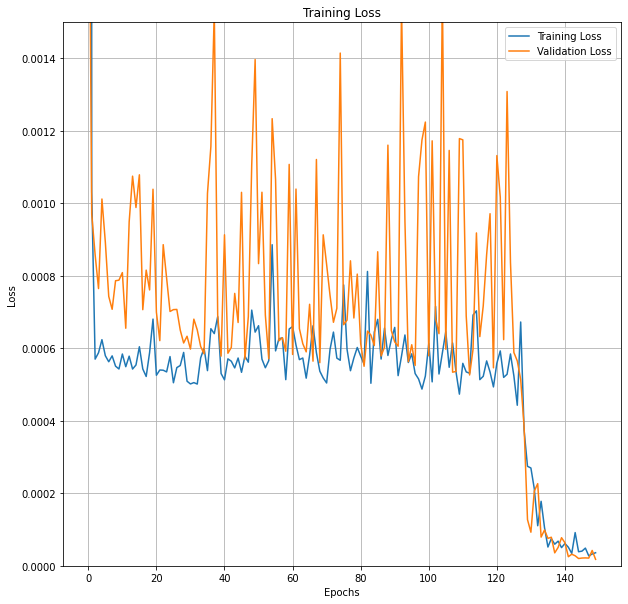

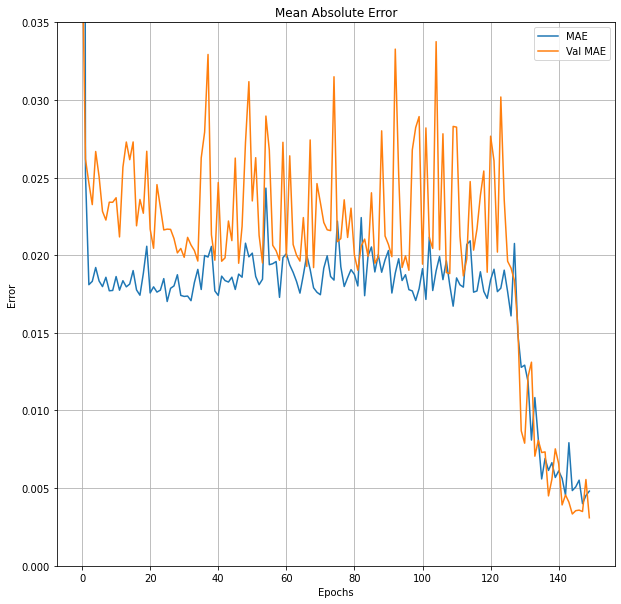

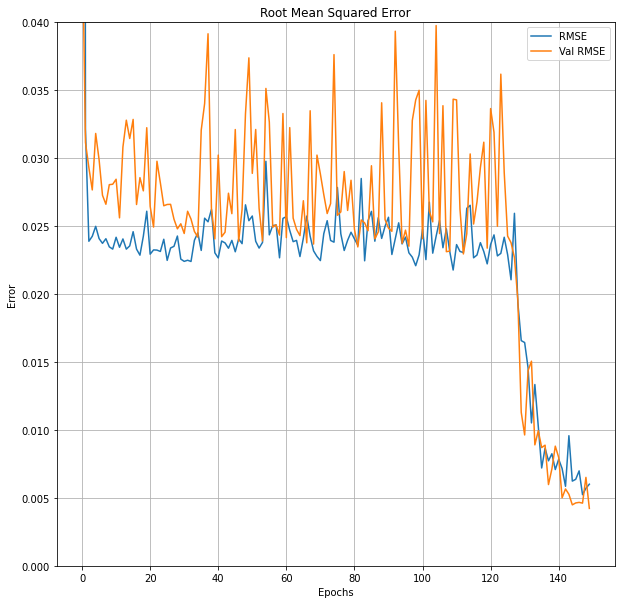

Network architecture :  N50-N150-N50-N50-E150-B32
Validation MAE   : 0.0030928615015000105
Validation RMSE  : 0.004224165342748165


In [63]:
# Based on M30 timeframe

GRU_M30 = retrieve('M30', 'GRU', plot_fig=True)

In [64]:
# Predicted output using best model for GRU M30

predictedGRUM30 = GRU_M30.predict(train_M30)

40/40 [==============================] - 30s 703ms/step


Minimum loss among all models: 1.3945666978543159e-05
Minimum val_loss among all models: 5.635306479234714e-06
Index for best model using loss: 563
Index for best model using val_loss: 252
Best model - Loss:  3.347134406794794e-05
Best model - Val_Loss:  5.635306479234714e-06


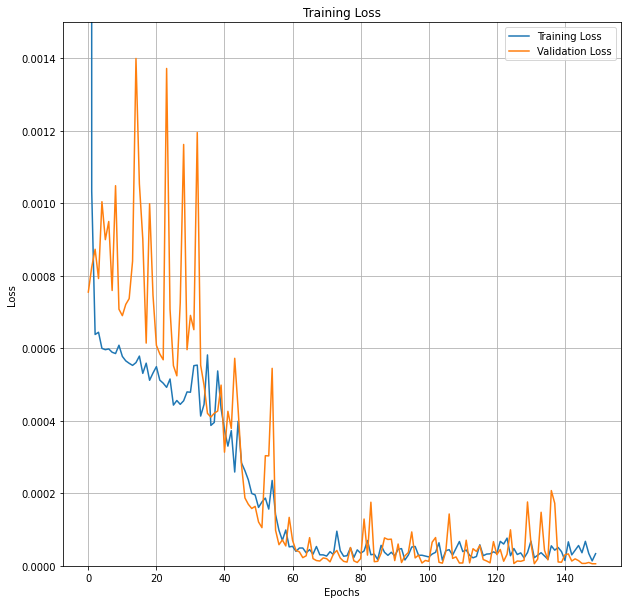

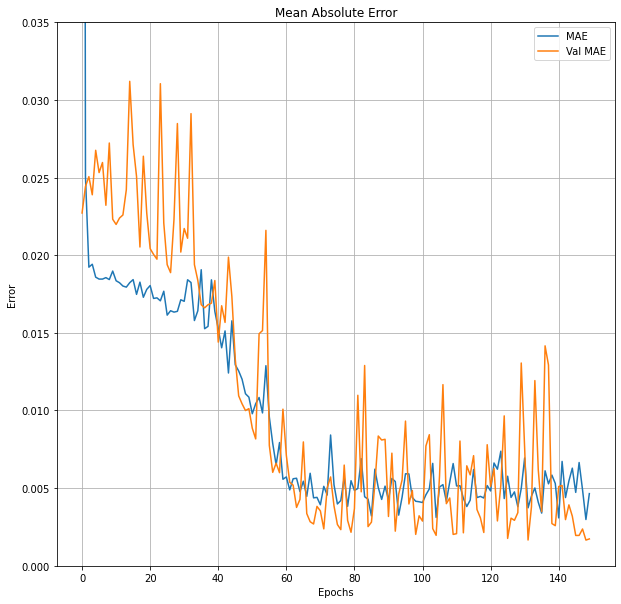

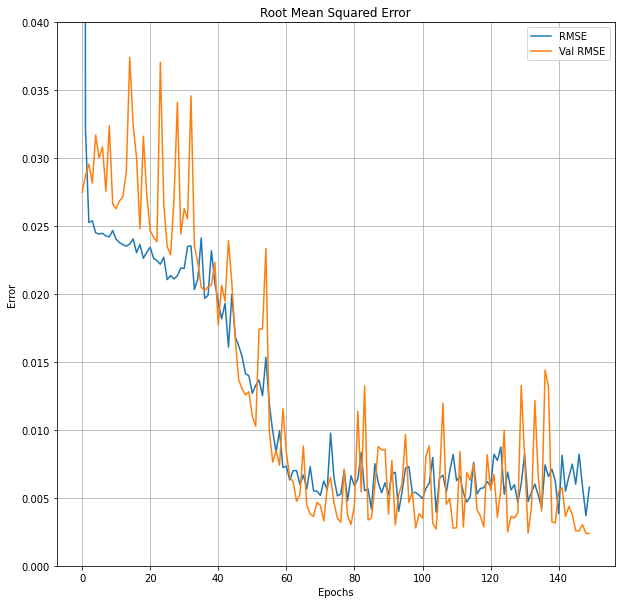

Network architecture :  N100-N50-N50-N100-E150-B32
Validation MAE   : 0.0017305782530456781
Validation RMSE  : 0.0023738800082355738


In [65]:
# Based on H1 timeframe

GRU_H1 = retrieve('H1', 'GRU', plot_fig=True)

In [66]:
# Predicted output using best model for GRU H1

predictedGRUH1 = GRU_H1.predict(train_H1)

40/40 [==============================] - 11s 237ms/step


Minimum loss among all models: 1.3953917914477643e-05
Minimum val_loss among all models: 7.851143891457468e-06
Index for best model using loss: 257
Index for best model using val_loss: 725
Best model - Loss:  3.34536780428607e-05
Best model - Val_Loss:  7.851143891457468e-06


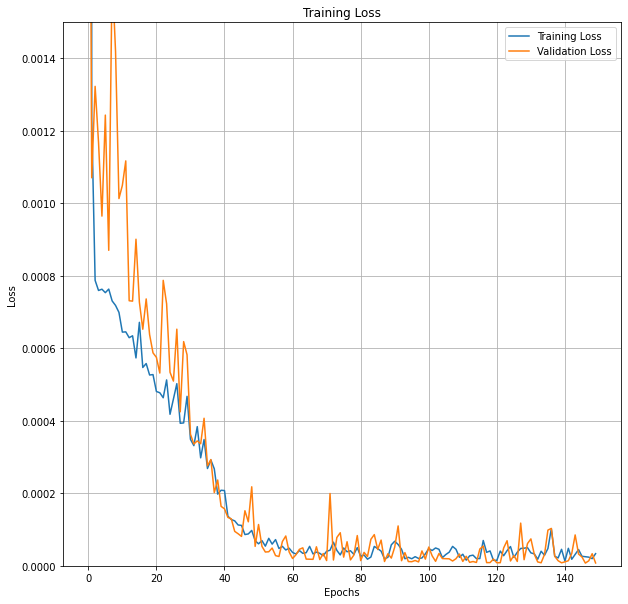

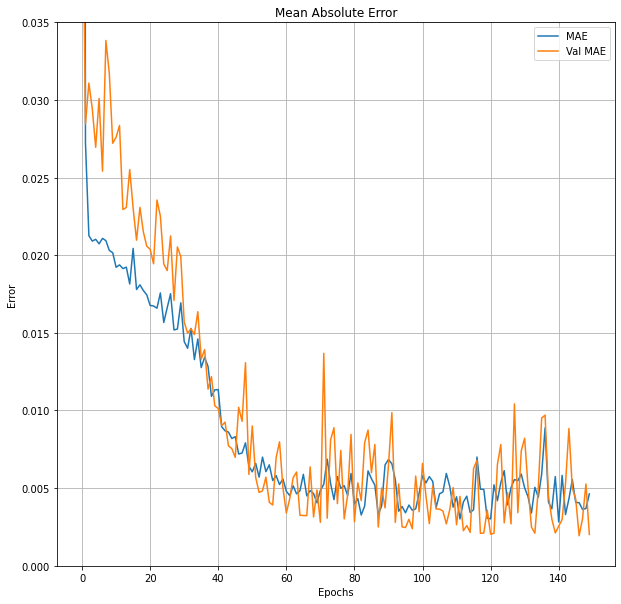

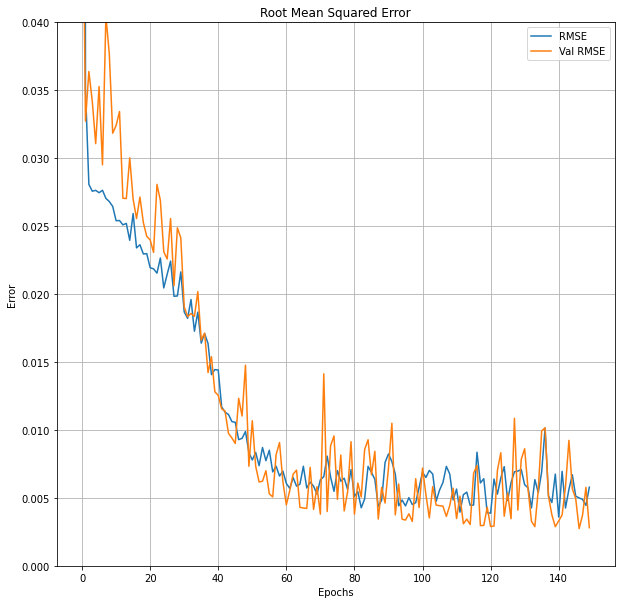

Network architecture :  N150-N50-N50-N50-E150-B32
Validation MAE   : 0.002020536456257105
Validation RMSE  : 0.0028019892051815987


In [67]:
# Based on H2 timeframe

GRU_H2 = retrieve('H2', 'GRU', plot_fig=True)

In [68]:
# Predicted output using best model for GRU H2

predictedGRUH2 = GRU_H2.predict(train_H2)

40/40 [==============================] - 8s 175ms/step


Minimum loss among all models: 1.3928204680269118e-05
Minimum val_loss among all models: 8.53152323543327e-06
Index for best model using loss: 220
Index for best model using val_loss: 220
Best model - Loss:  1.3928204680269118e-05
Best model - Val_Loss:  8.53152323543327e-06


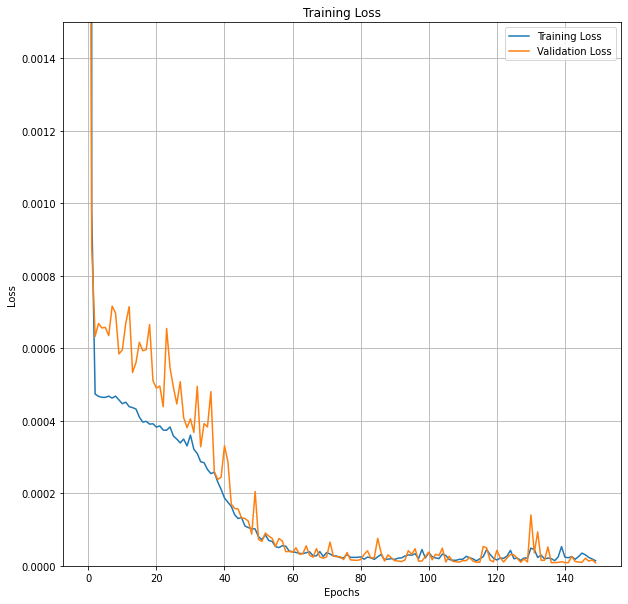

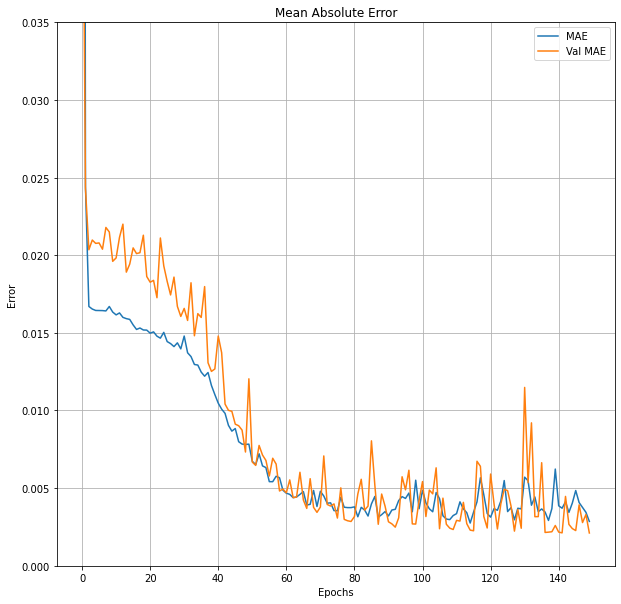

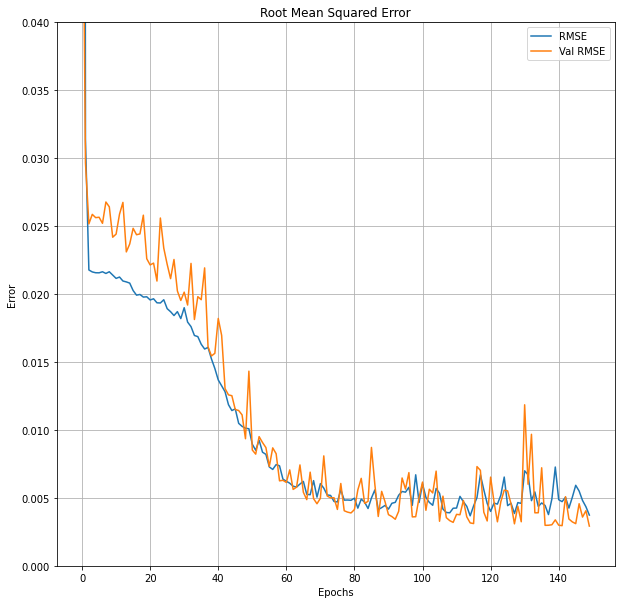

Network architecture :  N100-E150-B32
Validation MAE   : 0.002112806309014559
Validation RMSE  : 0.0029208771884441376


In [69]:
# Based on H4 timeframe

GRU_H4 = retrieve('H4', 'GRU', plot_fig=True)

In [70]:
# Predicted output using best model for GRU H4

predictedGRUH4 = GRU_H4.predict(train_H4)

40/40 [==============================] - 1s 21ms/step


Minimum loss among all models: 1.3143182513886131e-05
Minimum val_loss among all models: 1.0549055332376156e-05
Index for best model using loss: 641
Index for best model using val_loss: 670
Best model - Loss:  2.4716891857679002e-05
Best model - Val_Loss:  1.0549055332376156e-05


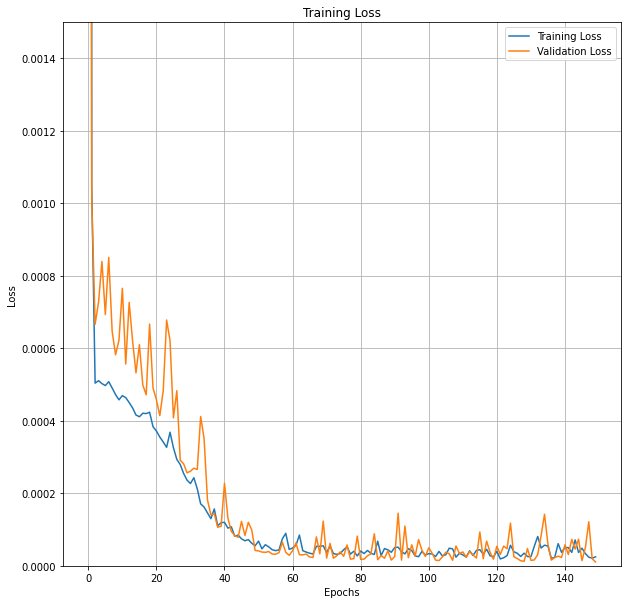

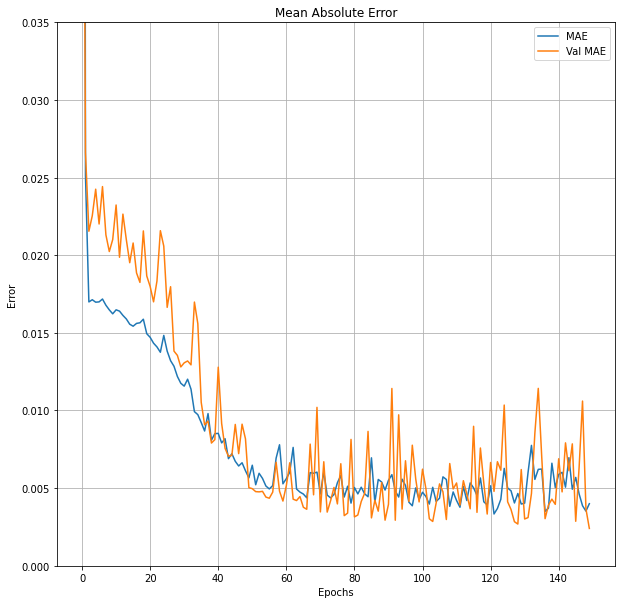

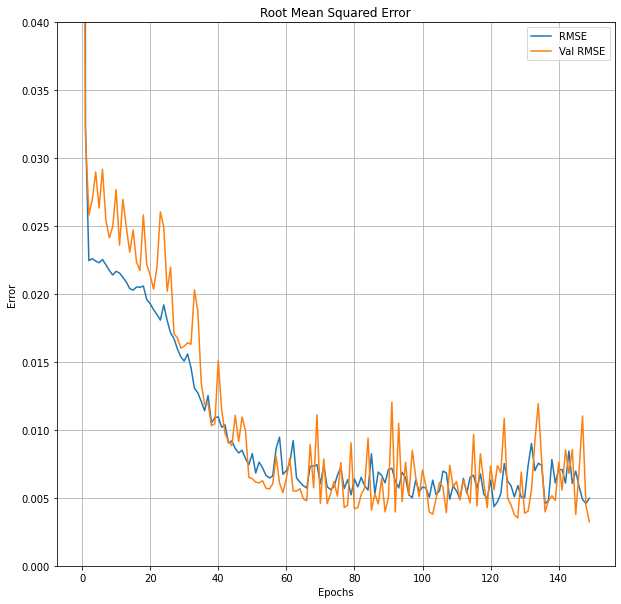

Network architecture :  N150-N50-N50-E150-B32
Validation MAE   : 0.002406103303655982
Validation RMSE  : 0.0032479309011250734


In [71]:
# Based on H6 timeframe

GRU_H6 = retrieve('H6', 'GRU', plot_fig=True)

In [72]:
# Predicted output using best model for GRU H6

predictedGRUH6 = GRU_H6.predict(train_H6)

40/40 [==============================] - 3s 61ms/step


Minimum loss among all models: 1.661168244027067e-05
Minimum val_loss among all models: 1.210868049383862e-05
Index for best model using loss: 326
Index for best model using val_loss: 345
Best model - Loss:  4.034665471408516e-05
Best model - Val_Loss:  1.210868049383862e-05


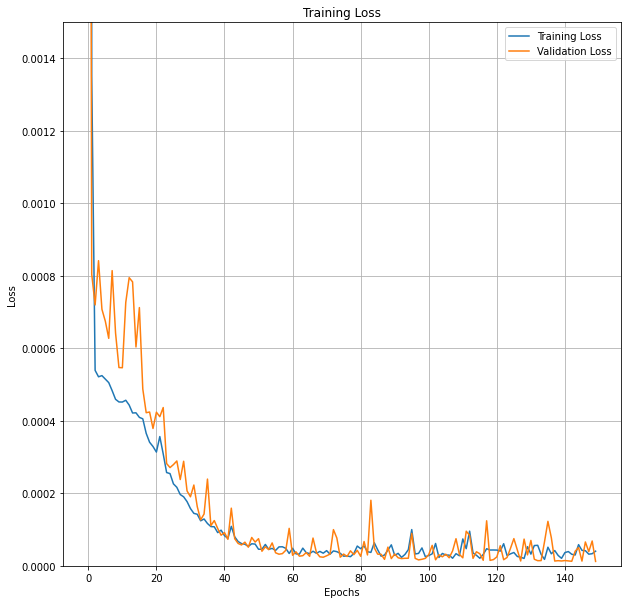

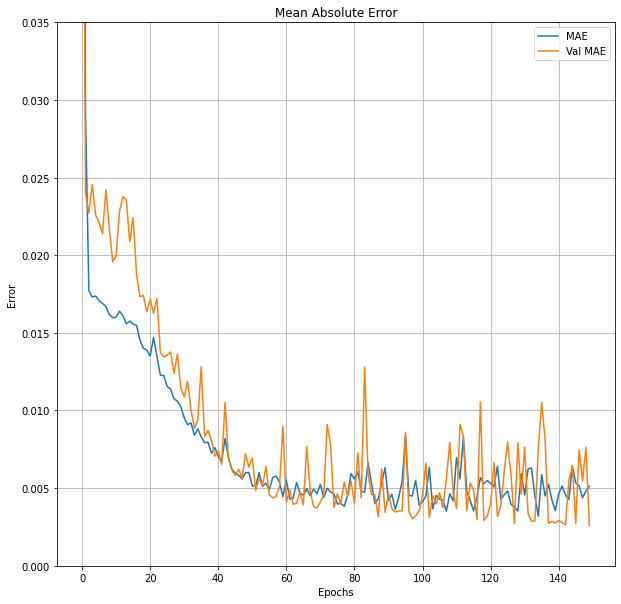

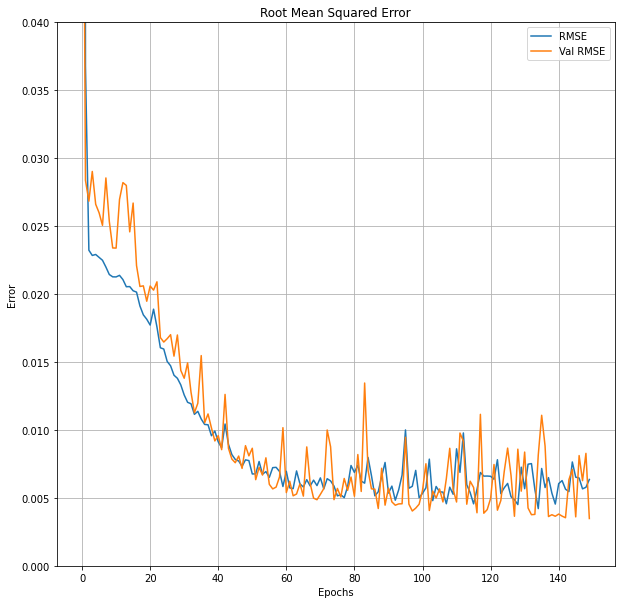

Network architecture :  N50-N50-N50-E150-B32
Validation MAE   : 0.0025849416851997375
Validation RMSE  : 0.0034797529224306345


In [73]:
# Based on H8 timeframe

GRU_H8 = retrieve('H8', 'GRU', plot_fig=True)

In [74]:
# Predicted output using best model for GRU H8

predictedGRUH8 = GRU_H8.predict(train_H8)

40/40 [==============================] - 2s 21ms/step


Minimum loss among all models: 2.270497498102486e-05
Minimum val_loss among all models: 1.0917990948655643e-05
Index for best model using loss: 409
Index for best model using val_loss: 454
Best model - Loss:  6.816098903072998e-05
Best model - Val_Loss:  1.0917990948655643e-05


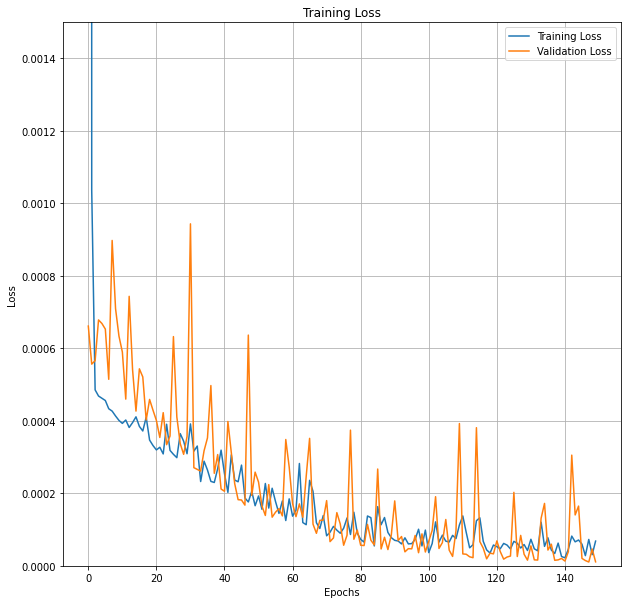

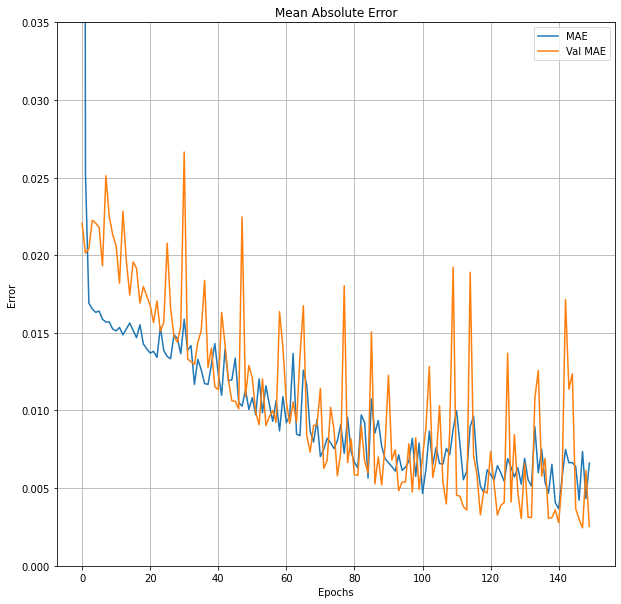

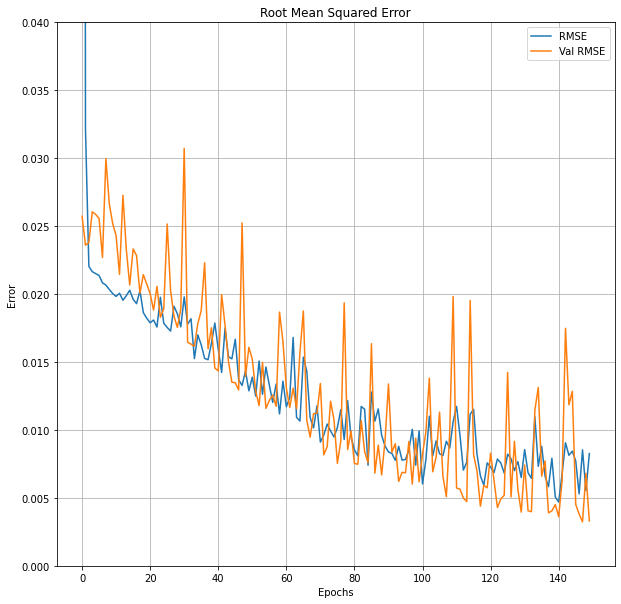

Network architecture :  N50-N100-N150-N50-E150-B32
Validation MAE   : 0.002535854000598192
Validation RMSE  : 0.0033042384311556816


In [75]:
# Based on H24 timeframe

GRU_H24 = retrieve('H24', 'GRU', plot_fig=True)

In [76]:
# Predicted output using best model for GRU H24

predictedGRUH24 = GRU_H24.predict(train_H24)

40/40 [==============================] - 2s 22ms/step


In [77]:
# Display first five rows of predicted output from the GRU models

exampleDisplay = np.concatenate((predictedGRUM30[0:5], predictedGRUH1[0:5], predictedGRUH2[0:5], predictedGRUH4[0:5], predictedGRUH6[0:5], predictedGRUH8[0:5], predictedGRUH24[0:5]), axis=1)
predictedDisplay = pd.DataFrame(exampleDisplay, columns = ['M30', 'H1', 'H2', 'H4','H6', 'H8', 'H24'])
predictedDisplay['Actual'] = df_new_train_H24.iloc[0:5, 3]
predictedDisplay

M30        H1        H2        H4        H6        H8       H24  \
0  1.116308  1.120412  1.120557  1.120145  1.118438  1.118039  1.117535   
1  1.111919  1.117010  1.116794  1.115613  1.113680  1.113278  1.114114   
2  1.106673  1.110617  1.110988  1.110143  1.108831  1.108985  1.109892   
3  1.105942  1.109235  1.109748  1.109051  1.107954  1.108239  1.109290   
4  1.106139  1.109684  1.110179  1.109497  1.108510  1.108676  1.110084   

    Actual  
0  1.11985  
1  1.11759  
2  1.10963  
3  1.10829  
4  1.10883

##3.2 LSTM - Loading best performing models

Minimum loss among all models: 0.00045924127334728837
Minimum val_loss among all models: 0.0005210557719692588
Index for best model using loss: 461
Index for best model using val_loss: 214
Best model - Loss:  0.0005221299361437559
Best model - Val_Loss:  0.0005210557719692588


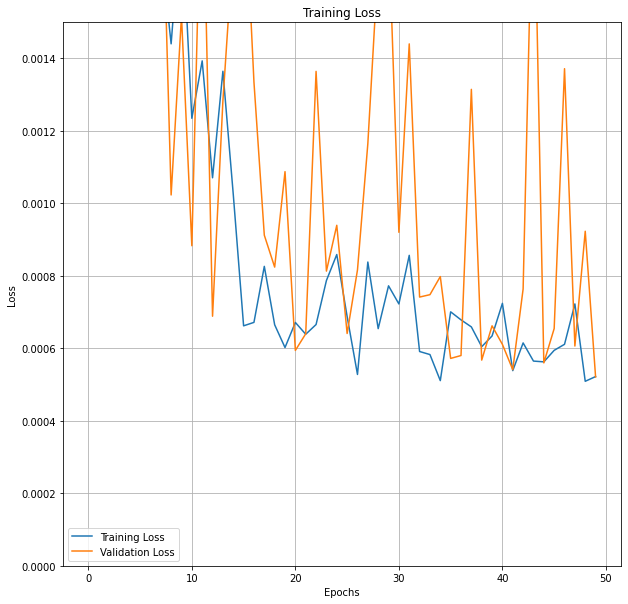

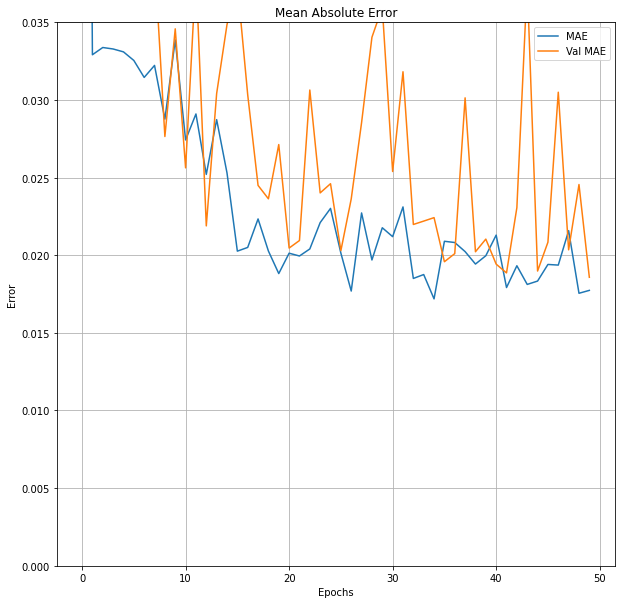

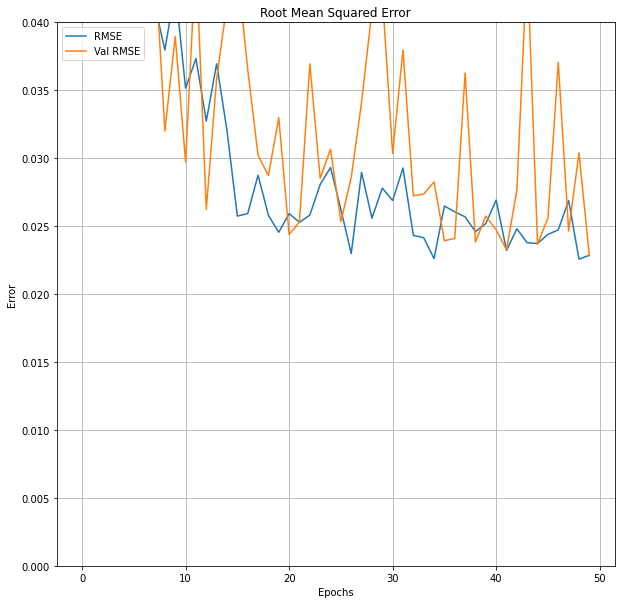

Network architecture :  N150-N150-N50-N50-E50-B32
Validation MAE   : 0.01857546716928482
Validation RMSE  : 0.022826645523309708


In [78]:
# Based on M30 timeframe

LSTM_M30 = retrieve('M30', 'LSTM', plot_fig=True)

In [79]:
# Predicted output using best model for LSTM M30

predictedLSTMM30 = LSTM_M30.predict(train_M30)

40/40 [==============================] - 55s 1s/step


Minimum loss among all models: 0.0004099278012290597
Minimum val_loss among all models: 0.00040117427124641836
Index for best model using loss: 733
Index for best model using val_loss: 923
Best model - Loss:  0.0004587160365190357
Best model - Val_Loss:  0.00040117427124641836


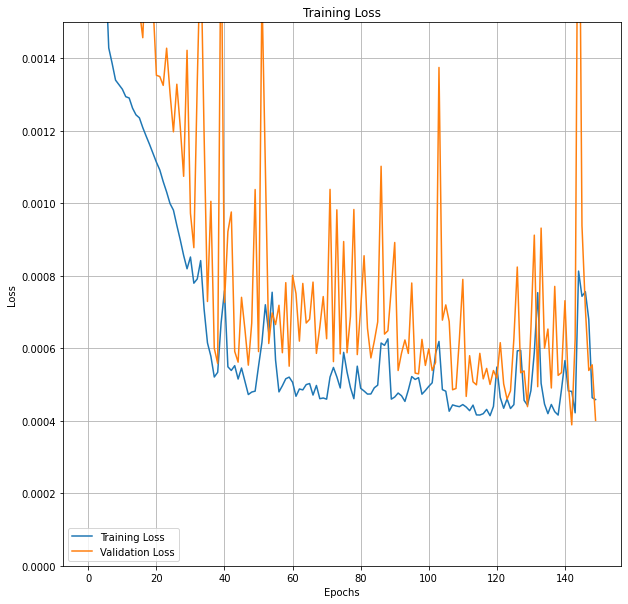

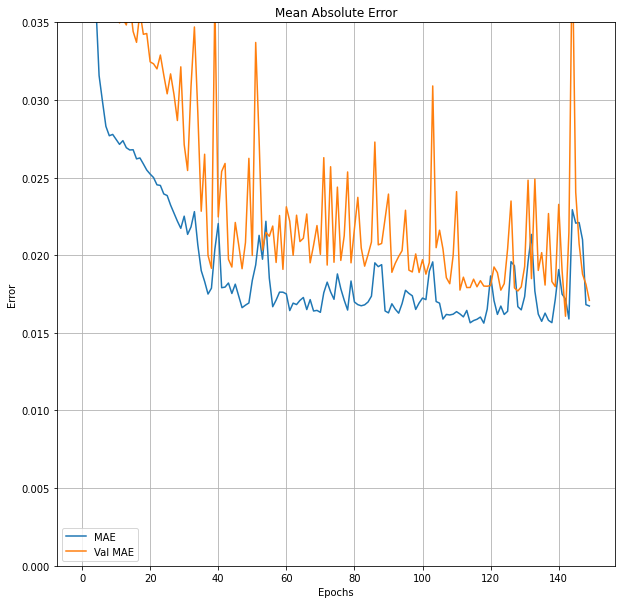

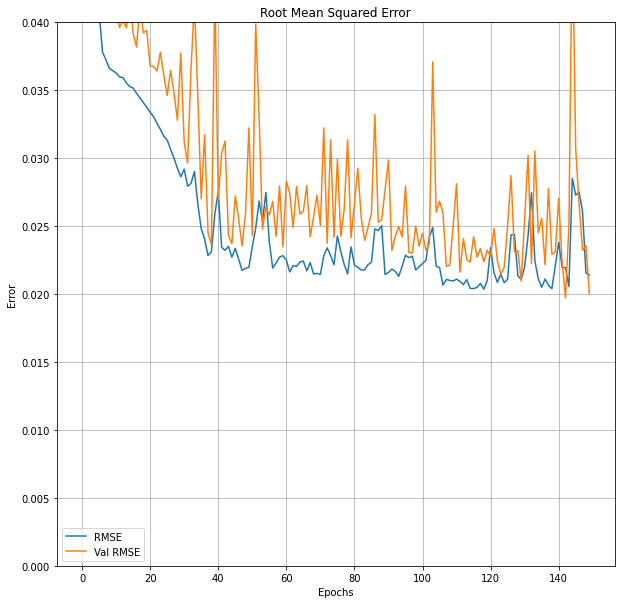

Network architecture :  N50-N50-N150-N50-E150-B128
Validation MAE   : 0.017089135944843292
Validation RMSE  : 0.020029334351420403


In [80]:
# Based on H1 timeframe

LSTM_H1 = retrieve('H1', 'LSTM', plot_fig=True)

In [81]:
# Predicted output using best model for LSTM H1

predictedLSTMH1 = LSTM_H1.predict(train_H1)

40/40 [==============================] - 18s 410ms/step


Minimum loss among all models: 5.2485367632471025e-05
Minimum val_loss among all models: 4.978069046046585e-05
Index for best model using loss: 826
Index for best model using val_loss: 844
Best model - Loss:  0.00023177816183306277
Best model - Val_Loss:  4.978069046046585e-05


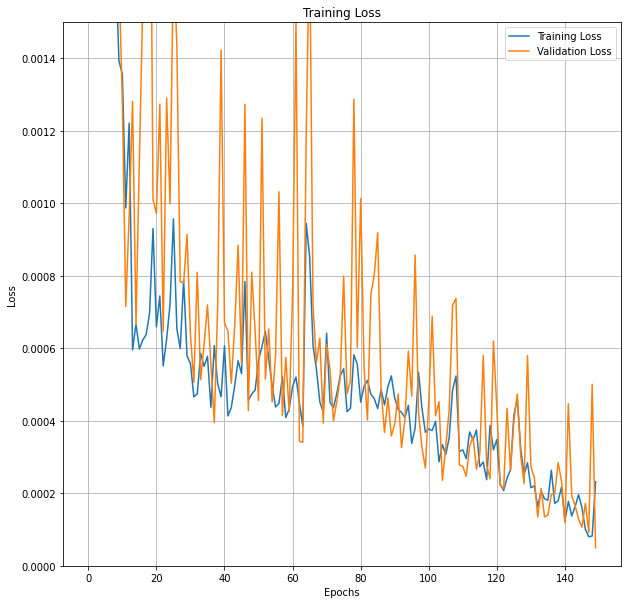

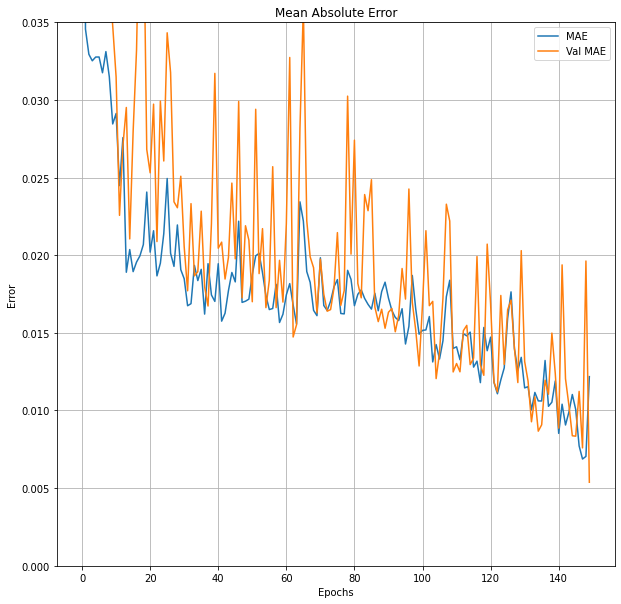

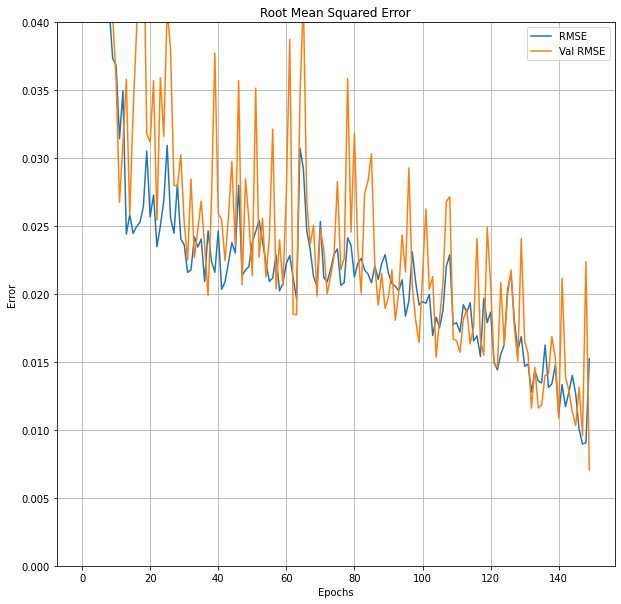

Network architecture :  N100-N150-N50-N50-E150-B32
Validation MAE   : 0.00537974713370204
Validation RMSE  : 0.00705554336309433


In [82]:
# Based on H2 timeframe

LSTM_H2 = retrieve('H2', 'LSTM', plot_fig=True)

In [83]:
# Predicted output using best model for LSTM H2

predictedLSTMH2 = LSTM_H2.predict(train_H2)

40/40 [==============================] - 14s 303ms/step


Minimum loss among all models: 3.8548569136764854e-05
Minimum val_loss among all models: 2.7771899112849496e-05
Index for best model using loss: 502
Index for best model using val_loss: 502
Best model - Loss:  3.8548569136764854e-05
Best model - Val_Loss:  2.7771899112849496e-05


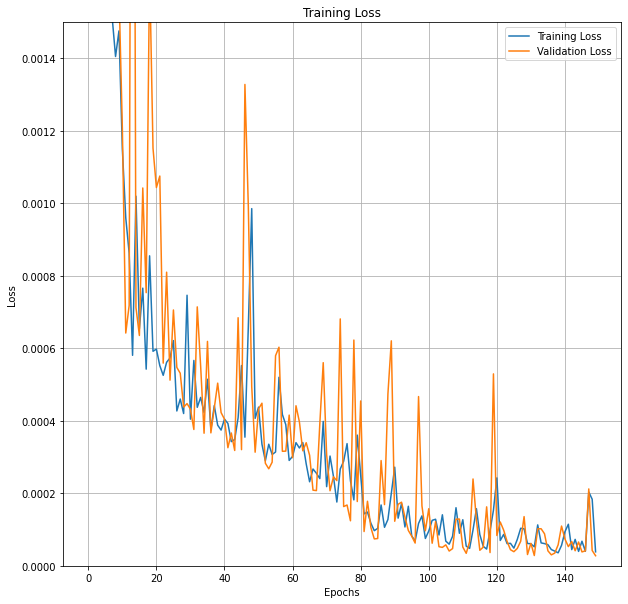

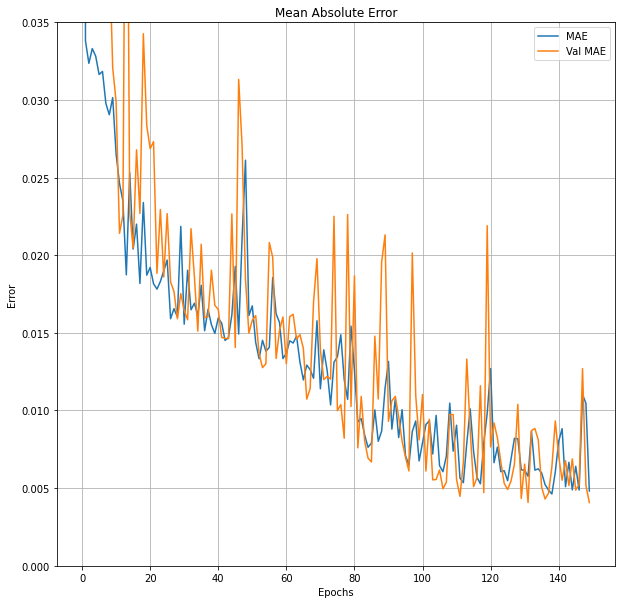

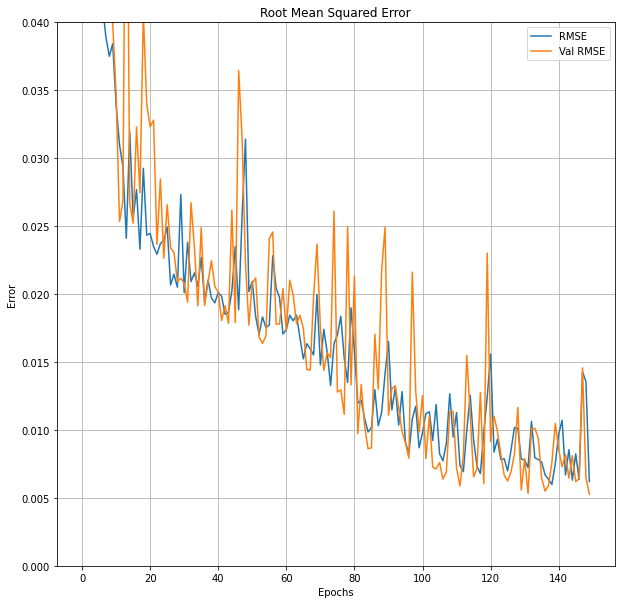

Network architecture :  N50-N100-N50-N50-E150-B32
Validation MAE   : 0.0040722861886024475
Validation RMSE  : 0.005269905086606741


In [84]:
# Based on H4 timeframe

LSTM_H4 = retrieve('H4', 'LSTM', plot_fig=True)

In [85]:
# Predicted output using best model for LSTM H4

predictedLSTMH4 = LSTM_H4.predict(train_H4)

40/40 [==============================] - 4s 70ms/step


Minimum loss among all models: 6.479005241999403e-05
Minimum val_loss among all models: 3.9553779060952365e-05
Index for best model using loss: 1075
Index for best model using val_loss: 31
Best model - Loss:  0.00011517439997987822
Best model - Val_Loss:  3.9553779060952365e-05


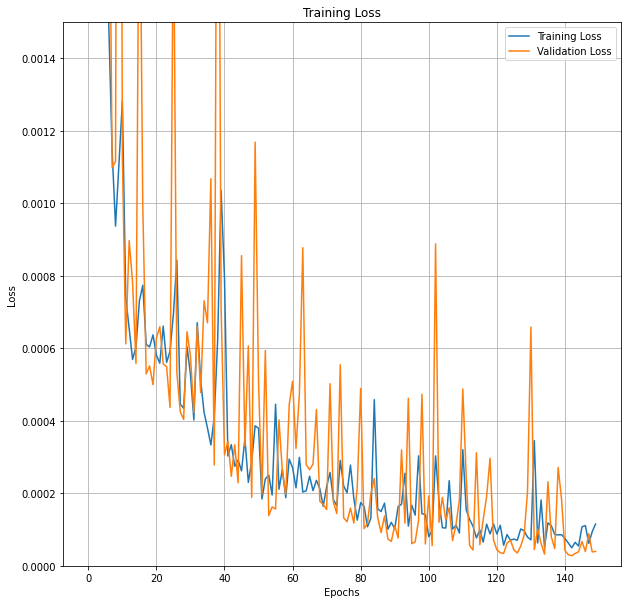

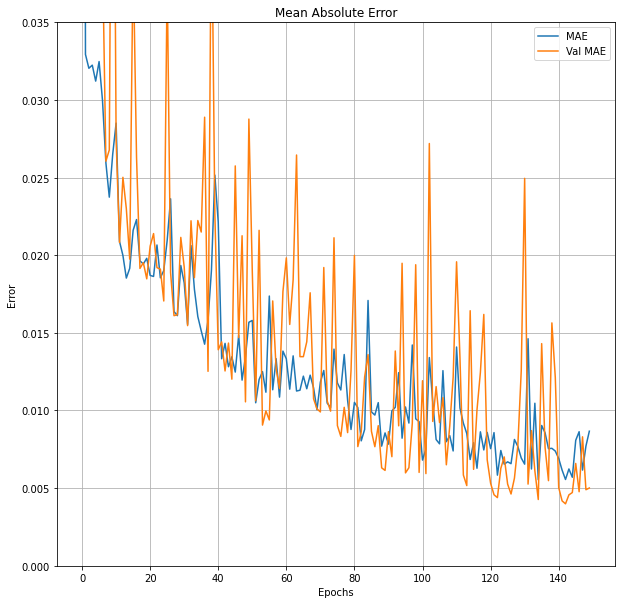

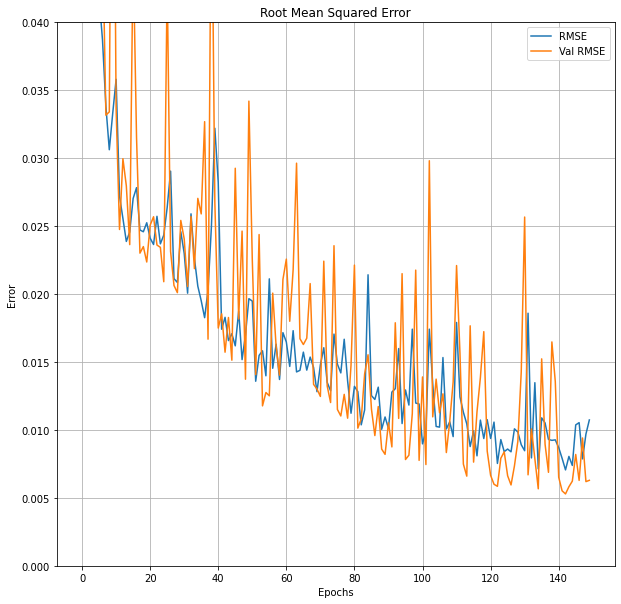

Network architecture :  N150-N150-N50-N50-E150-B32
Validation MAE   : 0.005009374115616083
Validation RMSE  : 0.006289179436862469


In [86]:
# Based on H6 timeframe

LSTM_H6 = retrieve('H6', 'LSTM', plot_fig=True)

In [87]:
# Predicted output using best model for LSTM H6

predictedLSTMH6 = LSTM_H6.predict(train_H6)

40/40 [==============================] - 6s 121ms/step


Minimum loss among all models: 5.44691392860841e-05
Minimum val_loss among all models: 5.034973946749233e-05
Index for best model using loss: 1048
Index for best model using val_loss: 1042
Best model - Loss:  8.36326798889786e-05
Best model - Val_Loss:  5.034973946749233e-05


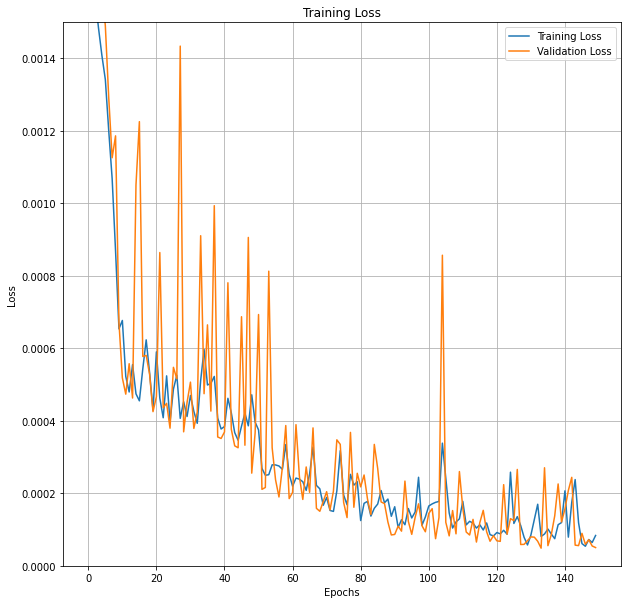

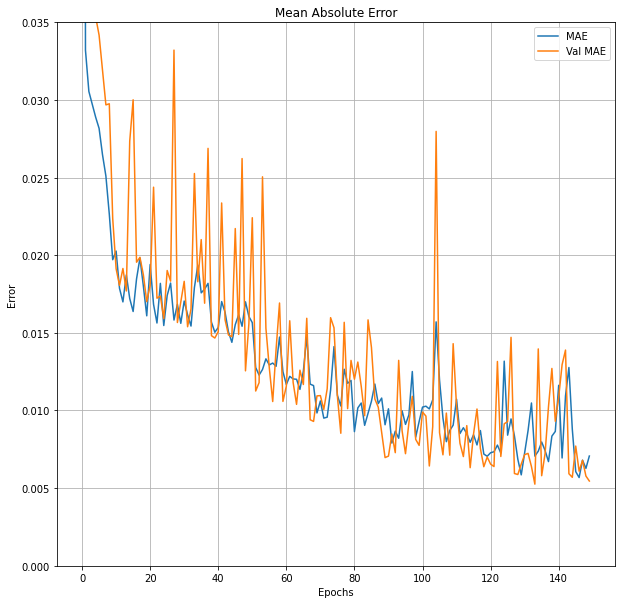

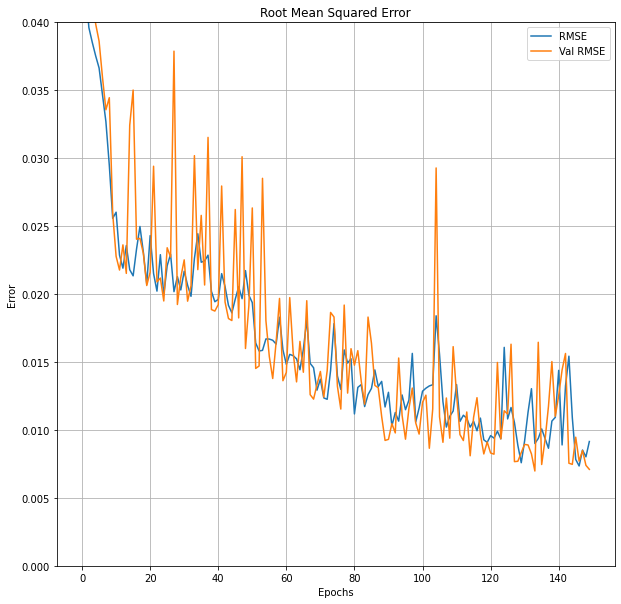

Network architecture :  N50-N50-N100-N50-E150-B32
Validation MAE   : 0.005459132604300976
Validation RMSE  : 0.007095755077898502


In [88]:
# Based on H8 timeframe

LSTM_H8 = retrieve('H8', 'LSTM', plot_fig=True)

In [89]:
# Predicted output using best model for LSTM H8

predictedLSTMH8 = LSTM_H8.predict(train_H8)

40/40 [==============================] - 3s 38ms/step


Minimum loss among all models: 6.67003114358522e-05
Minimum val_loss among all models: 5.300086922943592e-05
Index for best model using loss: 101
Index for best model using val_loss: 96
Best model - Loss:  0.00013677436800207943
Best model - Val_Loss:  5.300086922943592e-05


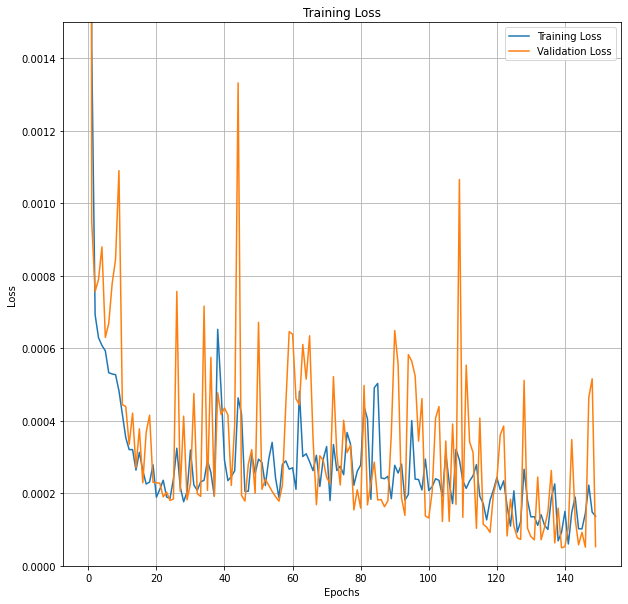

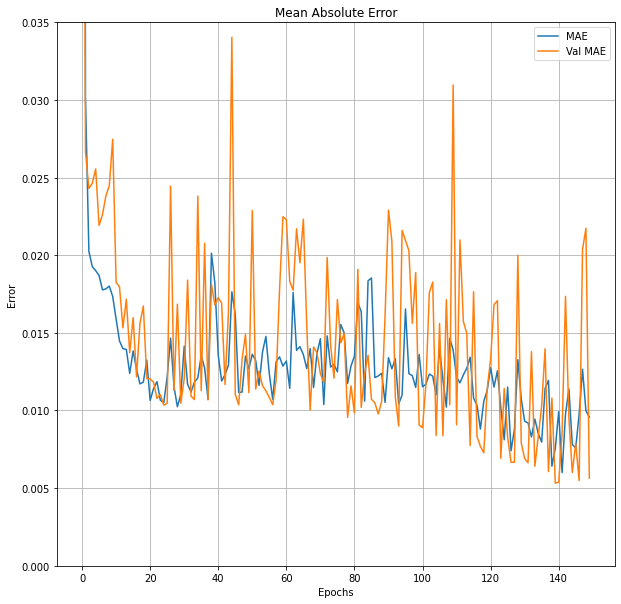

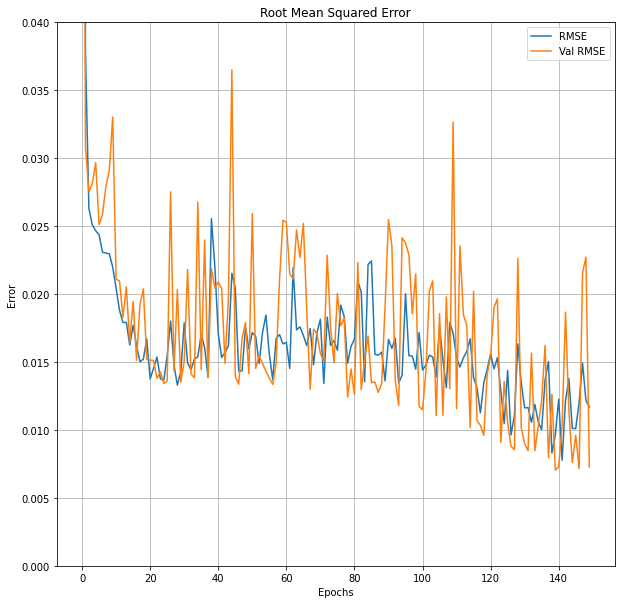

Network architecture :  N50-N100-N150-N150-E150-B32
Validation MAE   : 0.005651539191603661
Validation RMSE  : 0.007280169520527124


In [90]:
# Based on H24 timeframe

LSTM_H24 = retrieve('H24', 'LSTM', plot_fig=True)

In [91]:
# Predicted output using best model for LSTM H24

predictedLSTMH24 = LSTM_H24.predict(train_H24)

40/40 [==============================] - 3s 39ms/step


In [92]:
# Display first five rows of predicted output from the LSTM models

exampleDisplay = np.concatenate((predictedLSTMM30[0:5], predictedLSTMH1[0:5], predictedLSTMH2[0:5], predictedLSTMH4[0:5], predictedLSTMH6[0:5], predictedLSTMH8[0:5], predictedLSTMH24[0:5]), axis=1)
predictedDisplay = pd.DataFrame(exampleDisplay, columns = ['M30', 'H1', 'H2', 'H4','H6', 'H8', 'H24'] )
predictedDisplay['Actual'] = df_new_train_H24.iloc[0:5, 3]
predictedDisplay

M30        H1        H2        H4        H6        H8       H24  \
0  1.111810  1.112943  1.116154  1.116260  1.112741  1.118323  1.117368   
1  1.109004  1.110106  1.113350  1.111571  1.108469  1.115322  1.115898   
2  1.108979  1.109391  1.112303  1.108754  1.106429  1.113754  1.114548   
3  1.108721  1.108955  1.112595  1.108267  1.106364  1.113931  1.114802   
4  1.109591  1.109490  1.113396  1.108638  1.107073  1.114769  1.115507   

    Actual  
0  1.11985  
1  1.11759  
2  1.10963  
3  1.10829  
4  1.10883

#4.0 Model Evaluation for Phase 2: Dense layers

1. Taking best performing model from section 3 to compute the prediction output.

In [93]:
# Training set will be retrieved from section 3
# Preparing testing set based on best performing models

# GRU
GRU_test_M30 = GRU_M30.predict(test_M30)
GRU_test_H1 = GRU_H1.predict(test_H1)
GRU_test_H2 = GRU_H2.predict(test_H2)
GRU_test_H4 = GRU_H4.predict(test_H4)
GRU_test_H6 = GRU_H6.predict(test_H6)
GRU_test_H8 = GRU_H8.predict(test_H8)
GRU_test_H24 = GRU_H24.predict(test_H24)

# LSTM
LSTM_test_M30 = LSTM_M30.predict(test_M30)
LSTM_test_H1 = LSTM_H1.predict(test_H1)
LSTM_test_H2 = LSTM_H2.predict(test_H2)
LSTM_test_H4 = LSTM_H4.predict(test_H4)
LSTM_test_H6 = LSTM_H6.predict(test_H6)
LSTM_test_H8 = LSTM_H8.predict(test_H8)
LSTM_test_H24 = LSTM_H24.predict(test_H24)

8/8 [==============================] - 0s 35ms/step


##4.1 GRU-Dense - Loading best performing models

Minimum loss among all models: 1.0057369763671886e-05
Minimum val_loss among all models: 8.494310350215528e-06
Index for best model using loss: 400
Index for best model using val_loss: 400
Best model - Loss:  1.0057369763671886e-05
Best model - Val_Loss:  8.494310350215528e-06


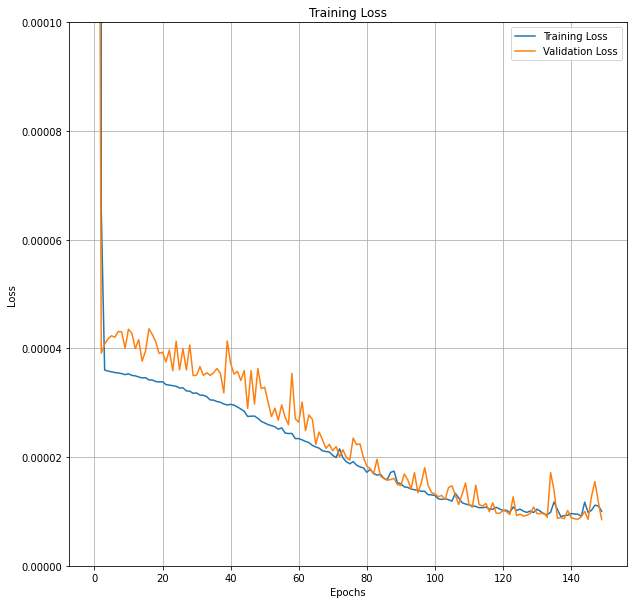

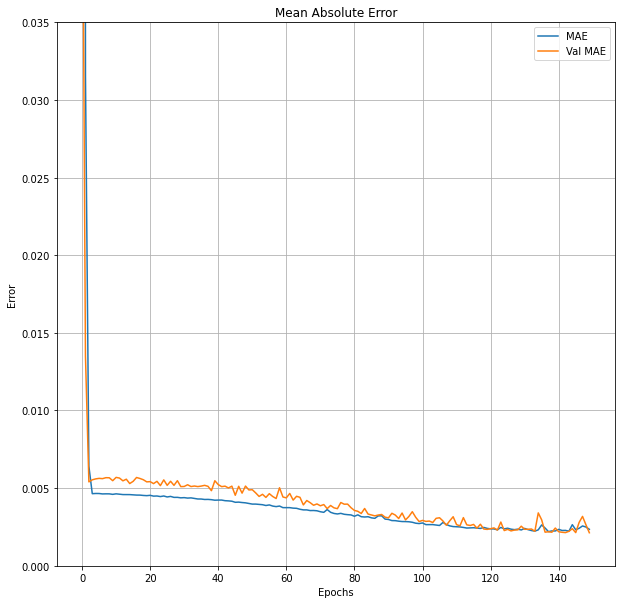

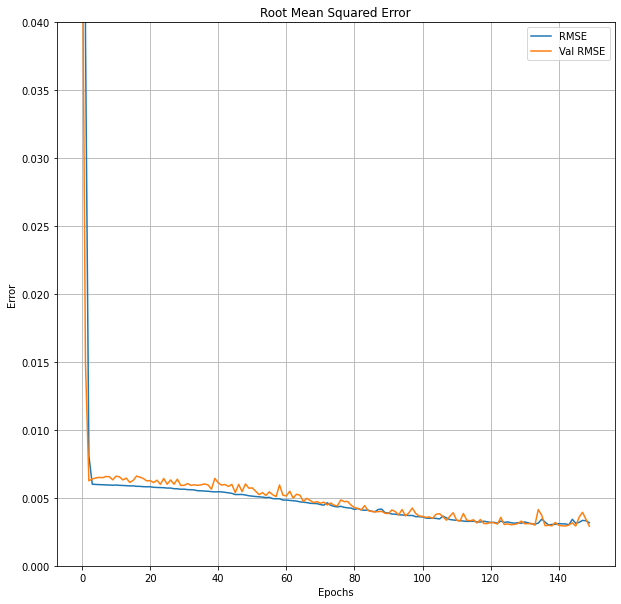

Network architecture :  N50-E150-B32
Validation MAE   : 0.0021278688218444586
Validation RMSE  : 0.002914499957114458
8/8 [==============================] - 0s 3ms/step


In [94]:
# GRU-Dense using M30 H4 H24

# Preparing training set
art1 = np.column_stack((predictedGRUM30,
                        predictedGRUH4[:len(predictedGRUM30)],
                        predictedGRUH24[:len(predictedGRUM30)]))
df_train_GRU_1 = pd.DataFrame(art1, columns=['M30', 'H4', 'H24'])

# Preparing testing set
arr1 = np.column_stack((GRU_test_M30,
                        GRU_test_H4[:len(GRU_test_M30)],
                        GRU_test_H24[:len(GRU_test_M30)]))
df_test_GRU_1 = pd.DataFrame(arr1, columns=['M30', 'H4', 'H24'])

# Retrieve best dense model
DenseGRU_M30_H4_H24 = retrieve('M30_H4_H24', 'GRU_Dense', plot_fig=True, loss_ylim=0.0001)

# Predict training set using best dense model
y_pred_GRU_t1 = DenseGRU_M30_H4_H24.predict(df_train_GRU_1)
y_actual_GRU_t1 = df_new_train_H24.iloc[:len(y_pred_GRU_t1), 3]

# Predict testing set using best dense model
y_pred_GRU_1 = DenseGRU_M30_H4_H24.predict(df_test_GRU_1)
y_actual_GRU_1 = df_new_test_H24.iloc[:len(y_pred_GRU_1), 3]

Minimum loss among all models: 8.824294127407484e-06
Minimum val_loss among all models: 9.271897397411522e-06
Index for best model using loss: 883
Index for best model using val_loss: 883
Best model - Loss:  8.824294127407484e-06
Best model - Val_Loss:  9.271897397411522e-06


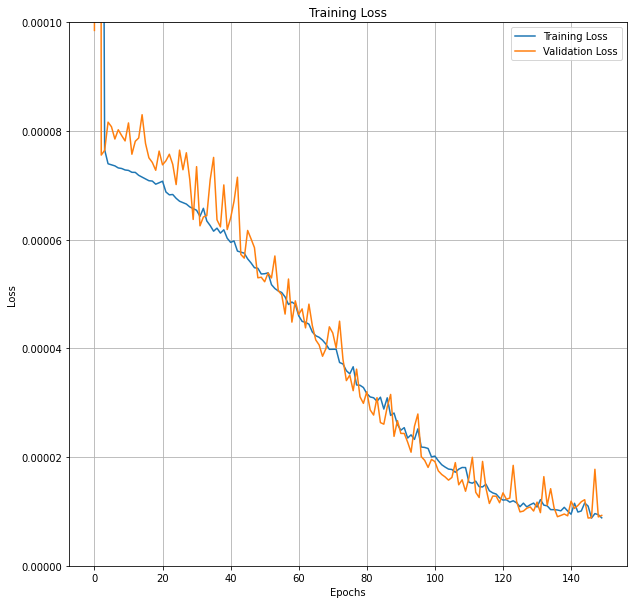

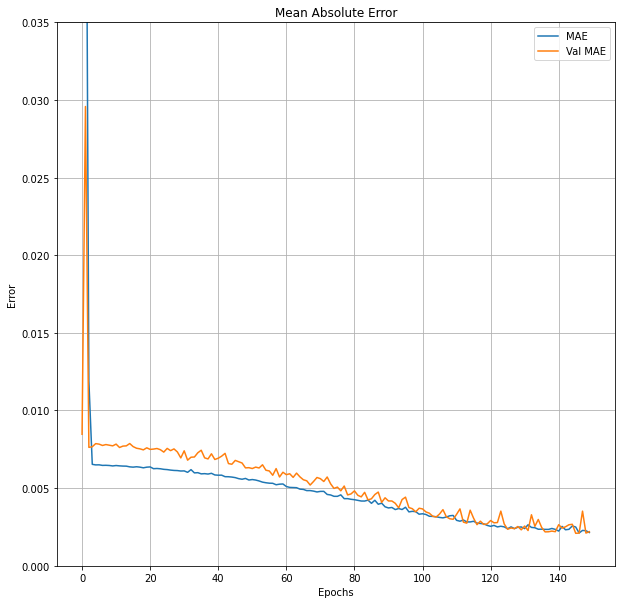

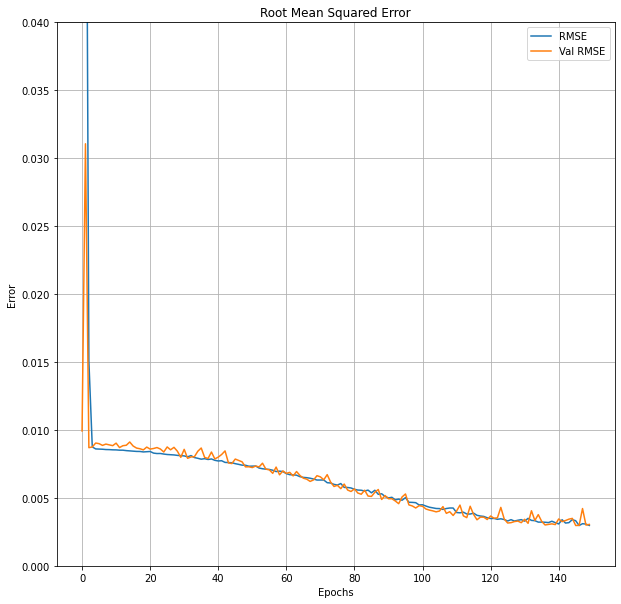

Network architecture :  N50-N50-E150-B32
Validation MAE   : 0.0021968127693980932
Validation RMSE  : 0.0030449789483100176
8/8 [==============================] - 0s 2ms/step


In [95]:
# GRU-Dense using M30 H2 H8

# Preparing training set
art2 = np.column_stack((predictedGRUM30,
                        predictedGRUH2[:len(predictedGRUM30)],
                        predictedGRUH8[:len(predictedGRUM30)]))
df_train_GRU_2 = pd.DataFrame(art2, columns=['M30', 'H2', 'H8'])

# Preparing testing set
arr2 = np.column_stack((GRU_test_M30,
                        GRU_test_H2[:len(GRU_test_M30)],
                        GRU_test_H8[:len(GRU_test_M30)]))
df_test_GRU_2 = pd.DataFrame(arr2, columns=['M30', 'H2', 'H8'])

# Retrieve best dense model
DenseGRU_M30_H2_H8 = retrieve('M30_H2_H8', 'GRU_Dense', plot_fig=True, loss_ylim=0.0001)

# Predict training set using best dense model
y_pred_GRU_t2 = DenseGRU_M30_H2_H8.predict(df_train_GRU_2)
y_actual_GRU_t2 = df_new_train_H24.iloc[:len(y_pred_GRU_t2), 3]

# Predict testing set using best dense model
y_pred_GRU_2 = DenseGRU_M30_H2_H8.predict(df_test_GRU_2)
y_actual_GRU_2 = df_new_test_H24.iloc[:len(y_pred_GRU_2), 3]

Minimum loss among all models: 6.573667178599862e-06
Minimum val_loss among all models: 6.212056177901104e-06
Index for best model using loss: 302
Index for best model using val_loss: 678
Best model - Loss:  1.8427295799483545e-05
Best model - Val_Loss:  6.212056177901104e-06


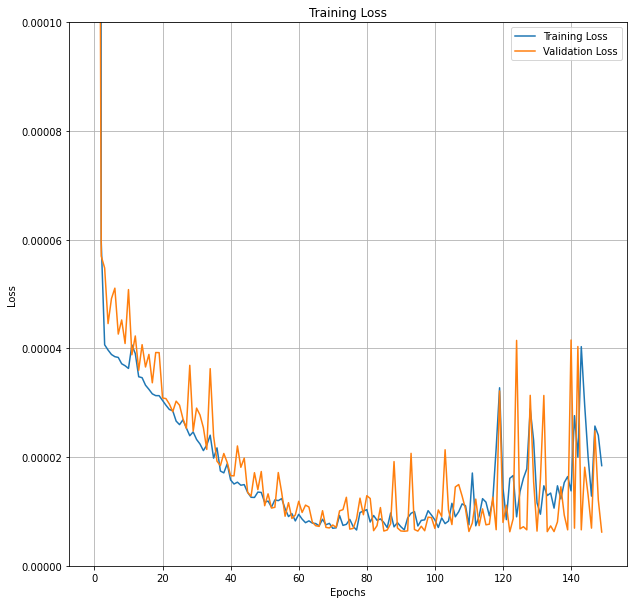

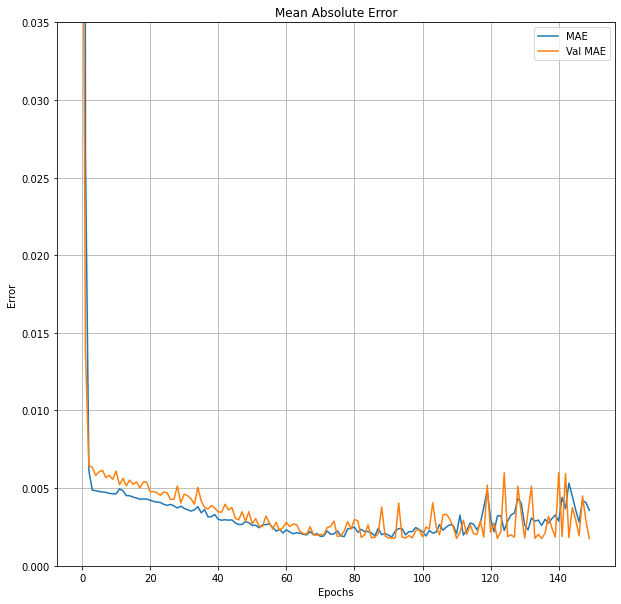

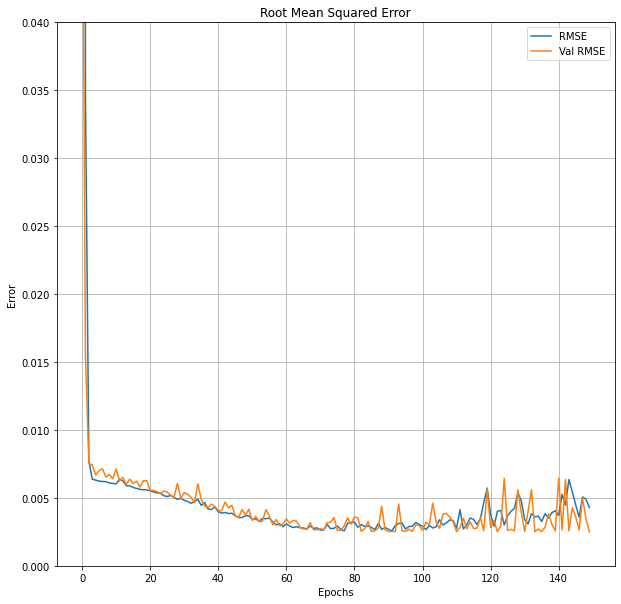

Network architecture :  N150-N150-N150-E150-B32
Validation MAE   : 0.0017566961469128728
Validation RMSE  : 0.0024923996534198523
8/8 [==============================] - 0s 2ms/step


In [96]:
# GRU-Dense using H1 H6

# Preparing training set
art3 = np.column_stack((predictedGRUH1,
                        predictedGRUH6[:len(predictedGRUH1)]))
df_train_GRU_3 = pd.DataFrame(art3, columns=['H1', 'H6'])

# Preparing testing set
arr3 = np.column_stack((GRU_test_H1,
                        GRU_test_H6[:len(GRU_test_H1)]))
df_test_GRU_3 = pd.DataFrame(arr3, columns=['H1', 'H6'])

# Retrieve best dense model
DenseGRU_H1_H6 = retrieve('H1_H6', 'GRU_Dense', plot_fig=True, loss_ylim=0.0001)

# Predict training set using best dense model
y_pred_GRU_t3 = DenseGRU_H1_H6.predict(df_train_GRU_3)
y_actual_GRU_t3 = df_new_train_H24.iloc[:len(y_pred_GRU_t3), 3]

# Predict testing set using best dense model
y_pred_GRU_3 = DenseGRU_H1_H6.predict(df_test_GRU_3)
y_actual_GRU_3 = df_new_test_H24.iloc[:len(y_pred_GRU_3), 3]

Minimum loss among all models: 5.680533377017127e-06
Minimum val_loss among all models: 6.128983841335867e-06
Index for best model using loss: 807
Index for best model using val_loss: 344
Best model - Loss:  9.361381671624258e-06
Best model - Val_Loss:  6.128983841335867e-06


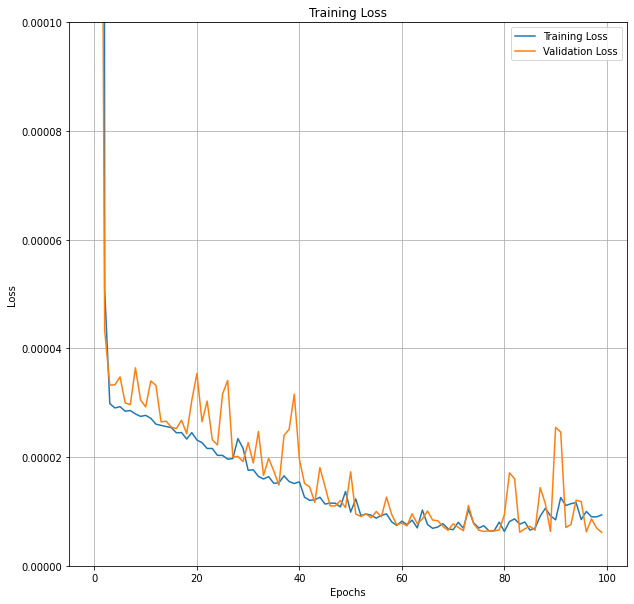

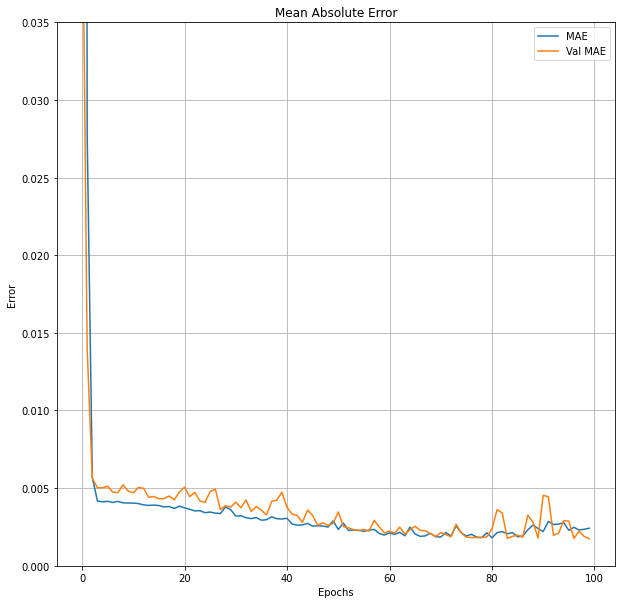

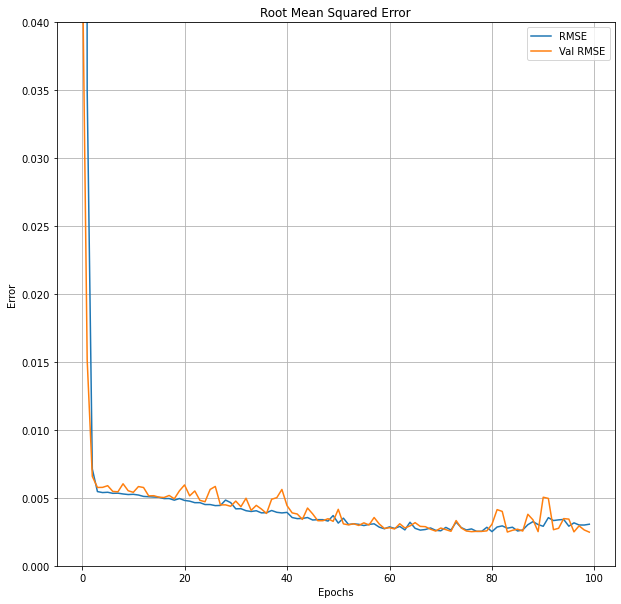

Network architecture :  N50-N150-N150-N100-E100-B32
Validation MAE   : 0.0017389248823747039
Validation RMSE  : 0.0024756784550845623
8/8 [==============================] - 0s 2ms/step


In [97]:
# GRU-Dense using H1 H4

# Preparing training set
art4 = np.column_stack((predictedGRUH1,
                        predictedGRUH4[:len(predictedGRUH1)]))
df_train_GRU_4 = pd.DataFrame(art4, columns=['H1', 'H4'])

# Preparing testing set
arr4 = np.column_stack((GRU_test_H1,
                        GRU_test_H4[:len(GRU_test_H1)]))
df_test_GRU_4 = pd.DataFrame(arr4, columns=['H1', 'H4'])

# Retrieve best dense model
DenseGRU_H1_H4 = retrieve('H1_H4', 'GRU_Dense', plot_fig=True, loss_ylim=0.0001)

# Predict training set using best dense model
y_pred_GRU_t4 = DenseGRU_H1_H4.predict(df_train_GRU_4)
y_actual_GRU_t4 = df_new_train_H24.iloc[:len(y_pred_GRU_t4), 3]

# Predict testing set using best dense model
y_pred_GRU_4 = DenseGRU_H1_H4.predict(df_test_GRU_4)
y_actual_GRU_4 = df_new_test_H24.iloc[:len(y_pred_GRU_4), 3]

In [98]:
# Display first five rows of predicted output from the GRU models

exampleDisplay = np.concatenate((y_pred_GRU_1[0:5], y_pred_GRU_2[0:5], y_pred_GRU_3[0:5], y_pred_GRU_4[0:5]), axis=1)
predictedDisplay = pd.DataFrame(exampleDisplay, columns = ['M30+H4+H24', 'M30+H2+H8', 'H1+H6', 'H1+H4'] )
predictedDisplay['Actual'] = df_new_test_H24.iloc[0:5, 3]
predictedDisplay

M30+H4+H24  M30+H2+H8     H1+H6     H1+H4   Actual
0    1.132527   1.132799  1.132407  1.132480  1.13247
1    1.132594   1.133055  1.133182  1.133127  1.13479
2    1.131866   1.131964  1.131574  1.131800  1.13132
3    1.132418   1.132635  1.132413  1.132610  1.13270
4    1.132021   1.132669  1.132207  1.132346  1.13085

## 4.2 LSTM-Dense - Loading best performing models

Minimum loss among all models: 2.5292800273746252e-05
Minimum val_loss among all models: 2.2732374418410473e-05
Index for best model using loss: 798
Index for best model using val_loss: 798
Best model - Loss:  2.5292800273746252e-05
Best model - Val_Loss:  2.2732374418410473e-05


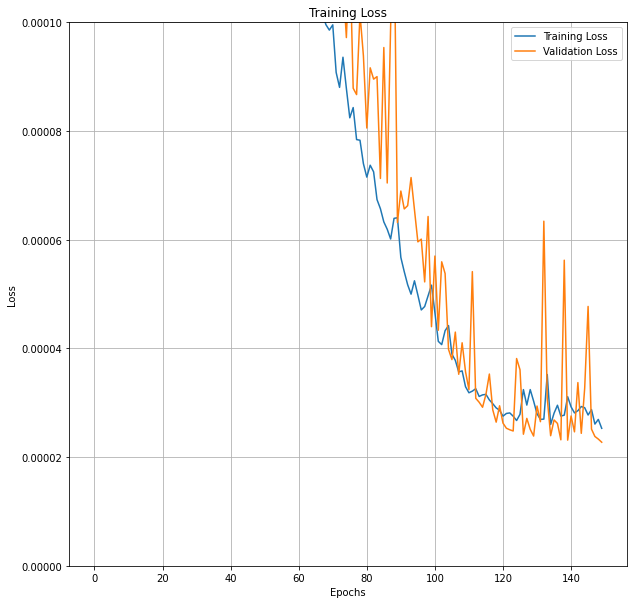

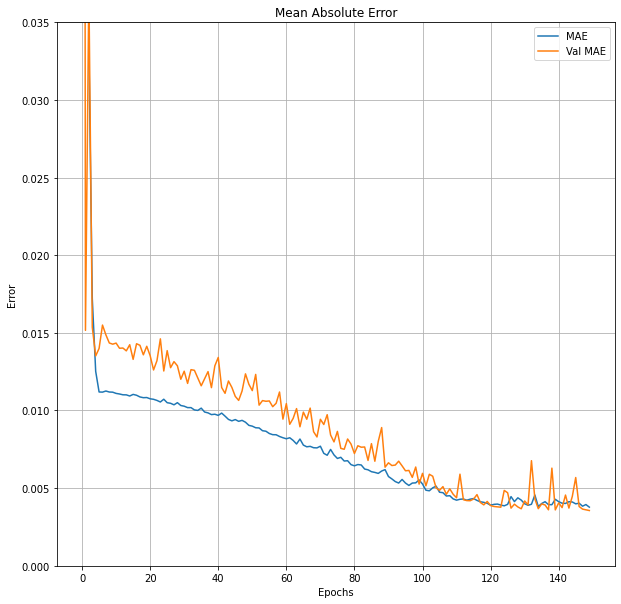

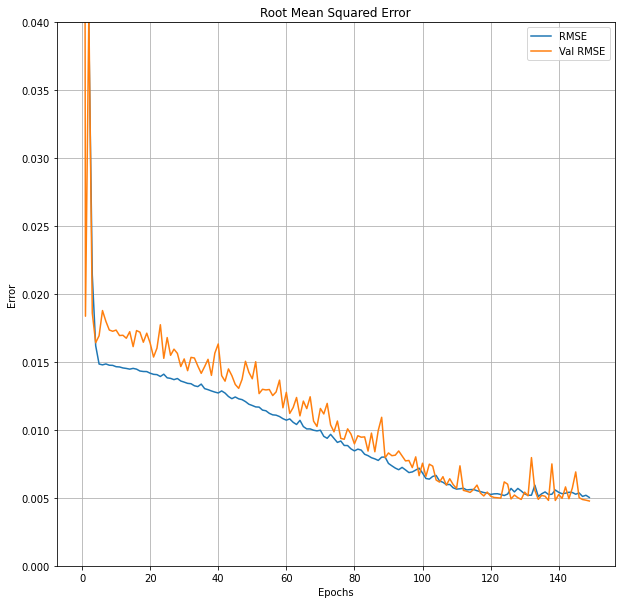

Network architecture :  N50-N50-N100-N100-E150-B64
Validation MAE   : 0.0035587004385888577
Validation RMSE  : 0.004767848178744316
8/8 [==============================] - 0s 2ms/step


In [99]:
# LSTM-Dense using M30 H4 H24
# Preparing training set
art1 = np.column_stack((predictedLSTMM30,
                        predictedLSTMH4[:len(predictedLSTMM30)],
                        predictedLSTMH24[:len(predictedLSTMM30)]))
df_train_LSTM_1 = pd.DataFrame(art1, columns=['M30', 'H4', 'H24'])

# Preparing testing set
arr1 = np.column_stack((LSTM_test_M30,
                        LSTM_test_H4,
                        LSTM_test_H24[:len(LSTM_test_M30)]))
df_test_LSTM_1 = pd.DataFrame(arr1, columns=['M30', 'H4', 'H24'])

# Retrieve best dense model
DenseLSTM_M30_H4_H24 = retrieve('M30_H4_H24', 'LSTM_Dense', plot_fig=True, loss_ylim=0.0001)

# Predict training set using best dense model
y_pred_LSTM_t1 = DenseLSTM_M30_H4_H24.predict(df_train_LSTM_1)
y_actual_LSTM_t1 = df_new_train_H24.iloc[:len(y_pred_LSTM_t1), 3]

# Predict testing set using best dense model
y_pred_LSTM_1 = DenseLSTM_M30_H4_H24.predict(df_test_LSTM_1)
y_actual_LSTM_1 = df_new_test_H24.iloc[:len(y_pred_LSTM_1), 3]

Minimum loss among all models: 4.306803020881489e-05
Minimum val_loss among all models: 3.9718634070595726e-05
Index for best model using loss: 843
Index for best model using val_loss: 727
Best model - Loss:  6.20408245595172e-05
Best model - Val_Loss:  3.9718634070595726e-05


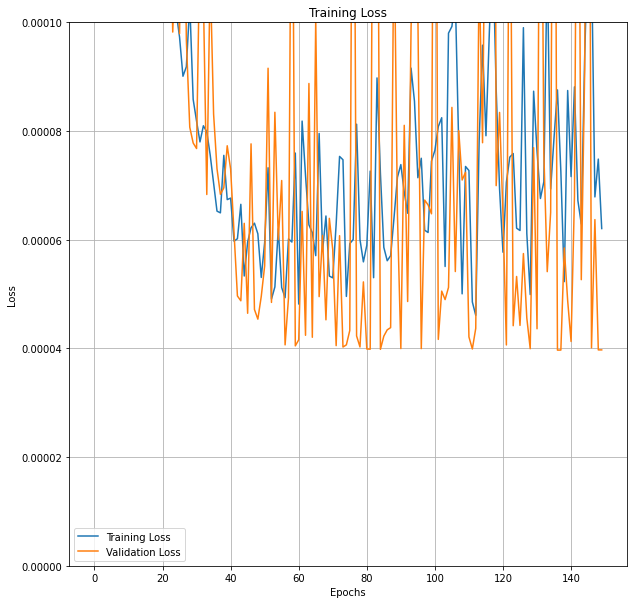

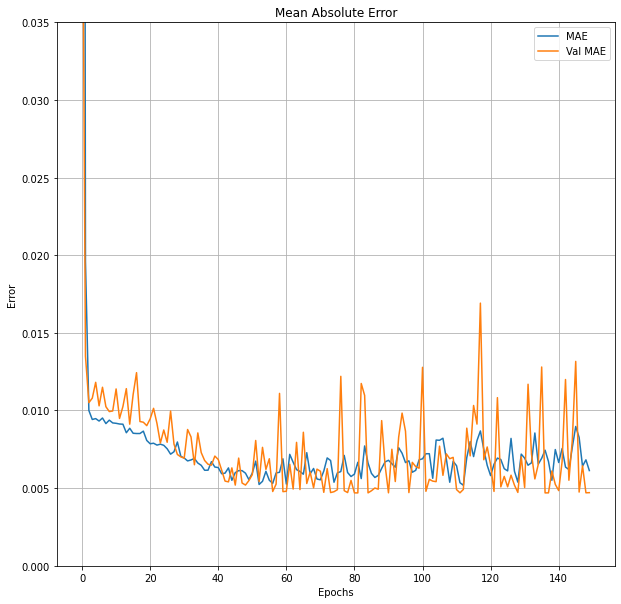

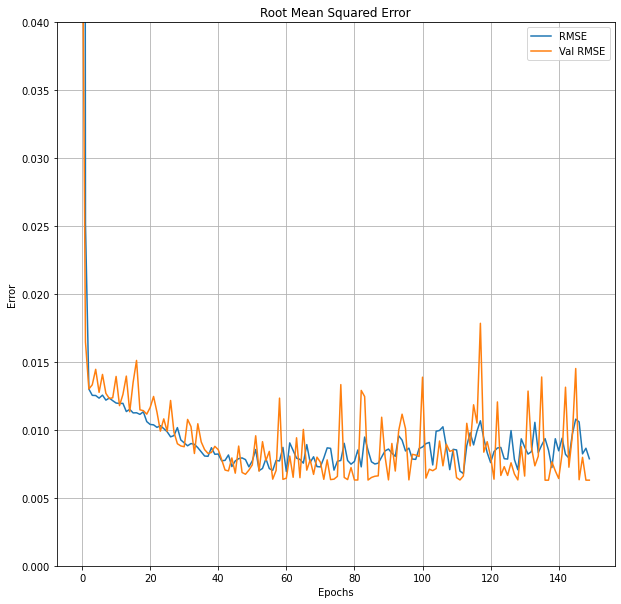

Network architecture :  N100-N150-N100-N50-E150-B32
Validation MAE   : 0.004709398373961449
Validation RMSE  : 0.006302271969616413
8/8 [==============================] - 0s 2ms/step


In [100]:
# LSTM-Dense using M30 H2 H8

# Preparing training set
art2 = np.column_stack((predictedLSTMM30,
                        predictedLSTMH2[:len(predictedLSTMM30)],
                        predictedLSTMH8[:len(predictedLSTMM30)]))
df_train_LSTM_2 = pd.DataFrame(art2, columns=['M30', 'H2', 'H8'])

# Preparing testing set
arr2 = np.column_stack((LSTM_test_M30,
                        LSTM_test_H2,
                        LSTM_test_H8[:len(LSTM_test_M30)]))
df_test_LSTM_2 = pd.DataFrame(arr2, columns=['M30', 'H2', 'H8'])

# Retrieve best dense model
DenseLSTM_M30_H2_H8 = retrieve('M30_H2_H8', 'LSTM_Dense', plot_fig=True, loss_ylim=0.0001)

# Predict training set using best dense model
y_pred_LSTM_t2 = DenseLSTM_M30_H2_H8.predict(df_train_LSTM_2)
y_actual_LSTM_t2 = df_new_train_H24.iloc[:len(y_pred_LSTM_t2), 3]

# Predict testing set using best dense model
y_pred_LSTM_2 = DenseLSTM_M30_H2_H8.predict(df_test_LSTM_2)
y_actual_LSTM_2 = df_new_test_H24.iloc[:len(y_pred_LSTM_2), 3]

Minimum loss among all models: 3.004938662343193e-05
Minimum val_loss among all models: 2.6792471544467844e-05
Index for best model using loss: 510
Index for best model using val_loss: 780
Best model - Loss:  3.062367977690883e-05
Best model - Val_Loss:  2.6792471544467844e-05


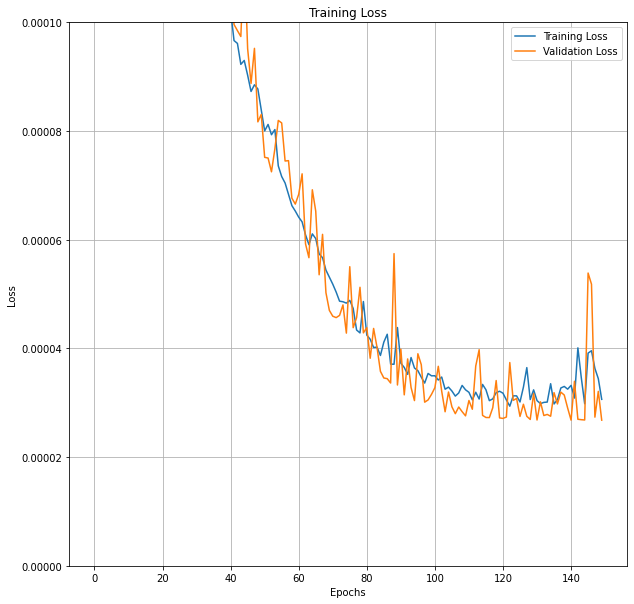

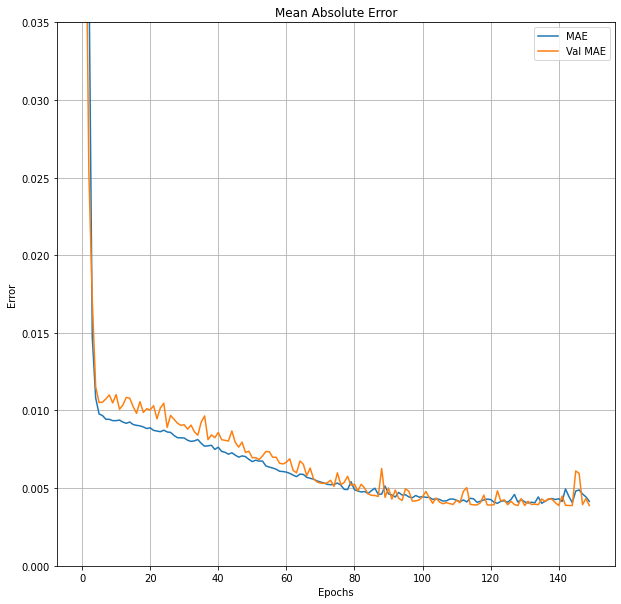

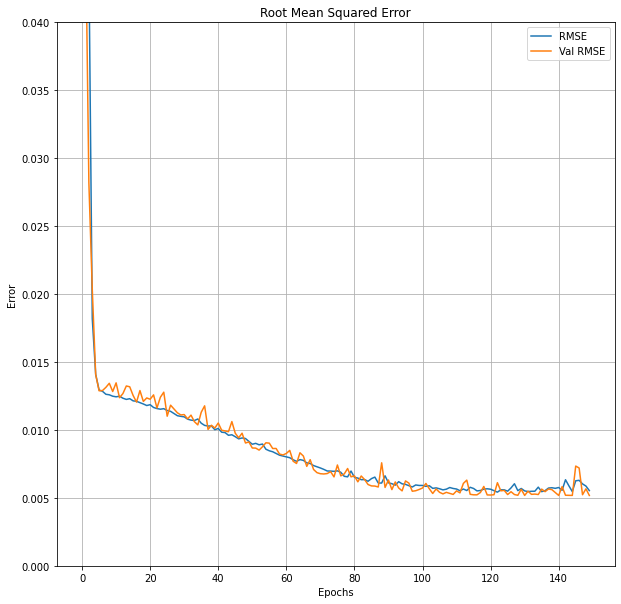

Network architecture :  N50-N150-N150-E150-B64
Validation MAE   : 0.003879726864397526
Validation RMSE  : 0.005176144652068615
8/8 [==============================] - 0s 2ms/step


In [101]:
# LSTM-Dense using H1 H6

# Preparing training set
art3 = np.column_stack((predictedLSTMH1,
                        predictedLSTMH6[:len(predictedLSTMH1)],))
df_train_LSTM_3 = pd.DataFrame(art3, columns=['H1', 'H6'])

# Preparing testing set
arr3 = np.column_stack((LSTM_test_H1,
                        LSTM_test_H6[:len(LSTM_test_H1)]))
df_test_LSTM_3 = pd.DataFrame(arr3, columns=['H1', 'H6'])

# Retrieve best dense model
DenseLSTM_H1_H6 = retrieve('H1_H6', 'LSTM_Dense', plot_fig=True, loss_ylim=0.0001)

# Predict training set using best dense model
y_pred_LSTM_t3 = DenseLSTM_H1_H6.predict(df_train_LSTM_3)
y_actual_LSTM_t3 = df_new_train_H24.iloc[:len(y_pred_LSTM_t3), 3]

# Predict testing set using best dense model
y_pred_LSTM_3 = DenseLSTM_H1_H6.predict(df_test_LSTM_3)
y_actual_LSTM_3 = df_new_test_H24.iloc[:len(y_pred_LSTM_3), 3]

Minimum loss among all models: 2.3475786292692646e-05
Minimum val_loss among all models: 2.1564717826549895e-05
Index for best model using loss: 802
Index for best model using val_loss: 780
Best model - Loss:  2.702402889553923e-05
Best model - Val_Loss:  2.1564717826549895e-05


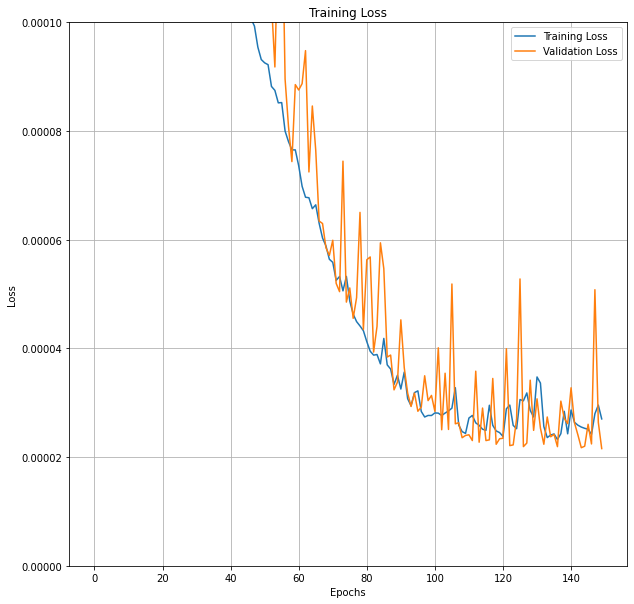

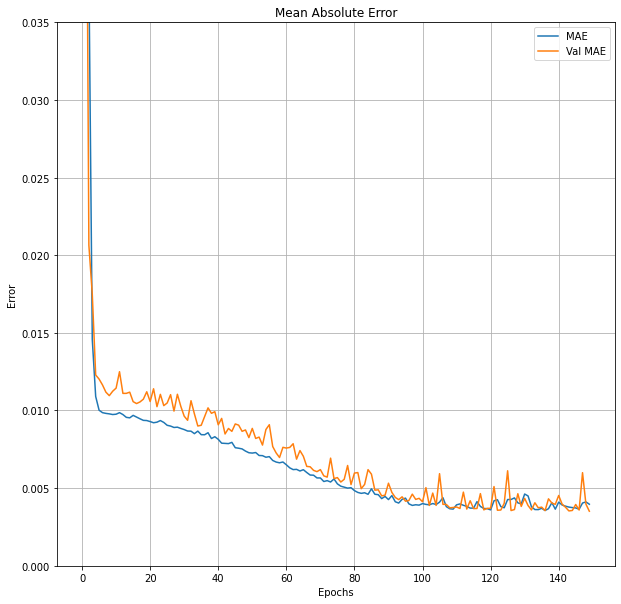

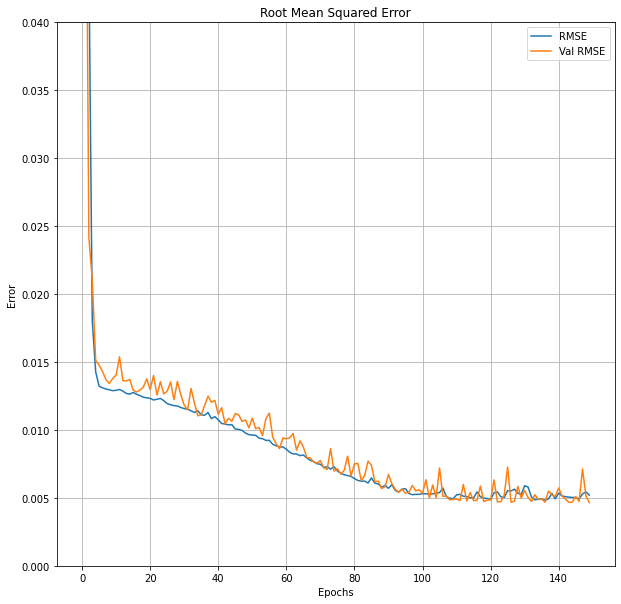

Network architecture :  N50-N150-N150-E150-B64
Validation MAE   : 0.003514401149004698
Validation RMSE  : 0.0046437825076282024
8/8 [==============================] - 0s 3ms/step


In [102]:
# LSTM-Dense using H1 H4

# Preparing training set
art4 = np.column_stack((predictedLSTMH1,
                        predictedLSTMH4[:len(predictedLSTMH1)],))
df_train_LSTM_4 = pd.DataFrame(art4, columns=['H1', 'H4'])

# Preparing testing set
arr4 = np.column_stack((LSTM_test_H1,
                        LSTM_test_H4[:len(LSTM_test_H1)]))
df_test_LSTM_4 = pd.DataFrame(arr4, columns=['H1', 'H4'])

# Retrieve best dense model
DenseLSTM_H1_H4 = retrieve('H1_H4', 'LSTM_Dense', plot_fig=True, loss_ylim=0.0001)

# Predict training set using best dense model
y_pred_LSTM_t4 = DenseLSTM_H1_H4.predict(df_train_LSTM_4)
y_actual_LSTM_t4 = df_new_train_H24.iloc[:len(y_pred_LSTM_t4), 3]

# Predict testing set using best dense model
y_pred_LSTM_4 = DenseLSTM_H1_H4.predict(df_test_LSTM_4)
y_actual_LSTM_4 = df_new_test_H24.iloc[:len(y_pred_LSTM_4), 3]

In [103]:
# Display first five rows of predicted output from the LSTM models

exampleDisplay = np.concatenate((y_pred_LSTM_1[0:5], y_pred_LSTM_2[0:5], y_pred_LSTM_3[0:5], y_pred_LSTM_4[0:5]), axis=1)
predictedDisplay = pd.DataFrame(exampleDisplay, columns = ['M30+H4+H24', 'M30+H2+H8', 'H1+H6', 'H1+H4'] )
predictedDisplay['Actual'] = df_new_test_H24.iloc[0:5, 3]
predictedDisplay

M30+H4+H24  M30+H2+H8     H1+H6     H1+H4   Actual
0    1.132653   1.132936  1.132438  1.133119  1.13247
1    1.131873   1.132448  1.131696  1.132262  1.13479
2    1.132345   1.132600  1.132099  1.133017  1.13132
3    1.132272   1.132442  1.132132  1.132874  1.13270
4    1.132341   1.132111  1.132011  1.133130  1.13085

# 5.0 Result

##5.1 Baseline H24
1. Identifying best LSTM network architecture using only H24 input.
2. Identifying best GRU network architecture using only H24 input.

Minimum loss among all models: 2.270497498102486e-05
Minimum val_loss among all models: 1.0917990948655643e-05
Index for best model using loss: 409
Index for best model using val_loss: 454
Network architecture :  N50-N100-N150-N50-E150-B32
Validation MAE   : 0.002535854000598192
Validation RMSE  : 0.0033042384311556816
8/8 [==============================] - 0s 22ms/step

Model evaluation metrics
RMSE: Training: 0.0034256386535558105, Testing: 0.0022926840637618215
MAE: Training: 0.002601689374373827, Testing: 0.0017870891459984106


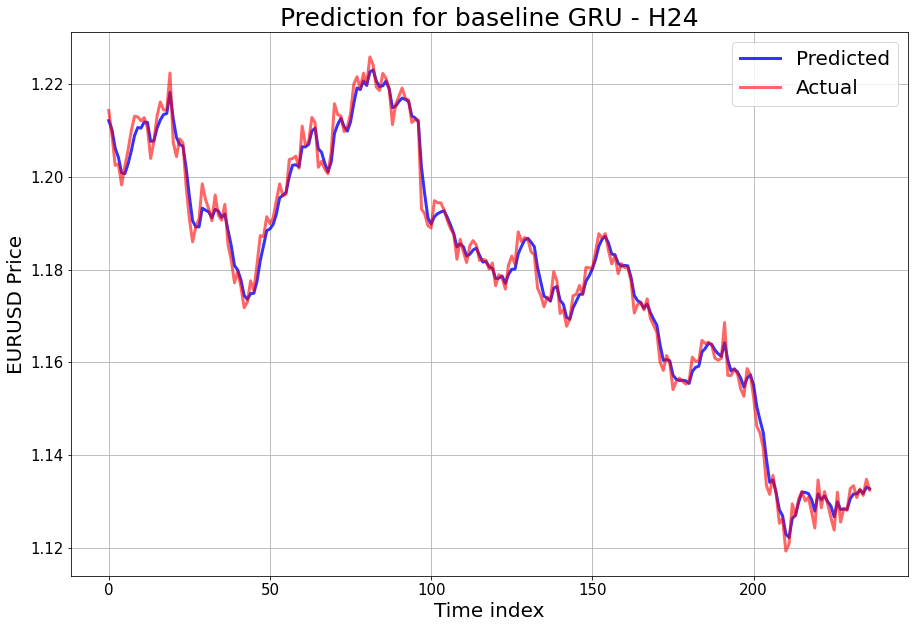

In [104]:
# GRU Baseline

# Retrieving best performing model
string_timeframe = 'H24'
string_model = 'GRU'
model_loaded = retrieve(string_timeframe, string_model)

# Loaded model inference and computing evaluation metrics
X_train = train_H24 # Change this
X_test = test_H24 # Change this
y_train = df_new_train_H24.iloc[:len(X_train), -1] # Fixed
y_test = df_new_test_H24.iloc[:len(X_test), -1] # Fixed

# Model inference
y_pred_train = model_loaded.predict(X_train)
y_pred_test_GRU = model_loaded.predict(X_test)

# Model evaluation training set
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Model evaluation testing set
rmse_test = mean_squared_error(y_test, y_pred_test_GRU, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test_GRU)

print('\nModel evaluation metrics')
print(f'RMSE: Training: {rmse_train}, Testing: {rmse_test}')
print(f'MAE: Training: {mae_train}, Testing: {mae_test}')

x_plot = range(0, len(y_pred_test_GRU))
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_test_GRU[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for baseline GRU - H24', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend(prop={'size': 20})

Slightly better prediction on the sideways, but still not acceptable

Minimum loss among all models: 6.67003114358522e-05
Minimum val_loss among all models: 5.300086922943592e-05
Index for best model using loss: 101
Index for best model using val_loss: 96
Network architecture :  N50-N100-N150-N150-E150-B32
Validation MAE   : 0.005651539191603661
Validation RMSE  : 0.007280169520527124
8/8 [==============================] - 0s 37ms/step

Model evaluation metrics
RMSE: Training: 0.00763510282831284, Testing: 0.004906465313083648
MAE: Training: 0.006014493492378181, Testing: 0.003955064037661013


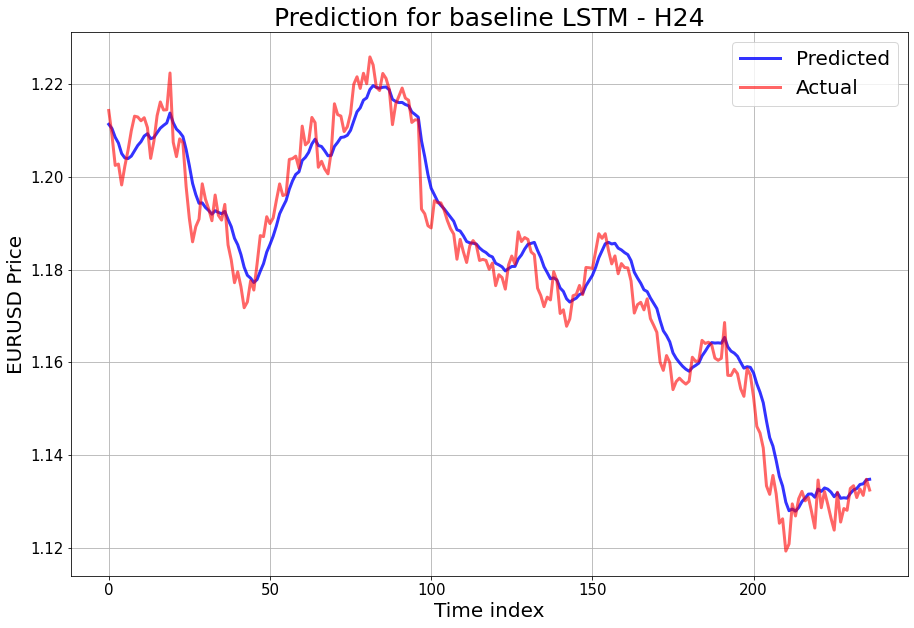

In [105]:
# LSTM Baseline

# Retrieving best performing model
string_timeframe = 'H24'
string_model = 'LSTM'
model_loaded = retrieve(string_timeframe, string_model)

# Loaded model inference and computing evaluation metrics
X_train = train_H24 # Change this
X_test = test_H24 # Change this
y_train = df_new_train_H24.iloc[:len(X_train), -1] # Fixed
y_test = df_new_test_H24.iloc[:len(X_test), -1] # Fixed

# Model inference
y_pred_train = model_loaded.predict(X_train)
y_pred_test_LSTM = model_loaded.predict(X_test)

# Model evaluation training set
rmse_train = mean_squared_error(y_train, y_pred_train, squared=False)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Model evaluation testing set
rmse_test = mean_squared_error(y_test, y_pred_test_LSTM, squared=False)
mae_test = mean_absolute_error(y_test, y_pred_test_LSTM)

print('\nModel evaluation metrics')
print(f'RMSE: Training: {rmse_train}, Testing: {rmse_test}')
print(f'MAE: Training: {mae_train}, Testing: {mae_test}')

x_plot = range(0, len(y_pred_test_LSTM))
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_test_LSTM[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for baseline LSTM - H24', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend(prop={'size': 20})

LSTM were only able to predict the trend, but not the small sideways.

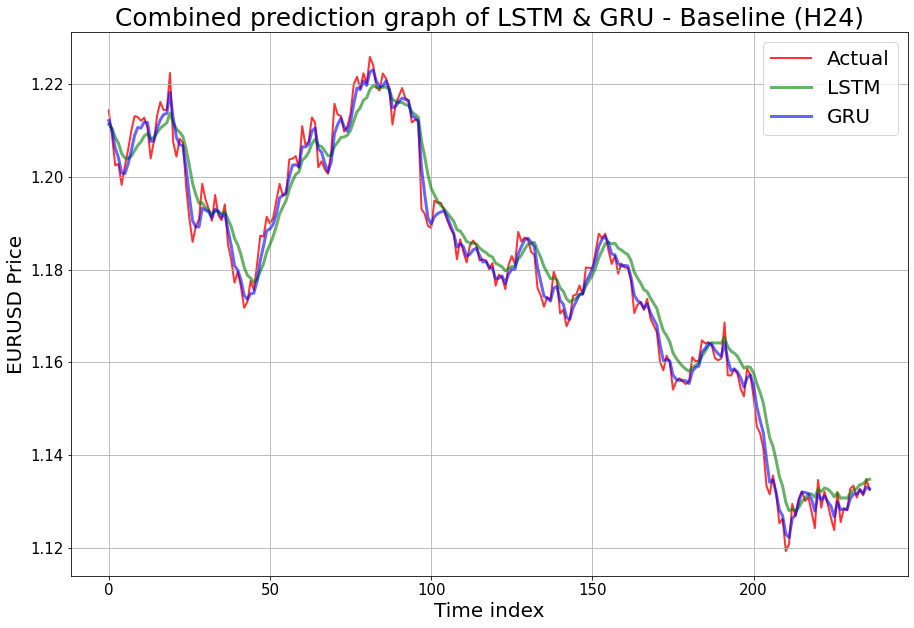

In [106]:
y_test = y_test[:len(y_pred_test_GRU)]
# Combined Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.8, linewidth=2, zorder=0)
plt.plot(x_plot, y_pred_test_LSTM[::-1], 'g', label='LSTM', alpha=0.6, linewidth=3, zorder=50)
plt.plot(x_plot, y_pred_test_GRU[::-1], 'b', label='GRU', alpha=0.6, linewidth=3, zorder=100)
plt.title('Combined prediction graph of LSTM & GRU - Baseline (H24)', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

##5.2 Experiment 1 - M30 + H4 + H24
1. Identifying best LSTM-Dense network architecture using M30, H4 & H24 input.
2. Identifying best GRU-Dense network architecture using M30, H4 & H24 input.


GRU Model evaluation metrics using M30 H4 H24
RMSE: Training: 0.002959625864358356, Testing: 0.0021395169693351236
MAE : Training: 0.0021588092277934736, Testing: 0.0016515741602040998

LSTM Model evaluation metrics using M30 H4 H24
RMSE: Training: 0.004946773283188126, Testing: 0.003662094471402281
MAE : Training: 0.003693135139567297, Testing: 0.002835263027094184


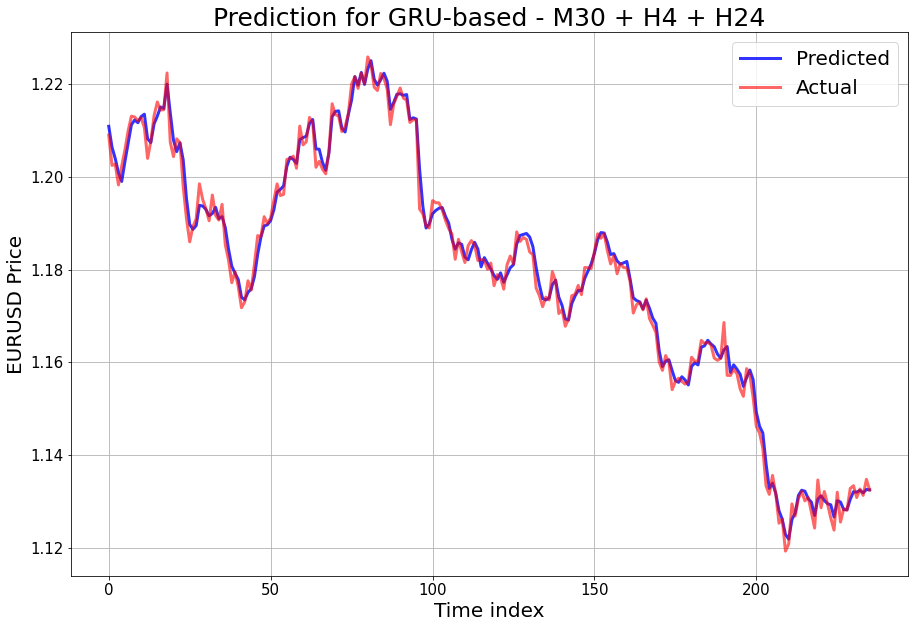

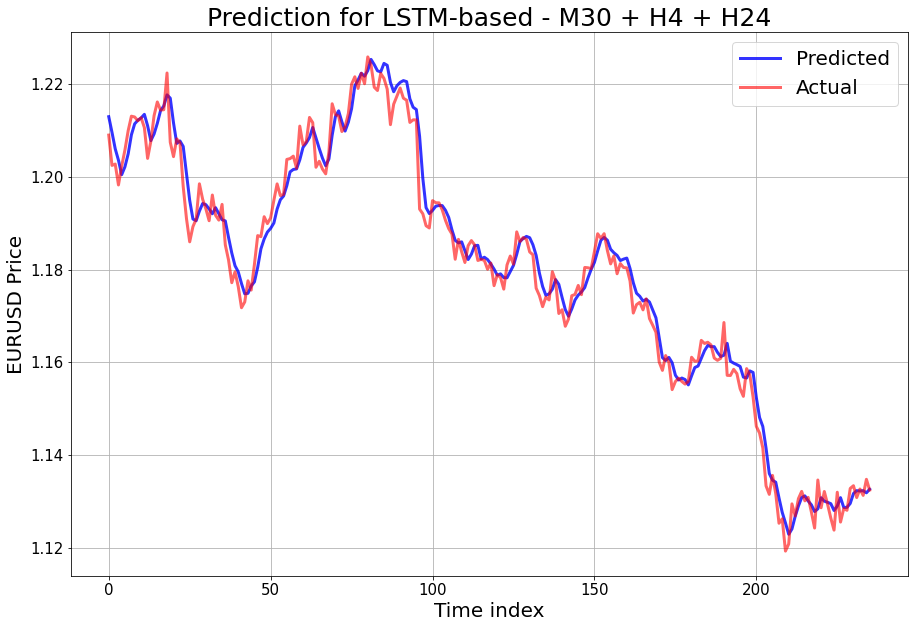

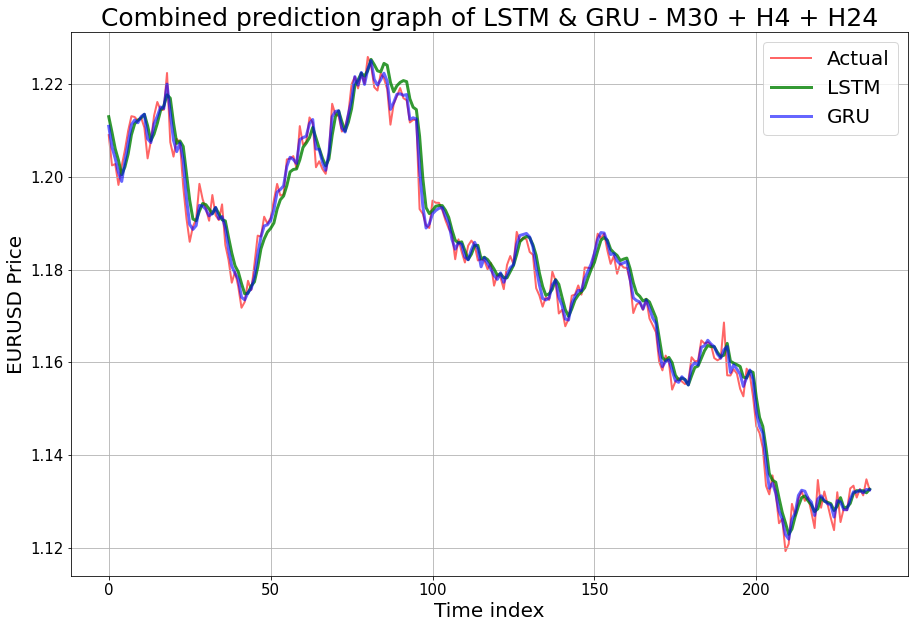

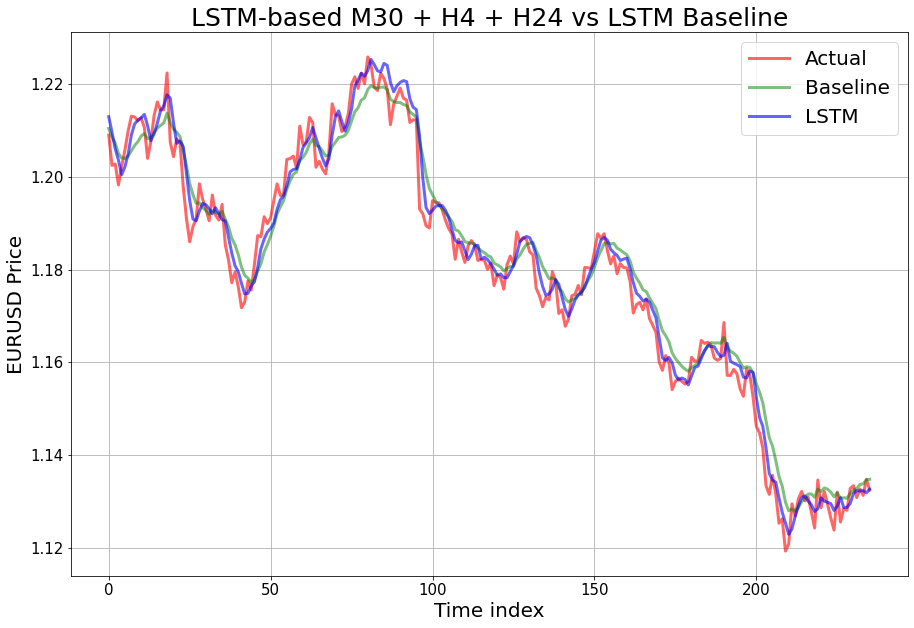

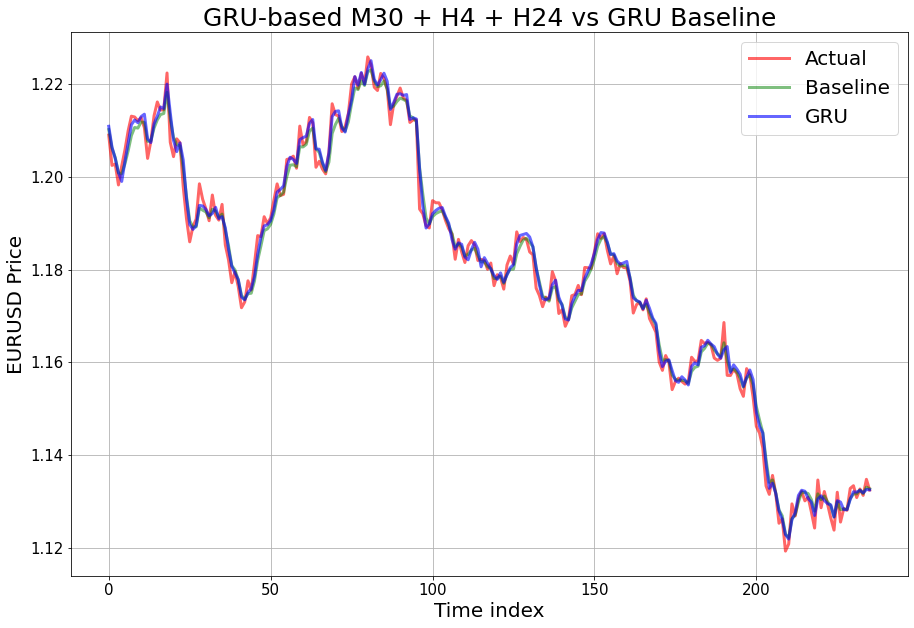

In [123]:
# GRU
# Training Set
GRU_rmse_t1 = mean_squared_error(y_pred_GRU_t1, y_actual_GRU_t1, squared=False)
GRU_mae_t1 = mean_absolute_error(y_pred_GRU_t1, y_actual_GRU_t1) 
# Testing Set
GRU_rmse_1 = mean_squared_error(y_pred_GRU_1, y_actual_GRU_1, squared=False)
GRU_mae_1 = mean_absolute_error(y_pred_GRU_1, y_actual_GRU_1)

print('\nGRU Model evaluation metrics using M30 H4 H24')
print(f'RMSE: Training: {GRU_rmse_t1}, Testing: {GRU_rmse_1}')
print(f'MAE : Training: {GRU_mae_t1}, Testing: {GRU_mae_1}')

# LSTM
# Training Set
LSTM_rmse_t1 = mean_squared_error(y_pred_LSTM_t1, y_actual_LSTM_t1, squared=False)
LSTM_mae_t1 = mean_absolute_error(y_pred_LSTM_t1, y_actual_LSTM_t1)
# Testing Set
LSTM_rmse_1 = mean_squared_error(y_pred_LSTM_1, y_actual_LSTM_1, squared=False)
LSTM_mae_1 = mean_absolute_error(y_pred_LSTM_1, y_actual_LSTM_1)

print('\nLSTM Model evaluation metrics using M30 H4 H24')
print(f'RMSE: Training: {LSTM_rmse_t1}, Testing: {LSTM_rmse_1}')
print(f'MAE : Training: {LSTM_mae_t1}, Testing: {LSTM_mae_1}')

x_plot = range(0, len(y_pred_GRU_1))
# GRU Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_GRU_1[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_actual_GRU_1[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for GRU-based - M30 + H4 + H24', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# LSTM Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_LSTM_1[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_actual_LSTM_1[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for LSTM-based - M30 + H4 + H24', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

y_test = y_test[:len(y_pred_GRU_1)]
# Combined Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=2, zorder=0)
plt.plot(x_plot, y_pred_LSTM_1[::-1], 'g', label='LSTM', alpha=0.8, linewidth=3, zorder=50)
plt.plot(x_plot, y_pred_GRU_1[::-1], 'b', label='GRU', alpha=0.6, linewidth=3, zorder=100)
plt.title('Combined prediction graph of LSTM & GRU - M30 + H4 + H24', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# Baseline versus LSTM
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.plot(x_plot, y_pred_test_LSTM[::-1], 'g', label='Baseline', alpha=0.5, linewidth=3)
plt.plot(x_plot, y_pred_LSTM_1[::-1], 'b', label='LSTM', alpha=0.6, linewidth=3)
plt.title('LSTM-based M30 + H4 + H24 vs LSTM Baseline', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# Baseline versus GRU
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.plot(x_plot, y_pred_test_GRU[::-1], 'g', label='Baseline', alpha=0.5, linewidth=3)
plt.plot(x_plot, y_pred_GRU_1[::-1], 'b', label='GRU', alpha=0.6, linewidth=3)
plt.title('GRU-based M30 + H4 + H24 vs GRU Baseline', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

##5.3 Experiment 2 - M30 + H2 + H8
1. Identifying best LSTM-Dense network architecture using M30, H2 & H8 input.
2. Identifying best GRU-Dense network architecture using M30, H2 & H8 input.


GRU Model evaluation metrics using M30 H2 H8
RMSE: Training: 0.003001789320867259, Testing: 0.0023714579736686275
MAE : Training: 0.002161393264044759, Testing: 0.001844585841389033

LSTM Model evaluation metrics using M30 H2 H8
RMSE: Training: 0.006419076640037734, Testing: 0.0042492627445579936
MAE : Training: 0.00484941667496783, Testing: 0.0033935331587064137


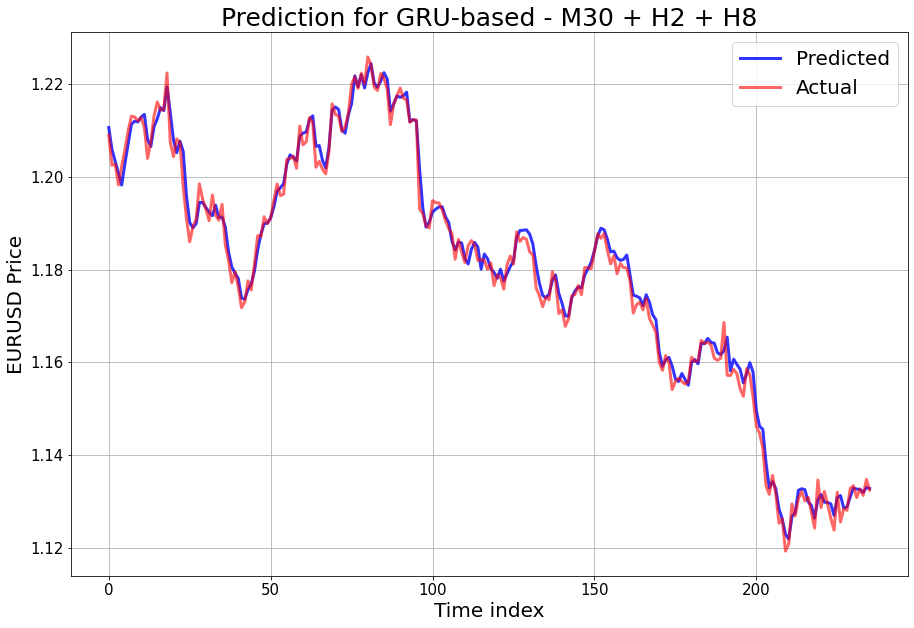

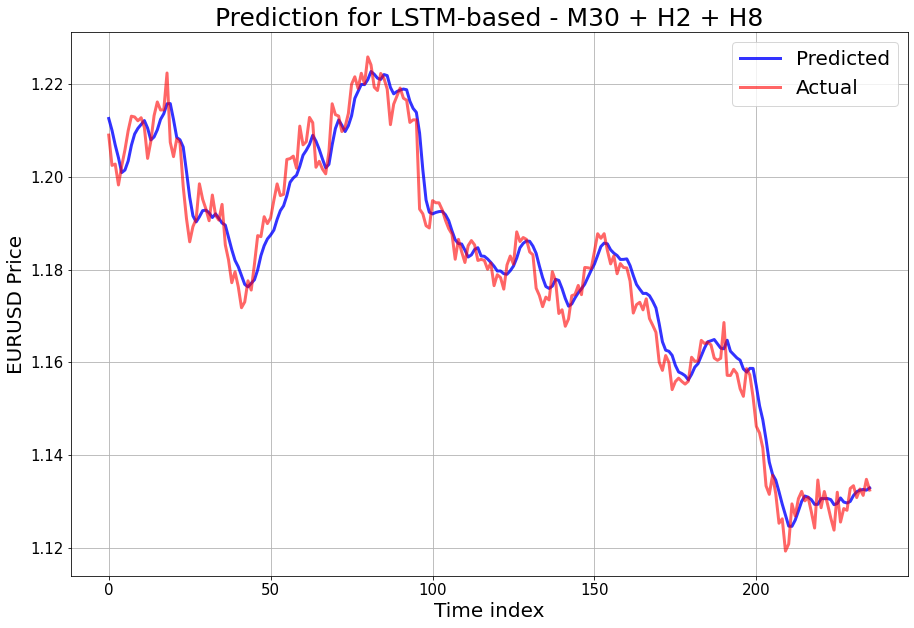

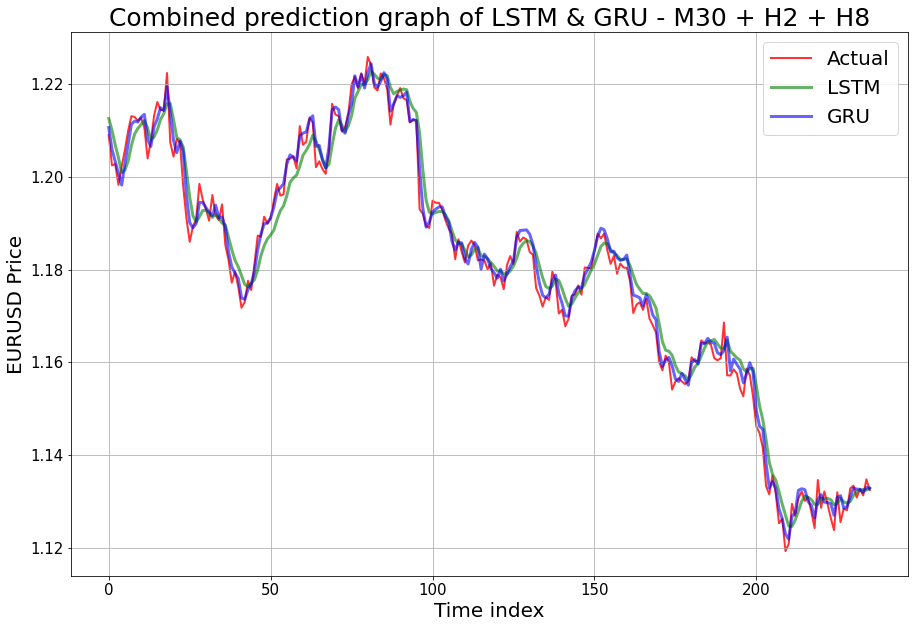

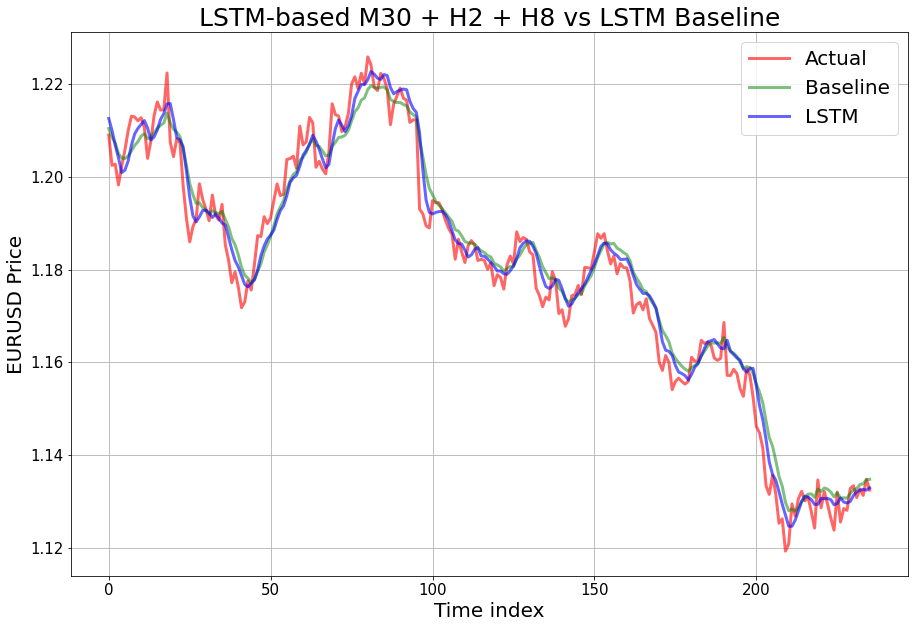

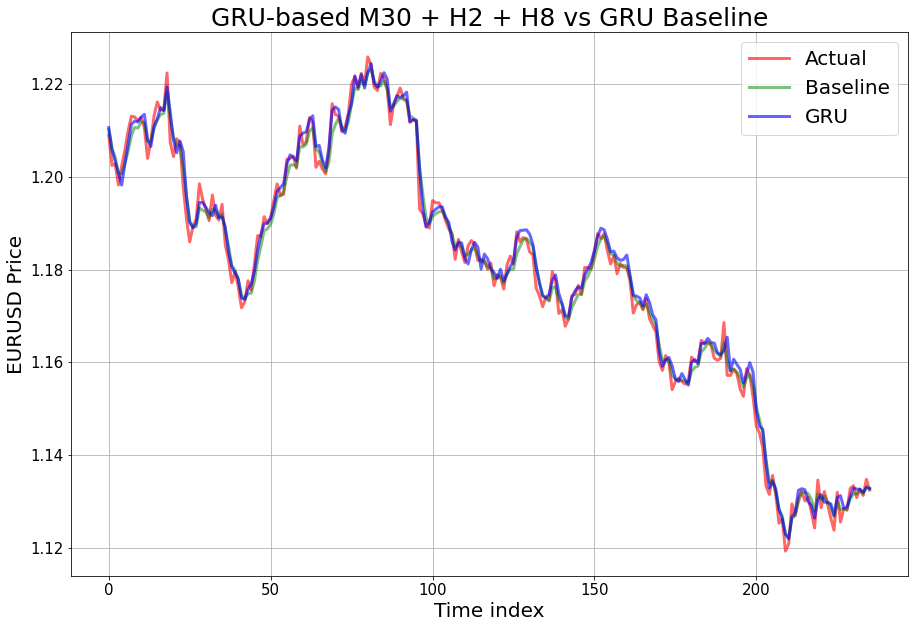

In [124]:
# GRU
# Training Set
GRU_rmse_t2 = mean_squared_error(y_pred_GRU_t2, y_actual_GRU_t2, squared=False)
GRU_mae_t2 = mean_absolute_error(y_pred_GRU_t2, y_actual_GRU_t2) 
# Testing Set
GRU_rmse_2 = mean_squared_error(y_pred_GRU_2, y_actual_GRU_2, squared=False)
GRU_mae_2 = mean_absolute_error(y_pred_GRU_2, y_actual_GRU_2)

print('\nGRU Model evaluation metrics using M30 H2 H8')
print(f'RMSE: Training: {GRU_rmse_t2}, Testing: {GRU_rmse_2}')
print(f'MAE : Training: {GRU_mae_t2}, Testing: {GRU_mae_2}')

# LSTM
# Training Set
LSTM_rmse_t2 = mean_squared_error(y_pred_LSTM_t2, y_actual_LSTM_t2, squared=False)
LSTM_mae_t2 = mean_absolute_error(y_pred_LSTM_t2, y_actual_LSTM_t2)
# Testing Set
LSTM_rmse_2 = mean_squared_error(y_pred_LSTM_2, y_actual_LSTM_2, squared=False)
LSTM_mae_2 = mean_absolute_error(y_pred_LSTM_2, y_actual_LSTM_2)

print('\nLSTM Model evaluation metrics using M30 H2 H8')
print(f'RMSE: Training: {LSTM_rmse_t2}, Testing: {LSTM_rmse_2}')
print(f'MAE : Training: {LSTM_mae_t2}, Testing: {LSTM_mae_2}')

x_plot = range(0, len(y_pred_GRU_2))
# GRU Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_GRU_2[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_actual_GRU_2[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for GRU-based - M30 + H2 + H8', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend(prop={'size': 20})

# LSTM Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_LSTM_2[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_actual_LSTM_2[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for LSTM-based - M30 + H2 + H8', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend(prop={'size': 20})

y_test = y_test[:len(y_pred_GRU_2)]
# Combined Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.8, linewidth=2, zorder=0)
plt.plot(x_plot, y_pred_LSTM_2[::-1], 'g', label='LSTM', alpha=0.6, linewidth=3, zorder=50)
plt.plot(x_plot, y_pred_GRU_2[::-1], 'b', label='GRU', alpha=0.6, linewidth=3, zorder=100)
plt.title('Combined prediction graph of LSTM & GRU - M30 + H2 + H8', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# Baseline versus LSTM
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.plot(x_plot, y_pred_test_LSTM[::-1], 'g', label='Baseline', alpha=0.5, linewidth=3)
plt.plot(x_plot, y_pred_LSTM_2[::-1], 'b', label='LSTM', alpha=0.6, linewidth=3)
plt.title('LSTM-based M30 + H2 + H8 vs LSTM Baseline', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# Baseline versus GRU
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.plot(x_plot, y_pred_test_GRU[::-1], 'g', label='Baseline', alpha=0.5, linewidth=3)
plt.plot(x_plot, y_pred_GRU_2[::-1], 'b', label='GRU', alpha=0.6, linewidth=3)
plt.title('GRU-based M30 + H2 + H8 vs GRU Baseline', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

##5.4 Experiment 3 - H1 + H6
1. Identifying best LSTM-Dense network architecture using H1 & H6 input.
2. Identifying best GRU-Dense network architecture using H1 & H6 input.


GRU Model evaluation metrics using H1 H6
RMSE: Training: 0.0024055831061318258, Testing: 0.001918232056144553
MAE : Training: 0.0016748920998483348, Testing: 0.0014392447353621682

LSTM Model evaluation metrics using H1 H6
RMSE: Training: 0.005379020875204944, Testing: 0.0037245024316201586
MAE : Training: 0.003982042920874351, Testing: 0.0028454796176845785


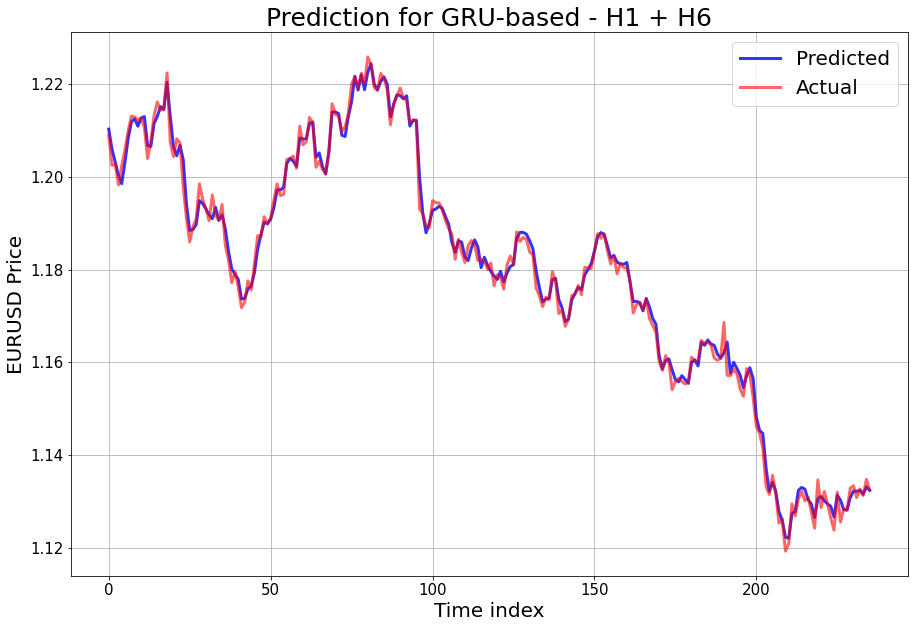

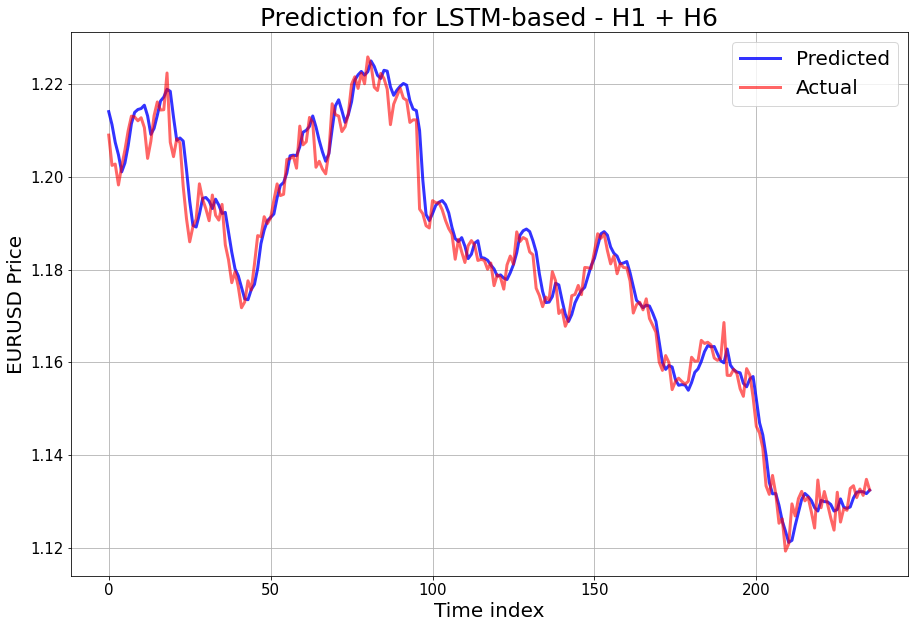

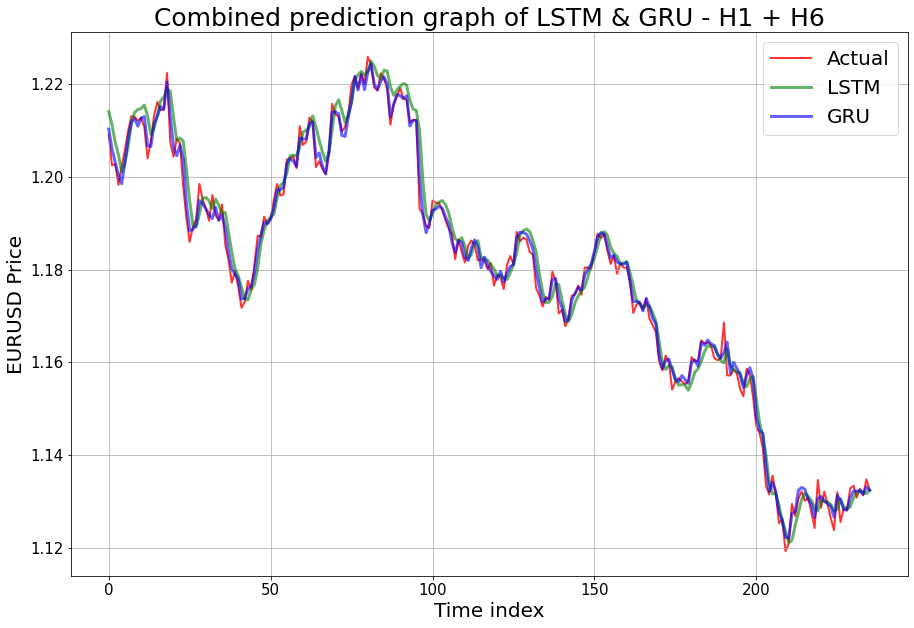

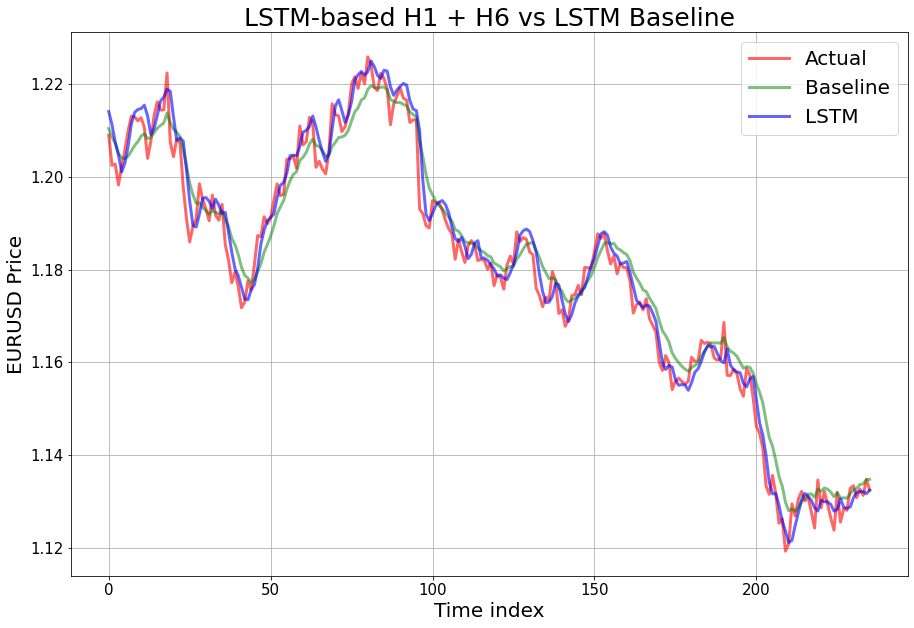

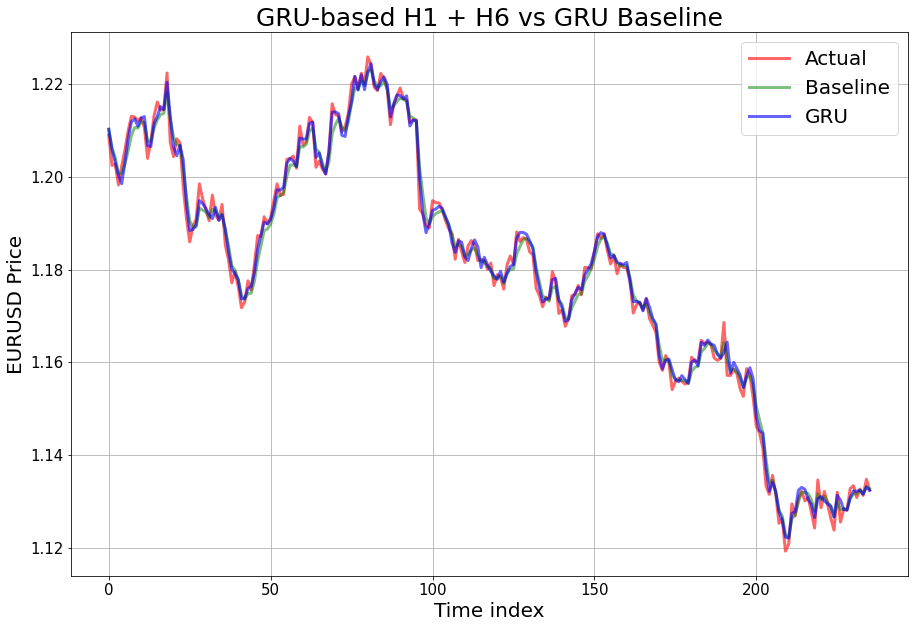

In [125]:
# GRU
# Training Set
GRU_rmse_t3 = mean_squared_error(y_pred_GRU_t3, y_actual_GRU_t3, squared=False)
GRU_mae_t3 = mean_absolute_error(y_pred_GRU_t3, y_actual_GRU_t3) 
# Testing Set
GRU_rmse_3 = mean_squared_error(y_pred_GRU_3, y_actual_GRU_3, squared=False)
GRU_mae_3 = mean_absolute_error(y_pred_GRU_3, y_actual_GRU_3)

print('\nGRU Model evaluation metrics using H1 H6')
print(f'RMSE: Training: {GRU_rmse_t3}, Testing: {GRU_rmse_3}')
print(f'MAE : Training: {GRU_mae_t3}, Testing: {GRU_mae_3}')

# LSTM
# Training Set
LSTM_rmse_t3 = mean_squared_error(y_pred_LSTM_t3, y_actual_LSTM_t3, squared=False)
LSTM_mae_t3 = mean_absolute_error(y_pred_LSTM_t3, y_actual_LSTM_t3)
# Testing Set
LSTM_rmse_3 = mean_squared_error(y_pred_LSTM_3, y_actual_LSTM_3, squared=False)
LSTM_mae_3 = mean_absolute_error(y_pred_LSTM_3, y_actual_LSTM_3)

print('\nLSTM Model evaluation metrics using H1 H6')
print(f'RMSE: Training: {LSTM_rmse_t3}, Testing: {LSTM_rmse_3}')
print(f'MAE : Training: {LSTM_mae_t3}, Testing: {LSTM_mae_3}')

x_plot = range(0, len(y_pred_GRU_3))
# GRU Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_GRU_3[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_actual_GRU_3[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for GRU-based - H1 + H6', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend(prop={'size': 20})

# LSTM Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_LSTM_3[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_actual_LSTM_3[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for LSTM-based - H1 + H6', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend(prop={'size': 20})

y_test = y_test[:len(y_pred_GRU_3)]
# Combined Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.8, linewidth=2, zorder=0)
plt.plot(x_plot, y_pred_LSTM_3[::-1], 'g', label='LSTM', alpha=0.6, linewidth=3, zorder=50)
plt.plot(x_plot, y_pred_GRU_3[::-1], 'b', label='GRU', alpha=0.6, linewidth=3, zorder=100)
plt.title('Combined prediction graph of LSTM & GRU - H1 + H6', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# Baseline versus LSTM
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.plot(x_plot, y_pred_test_LSTM[::-1], 'g', label='Baseline', alpha=0.5, linewidth=3)
plt.plot(x_plot, y_pred_LSTM_3[::-1], 'b', label='LSTM', alpha=0.6, linewidth=3)
plt.title('LSTM-based H1 + H6 vs LSTM Baseline', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# Baseline versus GRU
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.plot(x_plot, y_pred_test_GRU[::-1], 'g', label='Baseline', alpha=0.5, linewidth=3)
plt.plot(x_plot, y_pred_GRU_3[::-1], 'b', label='GRU', alpha=0.6, linewidth=3)
plt.title('GRU-based H1 + H6 vs GRU Baseline', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

##5.5 Experiment 4 - H1 + H4
1. Identifying best LSTM-Dense network architecture using H1 & H4 input.
2. Identifying best GRU-Dense network architecture using H1 & H4 input.


GRU Model evaluation metrics using H1 H4
RMSE: Training: 0.002373690817302649, Testing: 0.0019268566104304662
MAE : Training: 0.0016600142693069776, Testing: 0.001461902747719979

LSTM Model evaluation metrics using H1 H4
RMSE: Training: 0.00490573556737577, Testing: 0.003618801865622472
MAE : Training: 0.0036832650234114458, Testing: 0.002789781882884144


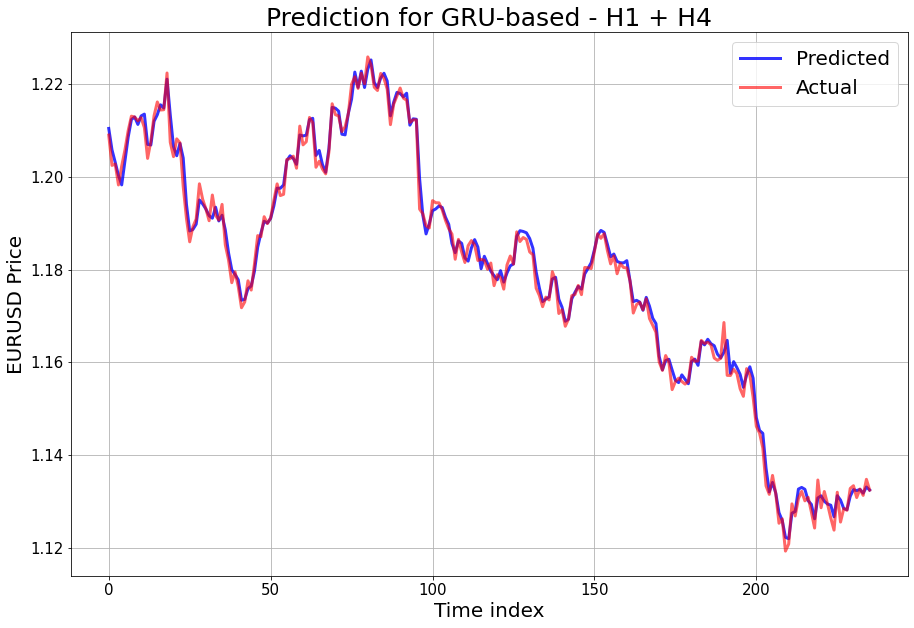

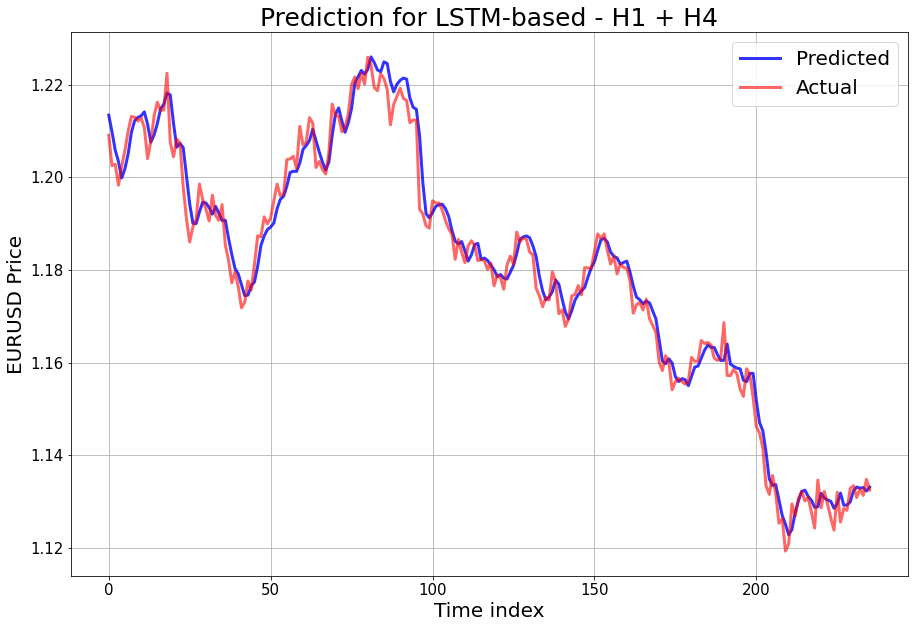

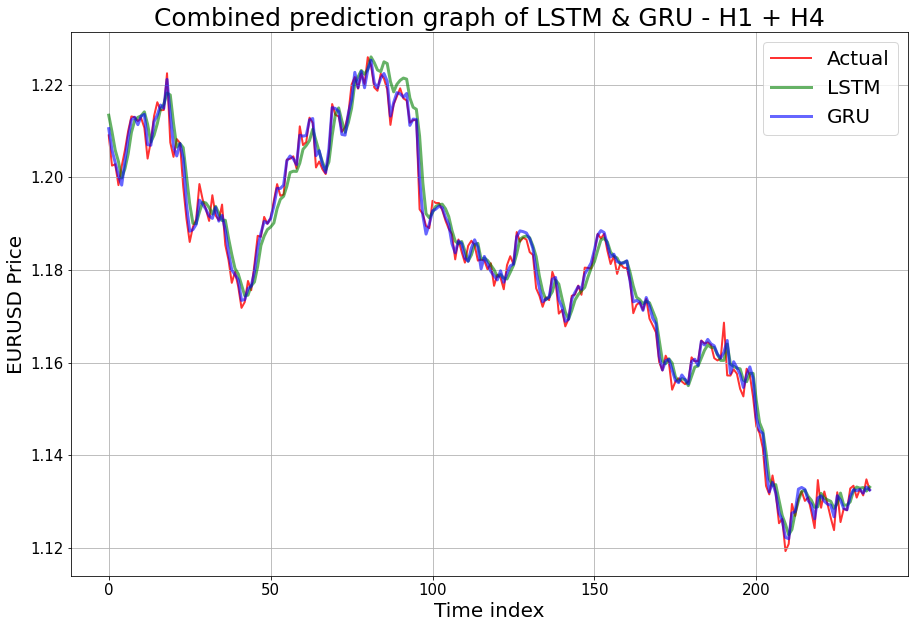

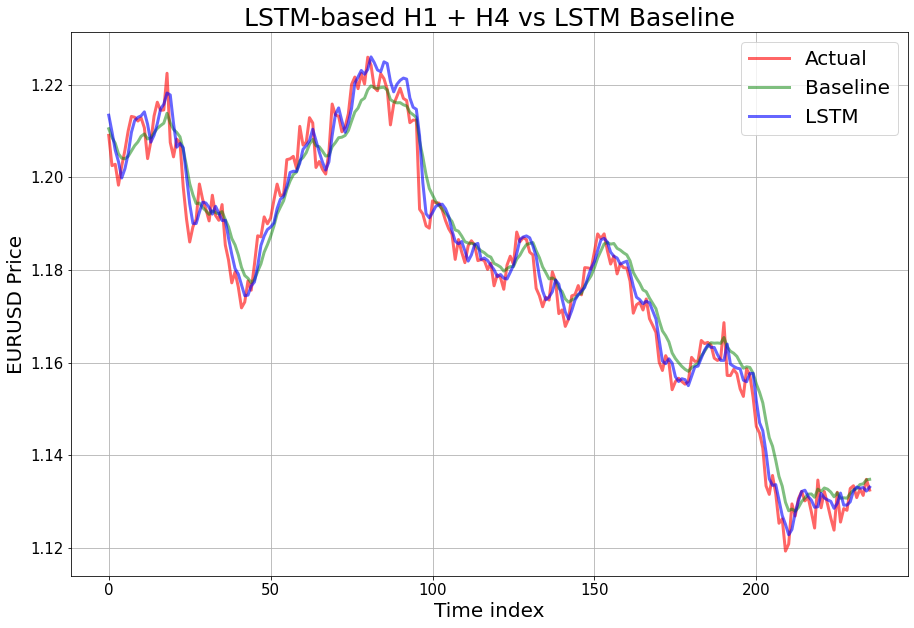

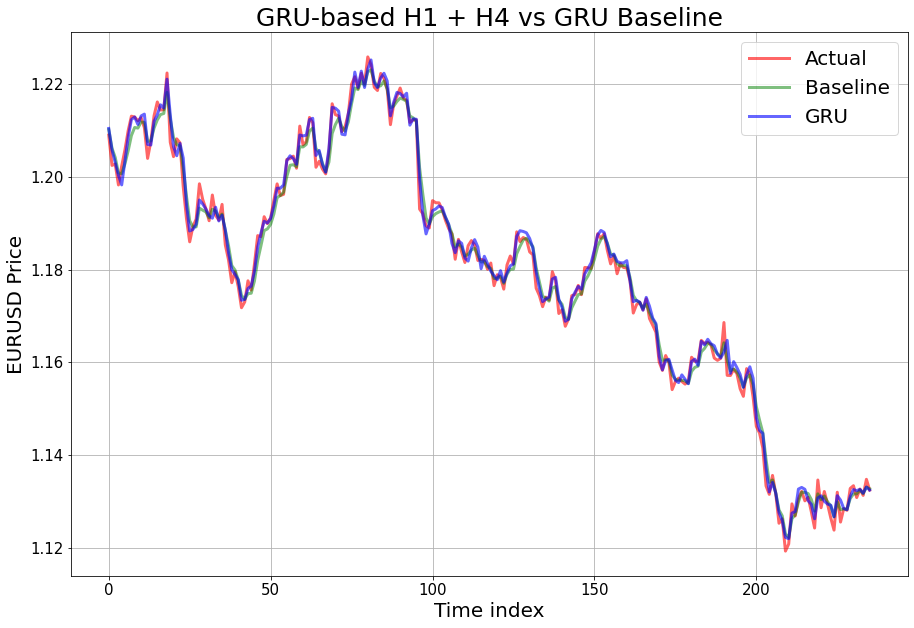

In [126]:
# GRU
# Training Set
GRU_rmse_t4 = mean_squared_error(y_pred_GRU_t4, y_actual_GRU_t4, squared=False)
GRU_mae_t4 = mean_absolute_error(y_pred_GRU_t4, y_actual_GRU_t4) 
# Testing Set
GRU_rmse_4 = mean_squared_error(y_pred_GRU_4, y_actual_GRU_4, squared=False)
GRU_mae_4 = mean_absolute_error(y_pred_GRU_4, y_actual_GRU_4)

print('\nGRU Model evaluation metrics using H1 H4')
print(f'RMSE: Training: {GRU_rmse_t4}, Testing: {GRU_rmse_4}')
print(f'MAE : Training: {GRU_mae_t4}, Testing: {GRU_mae_4}')

# LSTM
# Training Set
LSTM_rmse_t4 = mean_squared_error(y_pred_LSTM_t4, y_actual_LSTM_t4, squared=False)
LSTM_mae_t4 = mean_absolute_error(y_pred_LSTM_t4, y_actual_LSTM_t4)
# Testing Set
LSTM_rmse_4 = mean_squared_error(y_pred_LSTM_4, y_actual_LSTM_4, squared=False)
LSTM_mae_4 = mean_absolute_error(y_pred_LSTM_4, y_actual_LSTM_4)

print('\nLSTM Model evaluation metrics using H1 H4')
print(f'RMSE: Training: {LSTM_rmse_t4}, Testing: {LSTM_rmse_4}')
print(f'MAE : Training: {LSTM_mae_t4}, Testing: {LSTM_mae_4}')

x_plot = range(0, len(y_pred_GRU_4))
# GRU Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_GRU_4[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_actual_GRU_4[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for GRU-based - H1 + H4', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend(prop={'size': 20})

# LSTM Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_LSTM_4[::-1], 'b', label='Predicted', alpha=0.8, linewidth=3)
plt.plot(x_plot, y_actual_LSTM_4[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.title('Prediction for LSTM-based - H1 + H4', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid(True)
plt.legend(prop={'size': 20})

y_test = y_test[:len(y_pred_GRU_4)]
# Combined Plot
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.8, linewidth=2, zorder=0)
plt.plot(x_plot, y_pred_LSTM_4[::-1], 'g', label='LSTM', alpha=0.6, linewidth=3, zorder=50)
plt.plot(x_plot, y_pred_GRU_4[::-1], 'b', label='GRU', alpha=0.6, linewidth=3, zorder=100)
plt.title('Combined prediction graph of LSTM & GRU - H1 + H4', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# Baseline versus LSTM
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.plot(x_plot, y_pred_test_LSTM[::-1], 'g', label='Baseline', alpha=0.5, linewidth=3)
plt.plot(x_plot, y_pred_LSTM_4[::-1], 'b', label='LSTM', alpha=0.6, linewidth=3)
plt.title('LSTM-based H1 + H4 vs LSTM Baseline', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

# Baseline versus GRU
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual', alpha=0.6, linewidth=3)
plt.plot(x_plot, y_pred_test_GRU[::-1], 'g', label='Baseline', alpha=0.5, linewidth=3)
plt.plot(x_plot, y_pred_GRU_4[::-1], 'b', label='GRU', alpha=0.6, linewidth=3)
plt.title('GRU-based H1 + H4 vs GRU Baseline', fontsize=25)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('EURUSD Price', fontsize=20)
plt.grid(True)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(prop={'size': 20})

## Baseline vs Model predictions plot

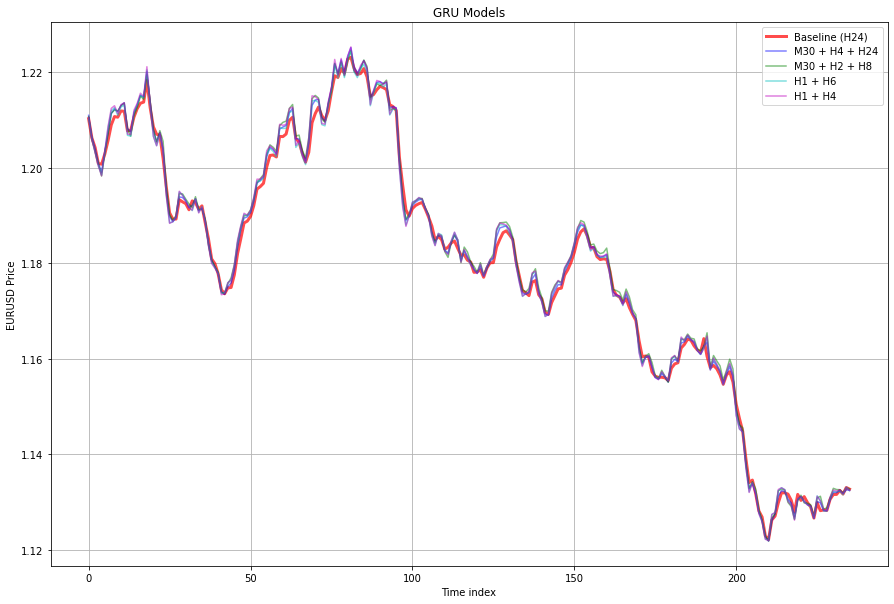

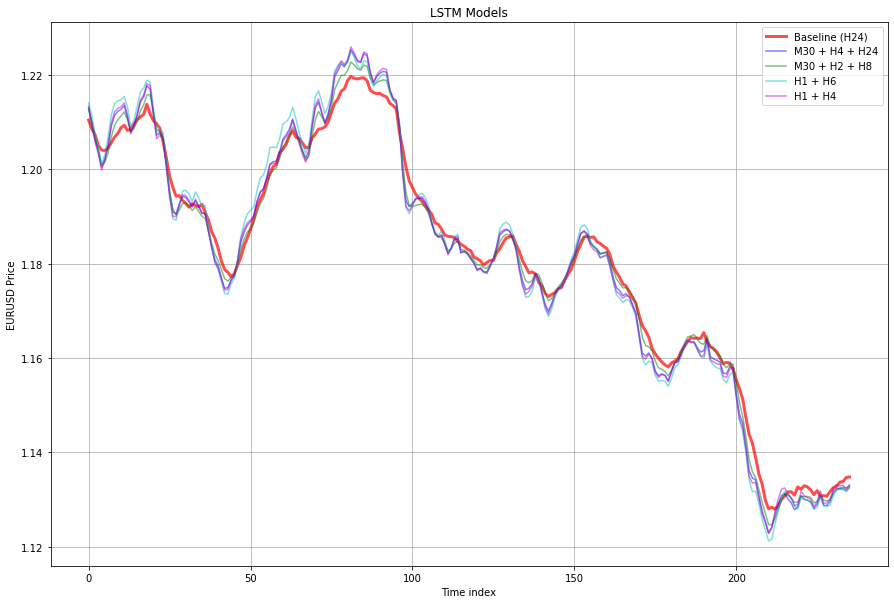

In [111]:
# Plotting Baseline vs Predicted outputs from Model 1 to 4 in a plot

x_plot = range(0, len(y_pred_GRU_1))
y_pred_test_GRU = y_pred_test_GRU[:len(x_plot)]
y_pred_test_LSTM = y_pred_test_LSTM[:len(x_plot)]
# GRU Models
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_test_GRU[::-1], 'r', label='Baseline (H24)', alpha=0.7, linewidth=3)
plt.plot(x_plot, y_pred_GRU_1[::-1], 'b', label='M30 + H4 + H24', alpha=0.5)
plt.plot(x_plot, y_pred_GRU_2[::-1], 'g', label='M30 + H2 + H8', alpha=0.5)
plt.plot(x_plot, y_pred_GRU_3[::-1], 'c', label='H1 + H6', alpha=0.5)
plt.plot(x_plot, y_pred_GRU_4[::-1], 'm', label='H1 + H4', alpha=0.5)
plt.title('GRU Models')
plt.xlabel('Time index')
plt.ylabel('EURUSD Price')
plt.grid(True)
plt.legend()

# LSTM Models
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_pred_test_LSTM[::-1], 'r', label='Baseline (H24)', alpha=0.7, linewidth=3)
plt.plot(x_plot, y_pred_LSTM_1[::-1], 'b', label='M30 + H4 + H24', alpha=0.5)
plt.plot(x_plot, y_pred_LSTM_2[::-1], 'g', label='M30 + H2 + H8', alpha=0.5)
plt.plot(x_plot, y_pred_LSTM_3[::-1], 'c', label='H1 + H6', alpha=0.5)
plt.plot(x_plot, y_pred_LSTM_4[::-1], 'm', label='H1 + H4', alpha=0.5)
plt.title('LSTM Models')
plt.xlabel('Time index')
plt.ylabel('EURUSD Price')
plt.grid(True)
plt.legend()

## Actual vs Model predictions plot

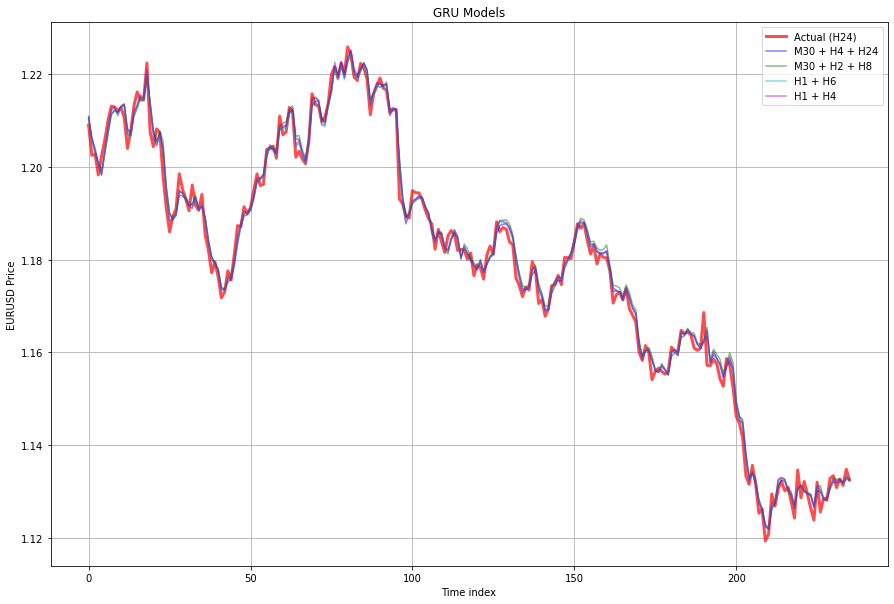

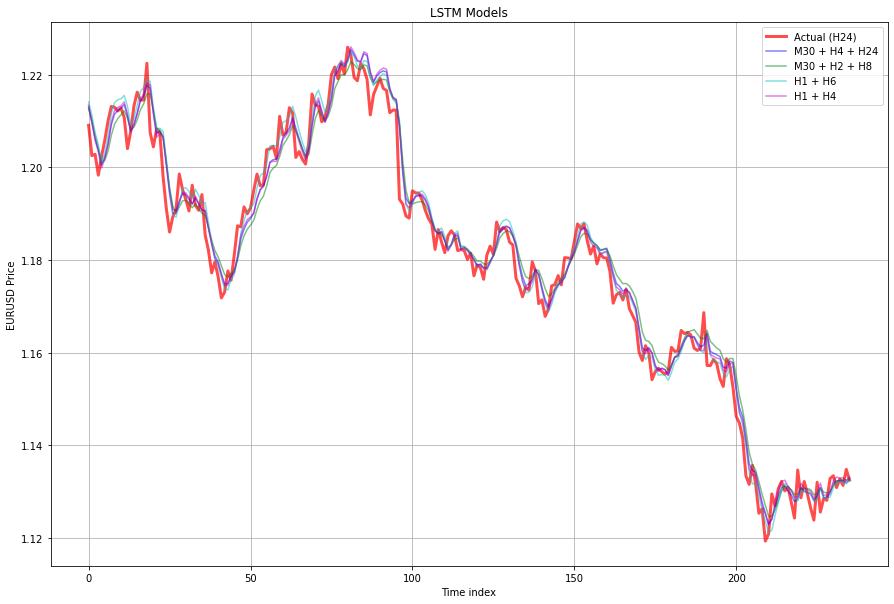

In [112]:
# Plotting Actual vs Predicted outputs from Model 1 to 4 in a plot

x_plot = range(0, len(y_pred_GRU_1))
y_test = y_test[:len(x_plot)]

# GRU Models
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual (H24)', alpha=0.7, linewidth=3)
plt.plot(x_plot, y_pred_GRU_1[::-1], 'b', label='M30 + H4 + H24', alpha=0.5)
plt.plot(x_plot, y_pred_GRU_2[::-1], 'g', label='M30 + H2 + H8', alpha=0.5)
plt.plot(x_plot, y_pred_GRU_3[::-1], 'c', label='H1 + H6', alpha=0.5)
plt.plot(x_plot, y_pred_GRU_4[::-1], 'm', label='H1 + H4', alpha=0.5)
plt.title('GRU Models')
plt.xlabel('Time index')
plt.ylabel('EURUSD Price')
plt.grid(True)
plt.legend()

# LSTM Models
plt.figure(figsize=(15,10))
plt.plot(x_plot, y_test[::-1], 'r', label='Actual (H24)', alpha=0.7, linewidth=3)
plt.plot(x_plot, y_pred_LSTM_1[::-1], 'b', label='M30 + H4 + H24', alpha=0.5)
plt.plot(x_plot, y_pred_LSTM_2[::-1], 'g', label='M30 + H2 + H8', alpha=0.5)
plt.plot(x_plot, y_pred_LSTM_3[::-1], 'c', label='H1 + H6', alpha=0.5)
plt.plot(x_plot, y_pred_LSTM_4[::-1], 'm', label='H1 + H4', alpha=0.5)
plt.title('LSTM Models')
plt.xlabel('Time index')
plt.ylabel('EURUSD Price')
plt.grid(True)
plt.legend()

In [113]:
len(y_pred_GRU_4)

236